## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.24673351  0.89303228  0.35396095]
 Conferindo: (0.060253375758344954+0j)
Iteração: 2
Mínimo: [ 0.46587428  0.90354471 -0.24673351]
 Conferindo: (0.06014689893054825+0j)
Iteração: 3
Mínimo: [0.51869011 0.81232338 0.46587428]
 Conferindo: (0.05996399085240105+0j)
Iteração: 4
Mínimo: [0.37522089 0.9036093  0.51869011]
 Conferindo: (0.05979039694998038+0j)
Iteração: 5
Mínimo: [0.46485167 0.90279412 0.37522089]
 Conferindo: (0.0596230242109307+0j)
Iteração: 6
Mínimo: [0.49636105 0.8160167  0.46485167]
 Conferindo: (0.05944559279332662+0j)
Iteração: 7
Mínimo: [0.39986291 0.90312111 0.49636105]
 Conferindo: (0.05927597892611282+0j)
Iteração: 8
Mínimo: [0.43179706 0.8869902  0.39986291]
 Conferindo: (0.05911116809588354+0j)
Iteração: 9
Mínimo: [0.43847278 0.89347759 0.43179706]
 Conferindo: (0.05893806527665972+0j)
Iteração: 10
Mínimo: [0.44323498 0.89246071 0.43847278]
 Conferindo: (0.05876269314742459+0j)
Iteração: 11
Mínimo: [0.44076616 0.89374061 0.44323498]
 Confer

Mínimo: [0.41929141 0.66709533 0.37484331]
 Conferindo: (0.04727306344625723+0j)
Iteração: 90
Mínimo: [0.31477166 0.73349639 0.41929141]
 Conferindo: (0.04715664841964831+0j)
Iteração: 91
Mínimo: [0.37166334 0.73733109 0.31477166]
 Conferindo: (0.04704400161681209+0j)
Iteração: 92
Mínimo: [0.41561777 0.66122353 0.37166334]
 Conferindo: (0.046925066370973+0j)
Iteração: 93
Mínimo: [0.31220591 0.7267609  0.41561777]
 Conferindo: (0.04681068021162644+0j)
Iteração: 94
Mínimo: [0.36807851 0.73062758 0.31220591]
 Conferindo: (0.04670002130956803+0j)
Iteração: 95
Mínimo: [0.41216703 0.65512499 0.36807851]
 Conferindo: (0.04658320381568576+0j)
Iteração: 96
Mínimo: [0.30925084 0.72024719 0.41216703]
 Conferindo: (0.04647083708481772+0j)
Iteração: 97
Mínimo: [0.36498089 0.72404934 0.30925084]
 Conferindo: (0.04636216319767989+0j)
Iteração: 98
Mínimo: [0.40813568 0.64960007 0.36498089]
 Conferindo: (0.04624743721088027+0j)
Iteração: 99
Mínimo: [0.3064888  0.71386915 0.40813568]
 Conferindo: (0.046

Mínimo: [0.31135178 0.49538573 0.27871871]
 Conferindo: (0.039494828073425935+0j)
Iteração: 177
Mínimo: [0.23400155 0.54366242 0.31135178]
 Conferindo: (0.03943059445759094+0j)
Iteração: 178
Mínimo: [0.2753891  0.54616314 0.23400155]
 Conferindo: (0.03936856463814483+0j)
Iteração: 179
Mínimo: [0.30792855 0.48956518 0.2753891 ]
 Conferindo: (0.03930320147294464+0j)
Iteração: 180
Mínimo: [0.2311453  0.53765089 0.30792855]
 Conferindo: (0.03924042735489773+0j)
Iteração: 181
Mínimo: [0.27246361 0.53987887 0.2311453 ]
 Conferindo: (0.039179815405785676+0j)
Iteração: 182
Mínimo: [0.30410764 0.4841924  0.27246361]
 Conferindo: (0.039115941651299016+0j)
Iteração: 183
Mínimo: [0.22869422 0.53121721 0.30410764]
 Conferindo: (0.03905461301037669+0j)
Iteração: 184
Mínimo: [0.26918186 0.53350828 0.22869422]
 Conferindo: (0.0389953823761293+0j)
Iteração: 185
Mínimo: [0.30070887 0.47839584 0.26918186]
 Conferindo: (0.03893298309187858+0j)
Iteração: 186
Mínimo: [0.22591809 0.52511212 0.30070887]
 Conf

Mínimo: [0.21806195 0.34691698 0.19530098]
 Conferindo: (0.03544516460275447+0j)
Iteração: 264
Mínimo: [0.16391822 0.38043831 0.21806195]
 Conferindo: (0.03541364678944367+0j)
Iteração: 265
Mínimo: [0.1927878  0.38198085 0.16391822]
 Conferindo: (0.03538323966712849+0j)
Iteração: 266
Mínimo: [0.21526785 0.34243653 0.1927878 ]
 Conferindo: (0.035351231127203175+0j)
Iteração: 267
Mínimo: [0.16173996 0.37567825 0.21526785]
 Conferindo: (0.03532051769305336+0j)
Iteração: 268
Mínimo: [0.26191684 0.27706625 0.16173996]
 Conferindo: (0.03529147235854093+0j)
Iteração: 269
Mínimo: [0.12231511 0.35185867 0.26191684]
 Conferindo: (0.035262833559689594+0j)
Iteração: 270
Mínimo: [0.17993123 0.3693924  0.12231511]
 Conferindo: (0.03523699601811283+0j)
Iteração: 271
Mínimo: [0.25381224 0.27860884 0.17993123]
 Conferindo: (0.035207385887326824+0j)
Iteração: 272
Mínimo: [0.11889359 0.35873323 0.25381224]
 Conferindo: (0.035179472114093946+0j)
Iteração: 273
Mínimo: [0.18537749 0.3616517  0.11889359]
 Co

Mínimo: [0.17725961 0.20072989 0.05611654]
 Conferindo: (0.033643569570912454+0j)
Iteração: 353
Mínimo: [0.14551192 0.17252101 0.17725961]
 Conferindo: (0.033630562795016306+0j)
Iteração: 354
Mínimo: [0.06223351 0.25875443 0.14551192]
 Conferindo: (0.03361964784391179+0j)
Iteração: 355
Mínimo: [0.17985631 0.20013533 0.06223351]
 Conferindo: (0.033607974721849655+0j)
Iteração: 356
Mínimo: [0.10729536 0.18538376 0.17985631]
 Conferindo: (0.0335946641686804+0j)
Iteração: 357
Mínimo: [0.15676632 0.18399102 0.10729536]
 Conferindo: (0.0335831519537672+0j)
Iteração: 358
Mínimo: [0.11252756 0.16369483 0.15676632]
 Conferindo: (0.033571757715280065+0j)
Iteração: 359
Mínimo: [0.14310299 0.18833459 0.11252756]
 Conferindo: (0.033560987292699455+0j)
Iteração: 360
Mínimo: [0.14310299 0.14310299 0.14310299]
 Conferindo: (0.033550654322126845+0j)
Iteração: 361
Mínimo: [0.06403736 0.22469592 0.14310299]
 Conferindo: (0.03354073082559916+0j)
Iteração: 362
Mínimo: [0.16424194 0.19582784 0.06403736]
 Co

Mínimo: [0.06828257 0.10686576 0.10388915]
 Conferindo: (0.03296230513242486+0j)
Iteração: 441
Mínimo: [0.09138891 0.09490393 0.06828257]
 Conferindo: (0.032957618265418376+0j)
Iteração: 442
Mínimo: [0.09138891 0.09138891 0.09138891]
 Conferindo: (0.032952342952508956+0j)
Iteração: 443
Mínimo: [0.09138891 0.09138891 0.09138891]
 Conferindo: (0.03294715720476467+0j)
Iteração: 444
Mínimo: [0.09138891 0.09138891 0.09138891]
 Conferindo: (0.03294211696527065+0j)
Iteração: 445
Mínimo: [0.09138891 0.09138891 0.09138891]
 Conferindo: (0.03293724308327868+0j)
Iteração: 446
Mínimo: [0.09138891 0.09138891 0.09138891]
 Conferindo: (0.032932556247751314+0j)
Iteração: 447
Mínimo: [0.09138891 0.09138891 0.09138891]
 Conferindo: (0.03292807696690813+0j)
Iteração: 448
Mínimo: [0.09138891 0.09138891 0.09138891]
 Conferindo: (0.03292382554795386+0j)
Iteração: 449
Mínimo: [0.09138891 0.09138891 0.09138891]
 Conferindo: (0.03291982207700246+0j)
Iteração: 450
Mínimo: [0.09138891 0.09138891 0.09138891]
 Con

Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.03261507185045505+0j)
Iteração: 548
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.03261274008674363+0j)
Iteração: 549
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.032610355483419784+0j)
Iteração: 550
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.032607926296503914+0j)
Iteração: 551
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.03260546082659735+0j)
Iteração: 552
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.03260296741068771+0j)
Iteração: 553
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.03260045441391616+0j)
Iteração: 554
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.03259793022131677+0j)
Iteração: 555
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.03259540322953675+0j)
Iteração: 556
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conferindo: (0.03259288183854472+0j)
Iteração: 557
Mínimo: [0.05526035 0.05526035 0.05526035]
 Conf

Mínimo: [0.03341068 0.04597513 0.05165255]
 Conferindo: (0.032473309824274446+0j)
Iteração: 637
Mínimo: [0.03341068 0.03341068 0.03341068]
 Conferindo: (0.032472688163542957+0j)
Iteração: 638
Mínimo: [0.03341068 0.03341068 0.03341068]
 Conferindo: (0.03247194468007645+0j)
Iteração: 639
Mínimo: [0.03341068 0.03341068 0.03341068]
 Conferindo: (0.03247110566109236+0j)
Iteração: 640
Mínimo: [0.03341068 0.03341068 0.03341068]
 Conferindo: (0.03247017410533599+0j)
Iteração: 641
Mínimo: [0.03341068 0.03341068 0.03341068]
 Conferindo: (0.03246915310297184+0j)
Iteração: 642
Mínimo: [0.03341068 0.03341068 0.03341068]
 Conferindo: (0.032468045832532516+0j)
Iteração: 643
Mínimo: [0.04766463 0.0461709  0.03341068]
 Conferindo: (0.03246668036039962+0j)
Iteração: 644
Mínimo: [0.04766463 0.04766463 0.04766463]
 Conferindo: (0.032465472911838496+0j)
Iteração: 645
Mínimo: [0.04766463 0.04766463 0.04766463]
 Conferindo: (0.03246456951972481+0j)
Iteração: 646
Mínimo: [0.03319965 0.04397417 0.04766463]
 Co

 Conferindo: (0.03240269534689299+0j)
Iteração: 739
Mínimo: [0.02011017 0.02975327 0.03594683]
 Conferindo: (0.03240241025523292+0j)
Iteração: 740
Mínimo: [0.02011017 0.02011017 0.02011017]
 Conferindo: (0.03240219003077467+0j)
Iteração: 741
Mínimo: [0.02011017 0.02011017 0.02011017]
 Conferindo: (0.03240191241544115+0j)
Iteração: 742
Mínimo: [0.02011017 0.02011017 0.02011017]
 Conferindo: (0.032401586326980286+0j)
Iteração: 743
Mínimo: [0.02011017 0.02011017 0.02011017]
 Conferindo: (0.03240121287551562+0j)
Iteração: 744
Mínimo: [0.02011017 0.02011017 0.02011017]
 Conferindo: (0.032400793217925467+0j)
Iteração: 745
Mínimo: [0.02011017 0.02011017 0.02011017]
 Conferindo: (0.03240032855670137+0j)
Iteração: 746
Mínimo: [0.02011017 0.02011017 0.02011017]
 Conferindo: (0.03239982013876085+0j)
Iteração: 747
Mínimo: [0.03409143 0.03077028 0.02011017]
 Conferindo: (0.032399122761425224+0j)
Iteração: 748
Mínimo: [0.03409143 0.03409143 0.03409143]
 Conferindo: (0.03239853875111548+0j)
Iteração:

Mínimo: [0.02709889 0.02709889 0.02709889]
 Conferindo: (0.032372776540822566+0j)
Iteração: 839
Mínimo: [0.02709889 0.02709889 0.02709889]
 Conferindo: (0.03237262672502192+0j)
Iteração: 840
Mínimo: [0.01102641 0.01954954 0.02709889]
 Conferindo: (0.03237251646737057+0j)
Iteração: 841
Mínimo: [0.01102641 0.01102641 0.01102641]
 Conferindo: (0.03237245090753771+0j)
Iteração: 842
Mínimo: [0.01102641 0.01102641 0.01102641]
 Conferindo: (0.03237235699161419+0j)
Iteração: 843
Mínimo: [0.01102641 0.01102641 0.01102641]
 Conferindo: (0.03237223527451186+0j)
Iteração: 844
Mínimo: [0.01102641 0.01102641 0.01102641]
 Conferindo: (0.032372086113261644+0j)
Iteração: 845
Mínimo: [0.01102641 0.01102641 0.01102641]
 Conferindo: (0.032371909891976816+0j)
Iteração: 846
Mínimo: [0.01102641 0.01102641 0.01102641]
 Conferindo: (0.032371707021480255+0j)
Iteração: 847
Mínimo: [0.01102641 0.01102641 0.01102641]
 Conferindo: (0.0323714779388954+0j)
Iteração: 848
Mínimo: [0.0260215  0.02106552 0.01102641]
 Con

Mínimo: [0.0180965  0.01217245 0.00097333]
 Conferindo: (0.03236100923584047+0j)
Iteração: 932
Mínimo: [0.0180965 0.0180965 0.0180965]
 Conferindo: (0.03236082454621629+0j)
Iteração: 933
Mínimo: [0.0180965 0.0180965 0.0180965]
 Conferindo: (0.03236073808098005+0j)
Iteração: 934
Mínimo: [0.0180965 0.0180965 0.0180965]
 Conferindo: (0.032360738898308455+0j)
Iteração: 935
Mínimo: [0.00376945 0.0111707  0.0180965 ]
 Conferindo: (0.03236070754883971+0j)
Iteração: 936
Mínimo: [0.00376945 0.00376945 0.00376945]
 Conferindo: (0.03236069479210599+0j)
Iteração: 937
Mínimo: [0.00376945 0.00376945 0.00376945]
 Conferindo: (0.03236066893998947+0j)
Iteração: 938
Mínimo: [0.00376945 0.00376945 0.00376945]
 Conferindo: (0.03236062930357102+0j)
Iteração: 939
Mínimo: [0.00376945 0.00376945 0.00376945]
 Conferindo: (0.032360575949133295+0j)
Iteração: 940
Mínimo: [0.01775834 0.01291296 0.00376945]
 Conferindo: (0.03236037715428283+0j)
Iteração: 941
Mínimo: [0.01775834 0.01775834 0.01775834]
 Conferindo: (

Mínimo: [0.00013175 0.00729718 0.01498065]
 Conferindo: (0.03235666413249033+0j)
Iteração: 1033
Mínimo: [0.00013175 0.00013175 0.00013175]
 Conferindo: (0.03235666036754384+0j)
Iteração: 1034
Mínimo: [0.00013175 0.00013175 0.00013175]
 Conferindo: (0.03235665913213865+0j)
Iteração: 1035
Mínimo: [0.00013175 0.00013175 0.00013175]
 Conferindo: (0.03235665739249797+0j)
Iteração: 1036
Mínimo: [0.00013175 0.00013175 0.00013175]
 Conferindo: (0.03235665514977191+0j)
Iteração: 1037
Mínimo: [0.0147995  0.00920852 0.00013175]
 Conferindo: (0.03235651203002271+0j)
Iteração: 1038
Mínimo: [0.0147995 0.0147995 0.0147995]
 Conferindo: (0.03235640290443392+0j)
Iteração: 1039
Mínimo: [0.0147995 0.0147995 0.0147995]
 Conferindo: (0.03235637567522941+0j)
Iteração: 1040
Mínimo: [0.0147995 0.0147995 0.0147995]
 Conferindo: (0.03235642319311306+0j)
Iteração: 1041
Mínimo: [-0.0008255  0.0066819  0.0147995]
 Conferindo: (0.03235639918562787+0j)
Iteração: 1042
Mínimo: [-0.0008255 -0.0008255 -0.0008255]
 Confe

Mínimo: [0.00048771 0.00048771 0.00048771]
 Conferindo: (0.03235473105464644+0j)
Iteração: 1136
Mínimo: [0.00048771 0.00048771 0.00048771]
 Conferindo: (0.03235472409310169+0j)
Iteração: 1137
Mínimo: [0.00048771 0.00048771 0.00048771]
 Conferindo: (0.03235471605037345+0j)
Iteração: 1138
Mínimo: [0.01612796 0.00936806 0.00048771]
 Conferindo: (0.032354554214640535+0j)
Iteração: 1139
Mínimo: [0.01612796 0.01612796 0.01612796]
 Conferindo: (0.03235445659717301+0j)
Iteração: 1140
Mínimo: [0.01612796 0.01612796 0.01612796]
 Conferindo: (0.03235448164946505+0j)
Iteração: 1141
Mínimo: [-0.00067486  0.00661706  0.01612796]
 Conferindo: (0.032354447451405956+0j)
Iteração: 1142
Mínimo: [-0.00067486 -0.00067486 -0.00067486]
 Conferindo: (0.03235443890344998+0j)
Iteração: 1143
Mínimo: [-0.00067486 -0.00067486 -0.00067486]
 Conferindo: (0.03235443950889001+0j)
Iteração: 1144
Mínimo: [-0.00067486 -0.00067486 -0.00067486]
 Conferindo: (0.03235444199729319+0j)
Iteração: 1145
Mínimo: [-0.00067486 -0.00

Mínimo: [ 0.00945959  0.0033296  -0.00590798]
 Conferindo: (0.03235352480997192+0j)
Iteração: 1223
Mínimo: [0.00945959 0.00945959 0.00945959]
 Conferindo: (0.03235347164001466+0j)
Iteração: 1224
Mínimo: [0.00945959 0.00945959 0.00945959]
 Conferindo: (0.03235346430352147+0j)
Iteração: 1225
Mínimo: [0.00945959 0.00945959 0.00945959]
 Conferindo: (0.0323534953024916+0j)
Iteração: 1226
Mínimo: [0.00945959 0.00945959 0.00945959]
 Conferindo: (0.032353564780681104+0j)
Iteração: 1227
Mínimo: [-0.00613935  0.00108774  0.00945959]
 Conferindo: (0.03235352472695219+0j)
Iteração: 1228
Mínimo: [-0.00613935 -0.00613935 -0.00613935]
 Conferindo: (0.032353509865047855+0j)
Iteração: 1229
Mínimo: [-0.00613935 -0.00613935 -0.00613935]
 Conferindo: (0.03235353187415125+0j)
Iteração: 1230
Mínimo: [-0.00613935 -0.00613935 -0.00613935]
 Conferindo: (0.03235358621780608+0j)
Iteração: 1231
Mínimo: [ 0.01014035  0.00356224 -0.00613935]
 Conferindo: (0.03235350342653754+0j)
Iteração: 1232
Mínimo: [0.01014035 0

Mínimo: [0.00810253 0.00810253 0.00810253]
 Conferindo: (0.03235313952118456+0j)
Iteração: 1312
Mínimo: [0.00810253 0.00810253 0.00810253]
 Conferindo: (0.03235313667837415+0j)
Iteração: 1313
Mínimo: [0.00810253 0.00810253 0.00810253]
 Conferindo: (0.03235316419754817+0j)
Iteração: 1314
Mínimo: [0.00810253 0.00810253 0.00810253]
 Conferindo: (0.032353222179263535+0j)
Iteração: 1315
Mínimo: [-0.00631033  0.00028049  0.00810253]
 Conferindo: (0.032353183604596374+0j)
Iteração: 1316
Mínimo: [-0.00631033 -0.00631033 -0.00631033]
 Conferindo: (0.03235316718188922+0j)
Iteração: 1317
Mínimo: [-0.00631033 -0.00631033 -0.00631033]
 Conferindo: (0.03235318567246216+0j)
Iteração: 1318
Mínimo: [-0.00631033 -0.00631033 -0.00631033]
 Conferindo: (0.03235323490475118+0j)
Iteração: 1319
Mínimo: [ 0.00874896  0.00257892 -0.00631033]
 Conferindo: (0.03235317063373096+0j)
Iteração: 1320
Mínimo: [0.00874896 0.00874896 0.00874896]
 Conferindo: (0.03235312692645638+0j)
Iteração: 1321
Mínimo: [0.00874896 0.0

Mínimo: [-0.00718051  0.00079344  0.011144  ]
 Conferindo: (0.03235300140807826+0j)
Iteração: 1404
Mínimo: [-0.00718051 -0.00718051 -0.00718051]
 Conferindo: (0.03235297088806227+0j)
Iteração: 1405
Mínimo: [-0.00718051 -0.00718051 -0.00718051]
 Conferindo: (0.03235298508531399+0j)
Iteração: 1406
Mínimo: [-0.00718051 -0.00718051 -0.00718051]
 Conferindo: (0.03235303553243655+0j)
Iteração: 1407
Mínimo: [ 0.00779488  0.00163184 -0.00718051]
 Conferindo: (0.03235297979889061+0j)
Iteração: 1408
Mínimo: [0.00779488 0.00779488 0.00779488]
 Conferindo: (0.032352942929232034+0j)
Iteração: 1409
Mínimo: [0.00779488 0.00779488 0.00779488]
 Conferindo: (0.03235294339448538+0j)
Iteração: 1410
Mínimo: [0.00779488 0.00779488 0.00779488]
 Conferindo: (0.032352974529559264+0j)
Iteração: 1411
Mínimo: [0.00779488 0.00779488 0.00779488]
 Conferindo: (0.032353036421915664+0j)
Iteração: 1412
Mínimo: [-0.00734005 -0.00051214  0.00779488]
 Conferindo: (0.032352988345425+0j)
Iteração: 1413
Mínimo: [-0.00734005 

Mínimo: [-0.00694787  0.00038791  0.01000178]
 Conferindo: (0.03235286802793247+0j)
Iteração: 1492
Mínimo: [-0.00694787 -0.00694787 -0.00694787]
 Conferindo: (0.03235283959545249+0j)
Iteração: 1493
Mínimo: [-0.00694787 -0.00694787 -0.00694787]
 Conferindo: (0.03235285101189548+0j)
Iteração: 1494
Mínimo: [-0.00694787 -0.00694787 -0.00694787]
 Conferindo: (0.032352894894985794+0j)
Iteração: 1495
Mínimo: [ 0.00691708  0.0011691  -0.00694787]
 Conferindo: (0.03235284947786966+0j)
Iteração: 1496
Mínimo: [0.00691708 0.00691708 0.00691708]
 Conferindo: (0.032352820181487094+0j)
Iteração: 1497
Mínimo: [0.00691708 0.00691708 0.00691708]
 Conferindo: (0.032352821687015004+0j)
Iteração: 1498
Mínimo: [0.00691708 0.00691708 0.00691708]
 Conferindo: (0.032352848377187646+0j)
Iteração: 1499
Mínimo: [0.00691708 0.00691708 0.00691708]
 Conferindo: (0.03235290031859616+0j)
Iteração: 1500
Mínimo: [-0.00708516 -0.0008077   0.00691708]
 Conferindo: (0.03235285675494635+0j)
Iteração: 1501
Mínimo: [-0.007085

Mínimo: [-0.00661226  0.00015209  0.00908076]
 Conferindo: (0.03235277444069047+0j)
Iteração: 1580
Mínimo: [-0.00661226 -0.00661226 -0.00661226]
 Conferindo: (0.03235274864551206+0j)
Iteração: 1581
Mínimo: [-0.00661226 -0.00661226 -0.00661226]
 Conferindo: (0.03235275784615904+0j)
Iteração: 1582
Mínimo: [-0.00661226 -0.00661226 -0.00661226]
 Conferindo: (0.032352795626519715+0j)
Iteração: 1583
Mínimo: [-0.00661226 -0.00661226 -0.00661226]
 Conferindo: (0.0323528620341952+0j)
Iteração: 1584
Mínimo: [ 0.01015052  0.00283953 -0.00661226]
 Conferindo: (0.03235278224112676+0j)
Iteração: 1585
Mínimo: [0.01015052 0.01015052 0.01015052]
 Conferindo: (0.03235273643729633+0j)
Iteração: 1586
Mínimo: [0.01015052 0.01015052 0.01015052]
 Conferindo: (0.032352755791461726+0j)
Iteração: 1587
Mínimo: [0.01015052 0.01015052 0.01015052]
 Conferindo: (0.032352833384861175+0j)
Iteração: 1588
Mínimo: [-7.61273296e-03  3.13252431e-05  1.01505175e-02]
 Conferindo: (0.03235277204097951+0j)
Iteração: 1589
Mínim

Iteração: 1668
Mínimo: [-0.00627219 -0.00627219 -0.00627219]
 Conferindo: (0.03235266273321625+0j)
Iteração: 1669
Mínimo: [-0.00627219 -0.00627219 -0.00627219]
 Conferindo: (0.03235267020869403+0j)
Iteração: 1670
Mínimo: [-0.00627219 -0.00627219 -0.00627219]
 Conferindo: (0.03235270280550584+0j)
Iteração: 1671
Mínimo: [-0.00627219 -0.00627219 -0.00627219]
 Conferindo: (0.0323527605677643+0j)
Iteração: 1672
Mínimo: [ 0.00926255  0.00246896 -0.00627219]
 Conferindo: (0.03235269349447151+0j)
Iteração: 1673
Mínimo: [0.00926255 0.00926255 0.00926255]
 Conferindo: (0.03235265542493468+0j)
Iteração: 1674
Mínimo: [0.00926255 0.00926255 0.00926255]
 Conferindo: (0.03235267247499756+0j)
Iteração: 1675
Mínimo: [0.00926255 0.00926255 0.00926255]
 Conferindo: (0.03235273876317556+0j)
Iteração: 1676
Mínimo: [-0.0071964  -0.00013203  0.00926255]
 Conferindo: (0.03235268487332199+0j)
Iteração: 1677
Mínimo: [-0.0071964 -0.0071964 -0.0071964]
 Conferindo: (0.03235265464558111+0j)
Iteração: 1678
Mínimo: 

Mínimo: [-0.0060154   0.00011904  0.00840318]
 Conferindo: (0.032352605488308775+0j)
Iteração: 1756
Mínimo: [-0.0060154 -0.0060154 -0.0060154]
 Conferindo: (0.03235258256224275+0j)
Iteração: 1757
Mínimo: [-0.0060154 -0.0060154 -0.0060154]
 Conferindo: (0.03235258800511483+0j)
Iteração: 1758
Mínimo: [-0.0060154 -0.0060154 -0.0060154]
 Conferindo: (0.03235261615621858+0j)
Iteração: 1759
Mínimo: [-0.0060154 -0.0060154 -0.0060154]
 Conferindo: (0.03235266705794536+0j)
Iteração: 1760
Mínimo: [ 0.00849153  0.00214288 -0.0060154 ]
 Conferindo: (0.03235260991401585+0j)
Iteração: 1761
Mínimo: [0.00849153 0.00849153 0.00849153]
 Conferindo: (0.03235257763046286+0j)
Iteração: 1762
Mínimo: [0.00849153 0.00849153 0.00849153]
 Conferindo: (0.03235259230870042+0j)
Iteração: 1763
Mínimo: [0.00849153 0.00849153 0.00849153]
 Conferindo: (0.03235264882693659+0j)
Iteração: 1764
Mínimo: [-0.00674256 -0.00021848  0.00849153]
 Conferindo: (0.03235260192238337+0j)
Iteração: 1765
Mínimo: [-0.00674256 -0.006742

Mínimo: [-0.00977005 -0.00204336  0.00769827]
 Conferindo: (0.032352559698708865+0j)
Iteração: 1845
Mínimo: [-0.00977005 -0.00977005 -0.00977005]
 Conferindo: (0.03235251823438333+0j)
Iteração: 1846
Mínimo: [-0.00977005 -0.00977005 -0.00977005]
 Conferindo: (0.03235254223217709+0j)
Iteração: 1847
Mínimo: [-0.00977005 -0.00977005 -0.00977005]
 Conferindo: (0.03235262455810779+0j)
Iteração: 1848
Mínimo: [ 0.00870828  0.0008659  -0.00977005]
 Conferindo: (0.03235255073016155+0j)
Iteração: 1849
Mínimo: [0.00870828 0.00870828 0.00870828]
 Conferindo: (0.032352506951507466+0j)
Iteração: 1850
Mínimo: [0.00870828 0.00870828 0.00870828]
 Conferindo: (0.032352516948369915+0j)
Iteração: 1851
Mínimo: [0.00870828 0.00870828 0.00870828]
 Conferindo: (0.032352571395725+0j)
Iteração: 1852
Mínimo: [-6.43300803e-03 -9.35492694e-06  8.70827839e-03]
 Conferindo: (0.03235252628222901+0j)
Iteração: 1853
Mínimo: [-0.00643301 -0.00643301 -0.00643301]
 Conferindo: (0.03235250021523926+0j)
Iteração: 1854
Mínimo

 Conferindo: (0.03235246278437038+0j)
Iteração: 1935
Mínimo: [-0.00907531 -0.00907531 -0.00907531]
 Conferindo: (0.03235253316660367+0j)
Iteração: 1936
Mínimo: [ 0.00800972  0.00075149 -0.00907531]
 Conferindo: (0.03235247036212466+0j)
Iteração: 1937
Mínimo: [0.00800972 0.00800972 0.00800972]
 Conferindo: (0.03235243323363508+0j)
Iteração: 1938
Mínimo: [0.00800972 0.00800972 0.00800972]
 Conferindo: (0.03235244185845404+0j)
Iteração: 1939
Mínimo: [0.00800972 0.00800972 0.00800972]
 Conferindo: (0.03235248828413448+0j)
Iteração: 1940
Mínimo: [-5.99442495e-03 -5.57557459e-05  8.00972360e-03]
 Conferindo: (0.03235244932916274+0j)
Iteração: 1941
Mínimo: [-0.00599442 -0.00599442 -0.00599442]
 Conferindo: (0.03235242668651317+0j)
Iteração: 1942
Mínimo: [-0.00599442 -0.00599442 -0.00599442]
 Conferindo: (0.03235243141999642+0j)
Iteração: 1943
Mínimo: [-0.00599442 -0.00599442 -0.00599442]
 Conferindo: (0.032352458140202836+0j)
Iteração: 1944
Mínimo: [-0.00599442 -0.00599442 -0.00599442]
 Confe

In [4]:
## Constantes

horizonte = 4
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos4 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo4 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda4[0][iteracao] = ondaOrigem[0][0]
    valoresOnda4[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes4[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes4[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos4[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo4[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.66411423  0.84696457  0.96780274  0.37020128]
 Conferindo: (0.060253375758344954+0j)
Iteração: 2
Mínimo: [ 0.4692317   0.91238954  0.81402851 -0.66411423]
 Conferindo: (0.06014689893054825+0j)
Iteração: 3
Mínimo: [0.44753751 0.84928485 0.8784332  0.4692317 ]
 Conferindo: (0.05996399085240105+0j)
Iteração: 4
Mínimo: [0.44652706 0.86563393 0.88956232 0.44753751]
 Conferindo: (0.05979039694998038+0j)
Iteração: 5
Mínimo: [0.44894841 0.84658045 0.87246041 0.44652706]
 Conferindo: (0.0596230242109307+0j)
Iteração: 6
Mínimo: [0.44594554 0.84405815 0.87058802 0.44894841]
 Conferindo: (0.05944559279332662+0j)
Iteração: 7
Mínimo: [0.44489135 0.84206159 0.86825544 0.44594554]
 Conferindo: (0.05927597892611282+0j)
Iteração: 8
Mínimo: [0.44343918 0.83974277 0.86592658 0.44489135]
 Conferindo: (0.05911116809588354+0j)
Iteração: 9
Mínimo: [0.44268002 0.8377632  0.86370525 0.44343918]
 Conferindo: (0.05893806527665972+0j)
Iteração: 10
Mínimo: [0.44163434 0.83568308 0.86155655 0

Mínimo: [0.35139425 0.63883465 0.66986933 0.41234361]
 Conferindo: (0.048353865490181655+0j)
Iteração: 81
Mínimo: [0.30365823 0.66090837 0.68876733 0.35139425]
 Conferindo: (0.04823130833678449+0j)
Iteração: 82
Mínimo: [0.40418487 0.6425636  0.63821844 0.30365823]
 Conferindo: (0.0481126928048228+0j)
Iteração: 83
Mínimo: [0.34800014 0.63124929 0.66105482 0.40418487]
 Conferindo: (0.04798742809509159+0j)
Iteração: 84
Mínimo: [0.29943241 0.65352862 0.68127155 0.34800014]
 Conferindo: (0.047866908614290965+0j)
Iteração: 85
Mínimo: [0.4000047  0.63559192 0.63104989 0.29943241]
 Conferindo: (0.047750305970116355+0j)
Iteração: 86
Mínimo: [0.344131  0.624615  0.6541204 0.4000047]
 Conferindo: (0.04762716345425798+0j)
Iteração: 87
Mínimo: [0.29682536 0.64681124 0.67398505 0.344131  ]
 Conferindo: (0.04750869575032521+0j)
Iteração: 88
Mínimo: [0.39510616 0.62848776 0.62421671 0.29682536]
 Conferindo: (0.04739408398866697+0j)
Iteração: 89
Mínimo: [0.34045951 0.61762114 0.6466407  0.39510616]
 Co

Mínimo: [0.2594972  0.46573895 0.47911659 0.26061132]
 Conferindo: (0.040667055132415524+0j)
Iteração: 160
Mínimo: [0.25838175 0.46372382 0.47703449 0.2594972 ]
 Conferindo: (0.04059602165018013+0j)
Iteração: 161
Mínimo: [0.25729535 0.46172122 0.47497468 0.25838175]
 Conferindo: (0.04052114821549161+0j)
Iteração: 162
Mínimo: [0.25619379 0.4597561  0.47294797 0.25729535]
 Conferindo: (0.04044922120727939+0j)
Iteração: 163
Mínimo: [0.25510934 0.45782433 0.4709678  0.25619379]
 Conferindo: (0.04037975694170613+0j)
Iteração: 164
Mínimo: [0.2539993  0.45581243 0.46889713 0.25510934]
 Conferindo: (0.040306538373476995+0j)
Iteração: 165
Mínimo: [0.25291413 0.45386468 0.4668819  0.2539993 ]
 Conferindo: (0.04023620865534576+0j)
Iteração: 166
Mínimo: [0.25183443 0.45190422 0.46486861 0.25291413]
 Conferindo: (0.040168275379645714+0j)
Iteração: 167
Mínimo: [0.25074246 0.44995242 0.46285565 0.25183443]
 Conferindo: (0.04009668069846415+0j)
Iteração: 168
Mínimo: [0.24968221 0.4480889  0.46093074 0

Mínimo: [0.18220772 0.32683226 0.33608344 0.18306243]
 Conferindo: (0.036330195427821774+0j)
Iteração: 239
Mínimo: [0.18136719 0.32536919 0.33457502 0.18220772]
 Conferindo: (0.03628991844983277+0j)
Iteração: 240
Mínimo: [0.18052109 0.32395613 0.33311312 0.18136719]
 Conferindo: (0.03625126158071674+0j)
Iteração: 241
Mínimo: [0.179677   0.32230166 0.33141179 0.18052109]
 Conferindo: (0.036213963214185525+0j)
Iteração: 242
Mínimo: [0.17884938 0.32080215 0.32986715 0.179677  ]
 Conferindo: (0.03617469083515707+0j)
Iteração: 243
Mínimo: [0.17801662 0.31928431 0.32830533 0.17884938]
 Conferindo: (0.03613700261554577+0j)
Iteração: 244
Mínimo: [0.17720157 0.3179094  0.32689143 0.17801662]
 Conferindo: (0.036100631976203924+0j)
Iteração: 245
Mínimo: [0.17635218 0.31634476 0.32527909 0.17720157]
 Conferindo: (0.036062340278576674+0j)
Iteração: 246
Mínimo: [0.17554501 0.31491268 0.32380603 0.17635218]
 Conferindo: (0.036025593477596055+0j)
Iteração: 247
Mínimo: [0.17473323 0.31343026 0.32227869

Mínimo: [0.12579732 0.22559482 0.23192808 0.12641573]
 Conferindo: (0.03416363814367367+0j)
Iteração: 317
Mínimo: [0.1251919  0.22452903 0.23083033 0.12579732]
 Conferindo: (0.034145089268455664+0j)
Iteração: 318
Mínimo: [0.12458798 0.22342958 0.22969924 0.1251919 ]
 Conferindo: (0.0341278485733833+0j)
Iteração: 319
Mínimo: [0.12398914 0.22242191 0.228656   0.12458798]
 Conferindo: (0.03410926991113518+0j)
Iteração: 320
Mínimo: [0.12339314 0.22135817 0.22756464 0.12398914]
 Conferindo: (0.0340932672061582+0j)
Iteração: 321
Mínimo: [0.12279417 0.22025408 0.22643598 0.12339314]
 Conferindo: (0.03407706901370092+0j)
Iteração: 322
Mínimo: [0.12219068 0.21915422 0.22529317 0.12279417]
 Conferindo: (0.03406167335163059+0j)
Iteração: 323
Mínimo: [0.12162158 0.2180783  0.22419639 0.12219068]
 Conferindo: (0.03404493818564055+0j)
Iteração: 324
Mínimo: [0.12101504 0.21704005 0.22312656 0.12162158]
 Conferindo: (0.034029305447369707+0j)
Iteração: 325
Mínimo: [0.1204478  0.21598718 0.2220424  0.12

Mínimo: [0.03677493 0.15192573 0.16906855 0.08431041]
 Conferindo: (0.033220803659732026+0j)
Iteração: 397
Mínimo: [0.13578917 0.12922289 0.09614291 0.03677493]
 Conferindo: (0.033213150336488154+0j)
Iteração: 398
Mínimo: [0.08317593 0.10741291 0.12485248 0.13578917]
 Conferindo: (0.033206438236063285+0j)
Iteração: 399
Mínimo: [0.03623278 0.14988129 0.16680346 0.08317593]
 Conferindo: (0.03319959930359371+0j)
Iteração: 400
Mínimo: [0.1339595  0.12746923 0.09481953 0.03623278]
 Conferindo: (0.033192642672620655+0j)
Iteração: 401
Mínimo: [0.08202065 0.10594282 0.12315818 0.1339595 ]
 Conferindo: (0.033186202027447126+0j)
Iteração: 402
Mínimo: [0.03577419 0.14795109 0.16463219 0.08202065]
 Conferindo: (0.0331801993932148+0j)
Iteração: 403
Mínimo: [0.13213772 0.12574278 0.09354872 0.03577419]
 Conferindo: (0.033173604374413336+0j)
Iteração: 404
Mínimo: [0.08090438 0.10450141 0.12148354 0.13213772]
 Conferindo: (0.033166758115149186+0j)
Iteração: 405
Mínimo: [0.03534942 0.14579542 0.1622195

Mínimo: [0.09811475 0.09066348 0.06231437 0.01321639]
 Conferindo: (0.03281130633679773+0j)
Iteração: 477
Mínimo: [0.05674596 0.07441743 0.08813696 0.09811475]
 Conferindo: (0.03280786968326044+0j)
Iteração: 478
Mínimo: [0.06901217 0.07913254 0.07497919 0.05674596]
 Conferindo: (0.03280461480372377+0j)
Iteração: 479
Mínimo: [0.01420887 0.09677094 0.11338358 0.06901217]
 Conferindo: (0.032801557369472385+0j)
Iteração: 480
Mínimo: [0.09521099 0.0884481  0.06139958 0.01420887]
 Conferindo: (0.032798712859199226+0j)
Iteração: 481
Mínimo: [0.05553054 0.0728265  0.08598529 0.09521099]
 Conferindo: (0.03279592295405484+0j)
Iteração: 482
Mínimo: [0.06766042 0.07757198 0.07346358 0.05553054]
 Conferindo: (0.03279280046228266+0j)
Iteração: 483
Mínimo: [0.01327254 0.09562465 0.11210521 0.06766042]
 Conferindo: (0.032789017554939674+0j)
Iteração: 484
Mínimo: [0.09401222 0.08711983 0.06015823 0.01327254]
 Conferindo: (0.032785234460420726+0j)
Iteração: 485
Mínimo: [0.05453924 0.07158288 0.08467272 

Mínimo: [0.04863241 0.0547584  0.05034804 0.03552804]
 Conferindo: (0.03259037444333656+0j)
Iteração: 558
Mínimo: [0.04863241 0.04863241 0.04863241 0.04863241]
 Conferindo: (0.03258788942564526+0j)
Iteração: 559
Mínimo: [0.03145998 0.04633779 0.05200918 0.04863241]
 Conferindo: (0.03258543514566417+0j)
Iteração: 560
Mínimo: [0.04648926 0.05248357 0.04743581 0.03145998]
 Conferindo: (0.032583019933791986+0j)
Iteração: 561
Mínimo: [0.04648926 0.04648926 0.04648926 0.04648926]
 Conferindo: (0.03258065208240658+0j)
Iteração: 562
Mínimo: [0.03145826 0.0459261  0.05088558 0.04648926]
 Conferindo: (0.03257833983767662+0j)
Iteração: 563
Mínimo: [0.04524694 0.05157711 0.04694306 0.03145826]
 Conferindo: (0.03257609139141815+0j)
Iteração: 564
Mínimo: [0.04524694 0.04524694 0.04524694 0.04524694]
 Conferindo: (0.03257391487300591+0j)
Iteração: 565
Mínimo: [0.04524694 0.04524694 0.04524694 0.04524694]
 Conferindo: (0.0325718183413459+0j)
Iteração: 566
Mínimo: [0.02744364 0.04280931 0.0486949  0.04

Mínimo: [0.03267388 0.03607662 0.03069457 0.01660162]
 Conferindo: (0.03246668036039962+0j)
Iteração: 644
Mínimo: [0.03267388 0.03267388 0.03267388 0.03267388]
 Conferindo: (0.032465472911838496+0j)
Iteração: 645
Mínimo: [0.03267388 0.03267388 0.03267388 0.03267388]
 Conferindo: (0.03246456951972481+0j)
Iteração: 646
Mínimo: [0.01837734 0.02994481 0.03467484 0.03267388]
 Conferindo: (0.032463860219729676+0j)
Iteração: 647
Mínimo: [0.03209842 0.0358187  0.03122279 0.01837734]
 Conferindo: (0.03246324777349667+0j)
Iteração: 648
Mínimo: [0.03209842 0.03209842 0.03209842 0.03209842]
 Conferindo: (0.032462544416491615+0j)
Iteração: 649
Mínimo: [0.03209842 0.03209842 0.03209842 0.03209842]
 Conferindo: (0.03246177441600012+0j)
Iteração: 650
Mínimo: [0.03209842 0.03209842 0.03209842 0.03209842]
 Conferindo: (0.0324609406762322+0j)
Iteração: 651
Mínimo: [0.01591597 0.02781289 0.03317314 0.03209842]
 Conferindo: (0.032460046164386774+0j)
Iteração: 652
Mínimo: [0.03131752 0.03466665 0.02950846 0

Mínimo: [0.02231129 0.02231129 0.02231129 0.02231129]
 Conferindo: (0.03240737268362844+0j)
Iteração: 729
Mínimo: [0.02231129 0.02231129 0.02231129 0.02231129]
 Conferindo: (0.032407130845075516+0j)
Iteração: 730
Mínimo: [0.02231129 0.02231129 0.02231129 0.02231129]
 Conferindo: (0.03240682526438351+0j)
Iteração: 731
Mínimo: [0.02231129 0.02231129 0.02231129 0.02231129]
 Conferindo: (0.03240646571217202+0j)
Iteração: 732
Mínimo: [0.02231129 0.02231129 0.02231129 0.02231129]
 Conferindo: (0.032406053409203134+0j)
Iteração: 733
Mínimo: [0.02231129 0.02231129 0.02231129 0.02231129]
 Conferindo: (0.03240558962831294+0j)
Iteração: 734
Mínimo: [0.02231129 0.02231129 0.02231129 0.02231129]
 Conferindo: (0.032405075693155067+0j)
Iteração: 735
Mínimo: [0.00890312 0.01782951 0.02227866 0.02231129]
 Conferindo: (0.032404512976894964+0j)
Iteração: 736
Mínimo: [0.02138681 0.023854   0.01967785 0.00890312]
 Conferindo: (0.03240373771884725+0j)
Iteração: 737
Mínimo: [0.02138681 0.02138681 0.02138681 

Mínimo: [0.01526869 0.01706528 0.01354369 0.00472941]
 Conferindo: (0.03237835734223117+0j)
Iteração: 815
Mínimo: [0.01526869 0.01526869 0.01526869 0.01526869]
 Conferindo: (0.03237785385567493+0j)
Iteração: 816
Mínimo: [0.01526869 0.01526869 0.01526869 0.01526869]
 Conferindo: (0.032377458011486324+0j)
Iteração: 817
Mínimo: [0.01526869 0.01526869 0.01526869 0.01526869]
 Conferindo: (0.0323772759969286+0j)
Iteração: 818
Mínimo: [0.01526869 0.01526869 0.01526869 0.01526869]
 Conferindo: (0.03237714311692496+0j)
Iteração: 819
Mínimo: [0.01526869 0.01526869 0.01526869 0.01526869]
 Conferindo: (0.032377059146349516+0j)
Iteração: 820
Mínimo: [0.01526869 0.01526869 0.01526869 0.01526869]
 Conferindo: (0.03237694056809975+0j)
Iteração: 821
Mínimo: [0.01526869 0.01526869 0.01526869 0.01526869]
 Conferindo: (0.03237678905600058+0j)
Iteração: 822
Mínimo: [0.01526869 0.01526869 0.01526869 0.01526869]
 Conferindo: (0.032376605061468375+0j)
Iteração: 823
Mínimo: [0.01526869 0.01526869 0.01526869 0.

Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.03236261986775451+0j)
Iteração: 910
Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.03236256144332312+0j)
Iteração: 911
Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.032362485195799+0j)
Iteração: 912
Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.03236239128455922+0j)
Iteração: 913
Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.03236227988640981+0j)
Iteração: 914
Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.032362017568969156+0j)
Iteração: 915
Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.03236181516786041+0j)
Iteração: 916
Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.032361742918307276+0j)
Iteração: 917
Mínimo: [0.01073735 0.01073735 0.01073735 0.01073735]
 Conferindo: (0.03236179394107335+0j)
Iteração: 918
Mínimo: [0.01073735 0.01073735 0.01073735 0.01

 Conferindo: (0.032358071763650326+0j)
Iteração: 991
Mínimo: [0.00392083 0.00392083 0.00392083 0.00392083]
 Conferindo: (0.03235805948853426+0j)
Iteração: 992
Mínimo: [0.00392083 0.00392083 0.00392083 0.00392083]
 Conferindo: (0.03235804236400127+0j)
Iteração: 993
Mínimo: [0.00392083 0.00392083 0.00392083 0.00392083]
 Conferindo: (0.032357867387776906+0j)
Iteração: 994
Mínimo: [0.01488761 0.01343049 0.00976647 0.00392083]
 Conferindo: (0.03235773092869579+0j)
Iteração: 995
Mínimo: [0.01488761 0.01488761 0.01488761 0.01488761]
 Conferindo: (0.03235768909807188+0j)
Iteração: 996
Mínimo: [0.00383725 0.00750111 0.0111757  0.01488761]
 Conferindo: (0.03235773393240543+0j)
Iteração: 997
Mínimo: [0.00383725 0.00383725 0.00383725 0.00383725]
 Conferindo: (0.03235770776103267+0j)
Iteração: 998
Mínimo: [0.00383725 0.00383725 0.00383725 0.00383725]
 Conferindo: (0.032357703763188535+0j)
Iteração: 999
Mínimo: [0.00383725 0.00383725 0.00383725 0.00383725]
 Conferindo: (0.032357702083292826+0j)
Iter

Mínimo: [0.01213162 0.01030206 0.00677618 0.0015688 ]
 Conferindo: (0.03235569753868894+0j)
Iteração: 1076
Mínimo: [0.01213162 0.01213162 0.01213162 0.01213162]
 Conferindo: (0.03235567677392152+0j)
Iteração: 1077
Mínimo: [0.00158552 0.00466525 0.00817418 0.01213162]
 Conferindo: (0.03235567315964444+0j)
Iteração: 1078
Mínimo: [0.00158552 0.00158552 0.00158552 0.00158552]
 Conferindo: (0.03235567561799631+0j)
Iteração: 1079
Mínimo: [0.00158552 0.00158552 0.00158552 0.00158552]
 Conferindo: (0.032355680875004775+0j)
Iteração: 1080
Mínimo: [0.00158552 0.00158552 0.00158552 0.00158552]
 Conferindo: (0.03235568892600467+0j)
Iteração: 1081
Mínimo: [0.01163916 0.00991342 0.00655789 0.00158552]
 Conferindo: (0.03235557000393436+0j)
Iteração: 1082
Mínimo: [0.01163916 0.01163916 0.01163916 0.01163916]
 Conferindo: (0.03235548143277058+0j)
Iteração: 1083
Mínimo: [0.0016497  0.0045855  0.00790866 0.01163916]
 Conferindo: (0.032355464486748475+0j)
Iteração: 1084
Mínimo: [0.0016497 0.0016497 0.0016

Mínimo: [ 0.01081581  0.00846004  0.00470976 -0.00041999]
 Conferindo: (0.032354228426255696+0j)
Iteração: 1158
Mínimo: [0.01081581 0.01081581 0.01081581 0.01081581]
 Conferindo: (0.03235422580464507+0j)
Iteração: 1159
Mínimo: [-0.00033162  0.00251674  0.00622837  0.01081581]
 Conferindo: (0.03235422283594408+0j)
Iteração: 1160
Mínimo: [-0.00033162 -0.00033162 -0.00033162 -0.00033162]
 Conferindo: (0.032354078477046334+0j)
Iteração: 1161
Mínimo: [-0.00033162 -0.00033162 -0.00033162 -0.00033162]
 Conferindo: (0.03235399276844082+0j)
Iteração: 1162
Mínimo: [-0.00033162 -0.00033162 -0.00033162 -0.00033162]
 Conferindo: (0.03235401850126991+0j)
Iteração: 1163
Mínimo: [ 0.01026947  0.00806483  0.00452659 -0.00033162]
 Conferindo: (0.03235398652274992+0j)
Iteração: 1164
Mínimo: [0.01026947 0.01026947 0.01026947 0.01026947]
 Conferindo: (0.03235397788531214+0j)
Iteração: 1165
Mínimo: [-0.00018164  0.00250667  0.00598667  0.01026947]
 Conferindo: (0.03235397878395534+0j)
Iteração: 1166
Mínimo:

Mínimo: [ 0.00948815  0.00692073  0.00320995 -0.00163493]
 Conferindo: (0.032353594252587596+0j)
Iteração: 1240
Mínimo: [0.00948815 0.00948815 0.00948815 0.00948815]
 Conferindo: (0.03235349364855077+0j)
Iteração: 1241
Mínimo: [-0.00151663  0.00106573  0.00472983  0.00948815]
 Conferindo: (0.03235342414703982+0j)
Iteração: 1242
Mínimo: [-0.00151663 -0.00151663 -0.00151663 -0.00151663]
 Conferindo: (0.03235342165709599+0j)
Iteração: 1243
Mínimo: [-0.00151663 -0.00151663 -0.00151663 -0.00151663]
 Conferindo: (0.03235347584706015+0j)
Iteração: 1244
Mínimo: [-0.00151663 -0.00151663 -0.00151663 -0.00151663]
 Conferindo: (0.0323534441808089+0j)
Iteração: 1245
Mínimo: [ 0.00890413  0.00651169  0.00303649 -0.00151663]
 Conferindo: (0.03235343158186398+0j)
Iteração: 1246
Mínimo: [0.00890413 0.00890413 0.00890413 0.00890413]
 Conferindo: (0.03235344069010681+0j)
Iteração: 1247
Mínimo: [-0.00131557  0.00109125  0.00449481  0.00890413]
 Conferindo: (0.0323534661458747+0j)
Iteração: 1248
Mínimo: [-

Mínimo: [ 0.00942298  0.00651034  0.00272802 -0.00192027]
 Conferindo: (0.032353183604596374+0j)
Iteração: 1316
Mínimo: [0.00942298 0.00942298 0.00942298 0.00942298]
 Conferindo: (0.03235316718188922+0j)
Iteração: 1317
Mínimo: [-2.52518326e-03  5.99200754e-05  4.03932989e-03  9.42297910e-03]
 Conferindo: (0.03235318567246216+0j)
Iteração: 1318
Mínimo: [-0.00252518 -0.00252518 -0.00252518 -0.00252518]
 Conferindo: (0.03235323490475118+0j)
Iteração: 1319
Mínimo: [-0.00252518 -0.00252518 -0.00252518 -0.00252518]
 Conferindo: (0.03235317063373096+0j)
Iteração: 1320
Mínimo: [-0.00252518 -0.00252518 -0.00252518 -0.00252518]
 Conferindo: (0.03235312692645638+0j)
Iteração: 1321
Mínimo: [ 0.00855518  0.00582682  0.0021319  -0.00252518]
 Conferindo: (0.03235312649103214+0j)
Iteração: 1322
Mínimo: [0.00855518 0.00855518 0.00855518 0.00855518]
 Conferindo: (0.03235316254293835+0j)
Iteração: 1323
Mínimo: [-2.37760422e-03  1.51728138e-05  3.65750346e-03  8.55517913e-03]
 Conferindo: (0.0323532351955

Mínimo: [0.00418291 0.00418291 0.00418291 0.00418291]
 Conferindo: (0.03235304336897831+0j)
Iteração: 1398
Mínimo: [-0.00615337 -0.00326338  0.00018252  0.00418291]
 Conferindo: (0.03235310925876825+0j)
Iteração: 1399
Mínimo: [-0.00615337 -0.00615337 -0.00615337 -0.00615337]
 Conferindo: (0.032353016057209055+0j)
Iteração: 1400
Mínimo: [ 0.0039766   0.00210381 -0.00127192 -0.00615337]
 Conferindo: (0.03235295995573907+0j)
Iteração: 1401
Mínimo: [0.0039766 0.0039766 0.0039766 0.0039766]
 Conferindo: (0.03235297746930457+0j)
Iteração: 1402
Mínimo: [0.0039766 0.0039766 0.0039766 0.0039766]
 Conferindo: (0.03235306094542974+0j)
Iteração: 1403
Mínimo: [0.0039766 0.0039766 0.0039766 0.0039766]
 Conferindo: (0.03235300140807826+0j)
Iteração: 1404
Mínimo: [0.0039766 0.0039766 0.0039766 0.0039766]
 Conferindo: (0.03235297088806227+0j)
Iteração: 1405
Mínimo: [-0.00773371 -0.00434336 -0.00043853  0.0039766 ]
 Conferindo: (0.03235298508531399+0j)
Iteração: 1406
Mínimo: [-0.00773371 -0.00773371 -0.

Mínimo: [-0.00275815 -0.00051682  0.00303144  0.00789035]
 Conferindo: (0.032352947725303956+0j)
Iteração: 1478
Mínimo: [-0.00275815 -0.00275815 -0.00275815 -0.00275815]
 Conferindo: (0.03235288602890754+0j)
Iteração: 1479
Mínimo: [-0.00275815 -0.00275815 -0.00275815 -0.00275815]
 Conferindo: (0.03235284908072039+0j)
Iteração: 1480
Mínimo: [-0.00275815 -0.00275815 -0.00275815 -0.00275815]
 Conferindo: (0.03235286091593933+0j)
Iteração: 1481
Mínimo: [ 0.00742026  0.00483272  0.00143907 -0.00275815]
 Conferindo: (0.03235291635014441+0j)
Iteração: 1482
Mínimo: [0.00742026 0.00742026 0.00742026 0.00742026]
 Conferindo: (0.03235287559499163+0j)
Iteração: 1483
Mínimo: [-0.00260545 -0.00049209  0.00284741  0.00742026]
 Conferindo: (0.032352854241258194+0j)
Iteração: 1484
Mínimo: [-0.00260545 -0.00260545 -0.00260545 -0.00260545]
 Conferindo: (0.03235286325844074+0j)
Iteração: 1485
Mínimo: [-0.00260545 -0.00260545 -0.00260545 -0.00260545]
 Conferindo: (0.03235289693381589+0j)
Iteração: 1486
Mín

Mínimo: [-0.00366612 -0.00121179  0.00287544  0.00860159]
 Conferindo: (0.03235276881468098+0j)
Iteração: 1560
Mínimo: [-0.00366612 -0.00366612 -0.00366612 -0.00366612]
 Conferindo: (0.03235280975157594+0j)
Iteração: 1561
Mínimo: [-0.00366612 -0.00366612 -0.00366612 -0.00366612]
 Conferindo: (0.0323528862622994+0j)
Iteração: 1562
Mínimo: [-0.00366612 -0.00366612 -0.00366612 -0.00366612]
 Conferindo: (0.03235281708591969+0j)
Iteração: 1563
Mínimo: [ 0.00788436  0.0048401   0.00098816 -0.00366612]
 Conferindo: (0.032352781601585376+0j)
Iteração: 1564
Mínimo: [0.00788436 0.00788436 0.00788436 0.00788436]
 Conferindo: (0.03235280600846819+0j)
Iteração: 1565
Mínimo: [-0.00353247 -0.00122724  0.00257552  0.00788436]
 Conferindo: (0.03235288367049087+0j)
Iteração: 1566
Mínimo: [-0.00353247 -0.00353247 -0.00353247 -0.00353247]
 Conferindo: (0.032352808029865815+0j)
Iteração: 1567
Mínimo: [-0.00353247 -0.00353247 -0.00353247 -0.00353247]
 Conferindo: (0.032352761441828845+0j)
Iteração: 1568
Mín

Mínimo: [ 0.00370704  0.00152568 -0.00217081 -0.00738799]
 Conferindo: (0.03235270774222525+0j)
Iteração: 1637
Mínimo: [0.00370704 0.00370704 0.00370704 0.00370704]
 Conferindo: (0.03235268093814139+0j)
Iteração: 1638
Mínimo: [0.00370704 0.00370704 0.00370704 0.00370704]
 Conferindo: (0.032352683862564+0j)
Iteração: 1639
Mínimo: [0.00370704 0.00370704 0.00370704 0.00370704]
 Conferindo: (0.03235271093324908+0j)
Iteração: 1640
Mínimo: [-0.00699452 -0.00412092 -0.00055202  0.00370704]
 Conferindo: (0.032352762207651944+0j)
Iteração: 1641
Mínimo: [-0.00699452 -0.00699452 -0.00699452 -0.00699452]
 Conferindo: (0.03235271484223862+0j)
Iteração: 1642
Mínimo: [ 0.00363125  0.00154047 -0.00199975 -0.00699452]
 Conferindo: (0.03235269014013178+0j)
Iteração: 1643
Mínimo: [0.00363125 0.00363125 0.00363125 0.00363125]
 Conferindo: (0.032352705937126344+0j)
Iteração: 1644
Mínimo: [0.00363125 0.00363125 0.00363125 0.00363125]
 Conferindo: (0.0323527576840225+0j)
Iteração: 1645
Mínimo: [0.00363125 0.

Mínimo: [-0.00351719 -0.00128205  0.00243434  0.00763642]
 Conferindo: (0.032352627925353566+0j)
Iteração: 1714
Mínimo: [-0.00351719 -0.00351719 -0.00351719 -0.00351719]
 Conferindo: (0.03235265842507209+0j)
Iteração: 1715
Mínimo: [-0.00351719 -0.00351719 -0.00351719 -0.00351719]
 Conferindo: (0.03235271340150727+0j)
Iteração: 1716
Mínimo: [-0.00351719 -0.00351719 -0.00351719 -0.00351719]
 Conferindo: (0.03235265105640055+0j)
Iteração: 1717
Mínimo: [ 0.00725317  0.0044      0.00080888 -0.00351719]
 Conferindo: (0.032352615728457094+0j)
Iteração: 1718
Mínimo: [0.00725317 0.00725317 0.00725317 0.00725317]
 Conferindo: (0.03235263156454098+0j)
Iteração: 1719
Mínimo: [-0.00334409 -0.00122468  0.00230565  0.00725317]
 Conferindo: (0.03235269299916253+0j)
Iteração: 1720
Mínimo: [-0.00334409 -0.00334409 -0.00334409 -0.00334409]
 Conferindo: (0.032352642531112565+0j)
Iteração: 1721
Mínimo: [-0.00334409 -0.00334409 -0.00334409 -0.00334409]
 Conferindo: (0.032352614006851896+0j)
Iteração: 1722
M

Mínimo: [ 0.00685737  0.00399403  0.00045705 -0.0037524 ]
 Conferindo: (0.03235256139309802+0j)
Iteração: 1793
Mínimo: [0.00685737 0.00685737 0.00685737 0.00685737]
 Conferindo: (0.03235258169398568+0j)
Iteração: 1794
Mínimo: [-0.0035529  -0.00152478  0.00194377  0.00685737]
 Conferindo: (0.0323526506350458+0j)
Iteração: 1795
Mínimo: [-0.0035529 -0.0035529 -0.0035529 -0.0035529]
 Conferindo: (0.032352587793015496+0j)
Iteração: 1796
Mínimo: [-0.0035529 -0.0035529 -0.0035529 -0.0035529]
 Conferindo: (0.03235255025536067+0j)
Iteração: 1797
Mínimo: [-0.0035529 -0.0035529 -0.0035529 -0.0035529]
 Conferindo: (0.03235255832620166+0j)
Iteração: 1798
Mínimo: [ 0.00641981  0.00372285  0.00039823 -0.0035529 ]
 Conferindo: (0.032352604134596924+0j)
Iteração: 1799
Mínimo: [0.00641981 0.00641981 0.00641981 0.00641981]
 Conferindo: (0.03235256653346728+0j)
Iteração: 1800
Mínimo: [0.00641981 0.00641981 0.00641981 0.00641981]
 Conferindo: (0.03235254497341949+0j)
Iteração: 1801
Mínimo: [-0.00733598 -0.

Mínimo: [-0.00666176 -0.00395621 -0.00058467  0.00344939]
 Conferindo: (0.032352594883223326+0j)
Iteração: 1870
Mínimo: [-0.00666176 -0.00666176 -0.00666176 -0.00666176]
 Conferindo: (0.03235252710701812+0j)
Iteração: 1871
Mínimo: [ 0.00329529  0.00133055 -0.001988   -0.00666176]
 Conferindo: (0.03235248808921909+0j)
Iteração: 1872
Mínimo: [0.00329529 0.00329529 0.00329529 0.00329529]
 Conferindo: (0.032352498909344406+0j)
Iteração: 1873
Mínimo: [0.00329529 0.00329529 0.00329529 0.00329529]
 Conferindo: (0.032352550758327686+0j)
Iteração: 1874
Mínimo: [0.00329529 0.00329529 0.00329529 0.00329529]
 Conferindo: (0.032352504955299996+0j)
Iteração: 1875
Mínimo: [0.00329529 0.00329529 0.00329529 0.00329529]
 Conferindo: (0.03235247750888358+0j)
Iteração: 1876
Mínimo: [-0.00820075 -0.00499446 -0.0011599   0.00329529]
 Conferindo: (0.03235248205014944+0j)
Iteração: 1877
Mínimo: [-0.00820075 -0.00820075 -0.00820075 -0.00820075]
 Conferindo: (0.032352512417959396+0j)
Iteração: 1878
Mínimo: [ 0.

Mínimo: [-0.00645073 -0.00645073 -0.00645073 -0.00645073]
 Conferindo: (0.03235245427599814+0j)
Iteração: 1946
Mínimo: [ 0.00358306  0.0016488  -0.00169494 -0.00645073]
 Conferindo: (0.032352424969403916+0j)
Iteração: 1947
Mínimo: [0.00358306 0.00358306 0.00358306 0.00358306]
 Conferindo: (0.03235243924050089+0j)
Iteração: 1948
Mínimo: [0.00358306 0.00358306 0.00358306 0.00358306]
 Conferindo: (0.03235249230739851+0j)
Iteração: 1949
Mínimo: [0.00358306 0.00358306 0.00358306 0.00358306]
 Conferindo: (0.03235244690284938+0j)
Iteração: 1950
Mínimo: [0.00358306 0.00358306 0.00358306 0.00358306]
 Conferindo: (0.032352420659366346+0j)
Iteração: 1951
Mínimo: [-0.00813925 -0.0048194  -0.00091235  0.00358306]
 Conferindo: (0.03235242761233652+0j)
Iteração: 1952
Mínimo: [-0.00813925 -0.00813925 -0.00813925 -0.00813925]
 Conferindo: (0.0323524618789119+0j)
Iteração: 1953
Mínimo: [ 0.00421667  0.00184899 -0.00226911 -0.00813925]
 Conferindo: (0.0323525235123477+0j)
Iteração: 1954
Mínimo: [0.004216

In [5]:
## Constantes

horizonte = 5
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos5 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo5 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda5[0][iteracao] = ondaOrigem[0][0]
    valoresOnda5[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes5[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes5[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos5[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo5[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo5[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.07280149  0.81878734  0.95239593  0.85812713  0.77771252]
 Conferindo: (0.10008924099560856+0j)
Iteração: 2
Mínimo: [0.38523403 0.91804342 0.87872175 0.93528388 0.77771252]
 Conferindo: (0.09971366809511265+0j)
Iteração: 3
Mínimo: [0.41700046 0.93781302 0.89033909 0.93781176 0.77771252]
 Conferindo: (0.09903866166857409+0j)
Iteração: 4
Mínimo: [0.49506039 0.92377627 0.8529485  0.88731507 0.77771252]
 Conferindo: (0.09834119333900551+0j)
Iteração: 5
Mínimo: [0.46948648 0.90212383 0.84037696 0.88049033 0.77771252]
 Conferindo: (0.09764049163750362+0j)
Iteração: 6
Mínimo: [0.45425188 0.89065156 0.83560561 0.87777828 0.77771252]
 Conferindo: (0.09696277421535768+0j)
Iteração: 7
Mínimo: [0.44441947 0.8842335  0.8346833  0.87691884 0.77771252]
 Conferindo: (0.09629799770671552+0j)
Iteração: 8
Mínimo: [0.44441947 0.8842335  0.8346833  0.87691884 0.77771252]
 Conferindo: (0.09564061390816211+0j)
Iteração: 9
Mínimo: [0.43618098 0.87845194 0.83327682 0.87547392 0.77771252

Mínimo: [0.33236105 0.67958226 0.64490243 0.6988677  0.77771252]
 Conferindo: (0.05936083836136062+0j)
Iteração: 79
Mínimo: [0.32771116 0.67017281 0.63554421 0.68967471 0.77771252]
 Conferindo: (0.058983261823057735+0j)
Iteração: 80
Mínimo: [0.32771116 0.67017281 0.63554421 0.68967471 0.77771252]
 Conferindo: (0.05860963484637456+0j)
Iteração: 81
Mínimo: [0.32771116 0.67017281 0.63554421 0.68967471 0.77771252]
 Conferindo: (0.05823911837571116+0j)
Iteração: 82
Mínimo: [0.32308455 0.66083293 0.62625525 0.68051607 0.77771252]
 Conferindo: (0.05787202721709913+0j)
Iteração: 83
Mínimo: [0.32308455 0.66083293 0.62625525 0.68051607 0.77771252]
 Conferindo: (0.05750880320750276+0j)
Iteração: 84
Mínimo: [0.32308455 0.66083293 0.62625525 0.68051607 0.77771252]
 Conferindo: (0.057148620938505125+0j)
Iteração: 85
Mínimo: [0.31850981 0.65157609 0.61704973 0.67139913 0.77771252]
 Conferindo: (0.05679178743229494+0j)
Iteração: 86
Mínimo: [0.31850981 0.65157609 0.61704973 0.67139913 0.77771252]
 Conf

Mínimo: [0.2222881  0.46214362 0.43028238 0.48293632 0.77771252]
 Conferindo: (0.038850508544638715+0j)
Iteração: 156
Mínimo: [0.2222881  0.46214362 0.43028238 0.48293632 0.77771252]
 Conferindo: (0.03867523227199869+0j)
Iteração: 157
Mínimo: [0.2222881  0.46214362 0.43028238 0.48293632 0.77771252]
 Conferindo: (0.03850137779685416+0j)
Iteração: 158
Mínimo: [0.2222881  0.46214362 0.43028238 0.48293632 0.77771252]
 Conferindo: (0.03832920188251926+0j)
Iteração: 159
Mínimo: [0.21788483 0.45304026 0.42107667 0.47384242 0.77771252]
 Conferindo: (0.03815878746689339+0j)
Iteração: 160
Mínimo: [0.21788483 0.45304026 0.42107667 0.47384242 0.77771252]
 Conferindo: (0.03799046838799058+0j)
Iteração: 161
Mínimo: [0.21788483 0.45304026 0.42107667 0.47384242 0.77771252]
 Conferindo: (0.03782358628218359+0j)
Iteração: 162
Mínimo: [0.21788483 0.45304026 0.42107667 0.47384242 0.77771252]
 Conferindo: (0.03765838853151332+0j)
Iteração: 163
Mínimo: [0.21329986 0.44385555 0.41185666 0.4647885  0.77771252

Mínimo: [0.14645514 0.30870824 0.27748076 0.32903148 0.77771252]
 Conferindo: (0.02967144124856293+0j)
Iteração: 232
Mínimo: [0.14645514 0.30870824 0.27748076 0.32903148 0.77771252]
 Conferindo: (0.029594814462511408+0j)
Iteração: 233
Mínimo: [0.14645514 0.30870824 0.27748076 0.32903148 0.77771252]
 Conferindo: (0.029518882826977268+0j)
Iteração: 234
Mínimo: [0.14645514 0.30870824 0.27748076 0.32903148 0.77771252]
 Conferindo: (0.029443763257322925+0j)
Iteração: 235
Mínimo: [0.14645514 0.30870824 0.27748076 0.32903148 0.77771252]
 Conferindo: (0.029369571909895396+0j)
Iteração: 236
Mínimo: [0.1407719  0.30007376 0.26954205 0.32144138 0.77771252]
 Conferindo: (0.029296262372208306+0j)
Iteração: 237
Mínimo: [0.1407719  0.30007376 0.26954205 0.32144138 0.77771252]
 Conferindo: (0.029224060943717118+0j)
Iteração: 238
Mínimo: [0.1407719  0.30007376 0.26954205 0.32144138 0.77771252]
 Conferindo: (0.02915228763120771+0j)
Iteração: 239
Mínimo: [0.1407719  0.30007376 0.26954205 0.32144138 0.777

Mínimo: [0.09471866 0.20684358 0.17661886 0.22845718 0.77771252]
 Conferindo: (0.025679694400727406+0j)
Iteração: 308
Mínimo: [0.09471866 0.20684358 0.17661886 0.22845718 0.77771252]
 Conferindo: (0.0256464483998133+0j)
Iteração: 309
Mínimo: [0.09471866 0.20684358 0.17661886 0.22845718 0.77771252]
 Conferindo: (0.025613540032731974+0j)
Iteração: 310
Mínimo: [0.09471866 0.20684358 0.17661886 0.22845718 0.77771252]
 Conferindo: (0.02558102021857424+0j)
Iteração: 311
Mínimo: [0.09471866 0.20684358 0.17661886 0.22845718 0.77771252]
 Conferindo: (0.025548939500289105+0j)
Iteração: 312
Mínimo: [0.09471866 0.20684358 0.17661886 0.22845718 0.77771252]
 Conferindo: (0.025517347994713908+0j)
Iteração: 313
Mínimo: [0.09046229 0.19897833 0.16904647 0.22082092 0.77771252]
 Conferindo: (0.02548616558633+0j)
Iteração: 314
Mínimo: [0.09046229 0.19897833 0.16904647 0.22082092 0.77771252]
 Conferindo: (0.02545559606203948+0j)
Iteração: 315
Mínimo: [0.09046229 0.19897833 0.16904647 0.22082092 0.77771252]

Mínimo: [0.06050169 0.14183659 0.11315752 0.1650123  0.77771252]
 Conferindo: (0.02401190881565002+0j)
Iteração: 382
Mínimo: [0.06050169 0.14183659 0.11315752 0.1650123  0.77771252]
 Conferindo: (0.023997432416923148+0j)
Iteração: 383
Mínimo: [0.06050169 0.14183659 0.11315752 0.1650123  0.77771252]
 Conferindo: (0.023983086926629225+0j)
Iteração: 384
Mínimo: [0.06050169 0.14183659 0.11315752 0.1650123  0.77771252]
 Conferindo: (0.023968894170894484+0j)
Iteração: 385
Mínimo: [0.06050169 0.14183659 0.11315752 0.1650123  0.77771252]
 Conferindo: (0.023954875826350308+0j)
Iteração: 386
Mínimo: [0.06050169 0.14183659 0.11315752 0.1650123  0.77771252]
 Conferindo: (0.023941053398723985+0j)
Iteração: 387
Mínimo: [0.06050169 0.14183659 0.11315752 0.1650123  0.77771252]
 Conferindo: (0.023927448201600827+0j)
Iteração: 388
Mínimo: [0.06050169 0.14183659 0.11315752 0.1650123  0.77771252]
 Conferindo: (0.02391408133537417+0j)
Iteração: 389
Mínimo: [0.05596585 0.13334231 0.10483127 0.15685637 0.777

Mínimo: [0.0406196  0.09517651 0.06842954 0.11312721 0.77771252]
 Conferindo: (0.02332925194402773+0j)
Iteração: 454
Mínimo: [0.0406196  0.09517651 0.06842954 0.11312721 0.77771252]
 Conferindo: (0.023323309621115156+0j)
Iteração: 455
Mínimo: [0.0406196  0.09517651 0.06842954 0.11312721 0.77771252]
 Conferindo: (0.023317488129589517+0j)
Iteração: 456
Mínimo: [0.0406196  0.09517651 0.06842954 0.11312721 0.77771252]
 Conferindo: (0.023311796697180302+0j)
Iteração: 457
Mínimo: [0.0406196  0.09517651 0.06842954 0.11312721 0.77771252]
 Conferindo: (0.023306244423491156+0j)
Iteração: 458
Mínimo: [0.03417438 0.08752957 0.06214667 0.10744721 0.77771252]
 Conferindo: (0.023300707043623334+0j)
Iteração: 459
Mínimo: [0.03417438 0.08752957 0.06214667 0.10744721 0.77771252]
 Conferindo: (0.02329540203167233+0j)
Iteração: 460
Mínimo: [0.03417438 0.08752957 0.06214667 0.10744721 0.77771252]
 Conferindo: (0.023290018691146937+0j)
Iteração: 461
Mínimo: [0.04237833 0.09153031 0.06410623 0.1056396  0.777

Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771252]
 Conferindo: (0.02303228358354782+0j)
Iteração: 532
Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771252]
 Conferindo: (0.023029719207953568+0j)
Iteração: 533
Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771252]
 Conferindo: (0.02302718780424528+0j)
Iteração: 534
Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771252]
 Conferindo: (0.023024693157180264+0j)
Iteração: 535
Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771252]
 Conferindo: (0.02302223901527134+0j)
Iteração: 536
Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771252]
 Conferindo: (0.023019829087087464+0j)
Iteração: 537
Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771252]
 Conferindo: (0.023017467037593987+0j)
Iteração: 538
Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771252]
 Conferindo: (0.02301515648453584+0j)
Iteração: 539
Mínimo: [0.02465462 0.06214246 0.0400174  0.07595739 0.77771

Mínimo: [0.00929461 0.03642968 0.01757503 0.05148007 0.77771252]
 Conferindo: (0.022901014811308268+0j)
Iteração: 618
Mínimo: [0.00929461 0.03642968 0.01757503 0.05148007 0.77771252]
 Conferindo: (0.022900297705590232+0j)
Iteração: 619
Mínimo: [0.00929461 0.03642968 0.01757503 0.05148007 0.77771252]
 Conferindo: (0.022899545137309994+0j)
Iteração: 620
Mínimo: [0.0174738  0.0413568  0.0205261  0.05126709 0.77771252]
 Conferindo: (0.022898683363478937+0j)
Iteração: 621
Mínimo: [0.0174738  0.0413568  0.0205261  0.05126709 0.77771252]
 Conferindo: (0.022897796734769285+0j)
Iteração: 622
Mínimo: [0.0174738  0.0413568  0.0205261  0.05126709 0.77771252]
 Conferindo: (0.0228969883932541+0j)
Iteração: 623
Mínimo: [0.0174738  0.0413568  0.0205261  0.05126709 0.77771252]
 Conferindo: (0.022896259783619255+0j)
Iteração: 624
Mínimo: [0.00985962 0.03374943 0.01482046 0.04681593 0.77771252]
 Conferindo: (0.02289547913493628+0j)
Iteração: 625
Mínimo: [0.00985962 0.03374943 0.01482046 0.04681593 0.7777

Mínimo: [0.0069236  0.02094802 0.0076405  0.02715188 0.77771252]
 Conferindo: (0.022865153817699733+0j)
Iteração: 690
Mínimo: [0.0069236  0.02094802 0.0076405  0.02715188 0.77771252]
 Conferindo: (0.022864899561980845+0j)
Iteração: 691
Mínimo: [0.0069236  0.02094802 0.0076405  0.02715188 0.77771252]
 Conferindo: (0.022864634539723587+0j)
Iteração: 692
Mínimo: [0.0069236  0.02094802 0.0076405  0.02715188 0.77771252]
 Conferindo: (0.022864359113522505+0j)
Iteração: 693
Mínimo: [0.0069236  0.02094802 0.0076405  0.02715188 0.77771252]
 Conferindo: (0.022864073656238906+0j)
Iteração: 694
Mínimo: [0.0069236  0.02094802 0.0076405  0.02715188 0.77771252]
 Conferindo: (0.022863778550630612+0j)
Iteração: 695
Mínimo: [0.0069236  0.02094802 0.0076405  0.02715188 0.77771252]
 Conferindo: (0.022863474188978147+0j)
Iteração: 696
Mínimo: [0.0069236  0.02094802 0.0076405  0.02715188 0.77771252]
 Conferindo: (0.022863160972695265+0j)
Iteração: 697
Mínimo: [0.01337956 0.02559979 0.01101924 0.02816515 0.7

Mínimo: [0.00350718 0.01233041 0.00352464 0.01683635 0.77771252]
 Conferindo: (0.02284992623298021+0j)
Iteração: 764
Mínimo: [0.00350718 0.01233041 0.00352464 0.01683635 0.77771252]
 Conferindo: (0.022849823766542068+0j)
Iteração: 765
Mínimo: [0.00350718 0.01233041 0.00352464 0.01683635 0.77771252]
 Conferindo: (0.022849715031326556+0j)
Iteração: 766
Mínimo: [0.00350718 0.01233041 0.00352464 0.01683635 0.77771252]
 Conferindo: (0.02284960016008605+0j)
Iteração: 767
Mínimo: [0.00350718 0.01233041 0.00352464 0.01683635 0.77771252]
 Conferindo: (0.02284947929162852+0j)
Iteração: 768
Mínimo: [0.01015071 0.0173875  0.00720504 0.01827552 0.77771252]
 Conferindo: (0.02284928549868872+0j)
Iteração: 769
Mínimo: [0.01015071 0.0173875  0.00720504 0.01827552 0.77771252]
 Conferindo: (0.022849134532230825+0j)
Iteração: 770
Mínimo: [0.01015071 0.0173875  0.00720504 0.01827552 0.77771252]
 Conferindo: (0.022849034063810995+0j)
Iteração: 771
Mínimo: [0.00315188 0.01142412 0.00314731 0.0157448  0.77771

Mínimo: [0.00128247 0.00650649 0.00122137 0.00981418 0.77771252]
 Conferindo: (0.02284360254916624+0j)
Iteração: 841
Mínimo: [0.00128247 0.00650649 0.00122137 0.00981418 0.77771252]
 Conferindo: (0.022843576213860635+0j)
Iteração: 842
Mínimo: [0.00128247 0.00650649 0.00122137 0.00981418 0.77771252]
 Conferindo: (0.022843547408493182+0j)
Iteração: 843
Mínimo: [0.00128247 0.00650649 0.00122137 0.00981418 0.77771252]
 Conferindo: (0.022843516164339064+0j)
Iteração: 844
Mínimo: [0.00128247 0.00650649 0.00122137 0.00981418 0.77771252]
 Conferindo: (0.022843482515082614+0j)
Iteração: 845
Mínimo: [0.00128247 0.00650649 0.00122137 0.00981418 0.77771252]
 Conferindo: (0.02284344649678081+0j)
Iteração: 846
Mínimo: [0.00128247 0.00650649 0.00122137 0.00981418 0.77771252]
 Conferindo: (0.02284340814782834+0j)
Iteração: 847
Mínimo: [0.00811808 0.0118303  0.00504296 0.01150239 0.77771252]
 Conferindo: (0.022843295020759734+0j)
Iteração: 848
Mínimo: [0.00811808 0.0118303  0.00504296 0.01150239 0.7777

Mínimo: [0.00550212 0.00805771 0.00366207 0.00774212 0.77771252]
 Conferindo: (0.022841378505265006+0j)
Iteração: 912
Mínimo: [0.00550212 0.00805771 0.00366207 0.00774212 0.77771252]
 Conferindo: (0.02284134890030305+0j)
Iteração: 913
Mínimo: [0.00550212 0.00805771 0.00366207 0.00774212 0.77771252]
 Conferindo: (0.022841338151425618+0j)
Iteração: 914
Mínimo: [0.00550212 0.00805771 0.00366207 0.00774212 0.77771252]
 Conferindo: (0.02284134633281475+0j)
Iteração: 915
Mínimo: [-1.15561862e-03  2.60966134e-03 -8.79138248e-05  5.63903525e-03
  7.77712522e-01]
 Conferindo: (0.022841301348575493+0j)
Iteração: 916
Mínimo: [-1.15561862e-03  2.60966134e-03 -8.79138248e-05  5.63903525e-03
  7.77712522e-01]
 Conferindo: (0.0228412980727271+0j)
Iteração: 917
Mínimo: [-1.15561862e-03  2.60966134e-03 -8.79138248e-05  5.63903525e-03
  7.77712522e-01]
 Conferindo: (0.02284129851708734+0j)
Iteração: 918
Mínimo: [-1.15561862e-03  2.60966134e-03 -8.79138248e-05  5.63903525e-03
  7.77712522e-01]
 Conferind

Mínimo: [0.00362735 0.00637631 0.00358422 0.00555496 0.77771252]
 Conferindo: (0.022840663668140873+0j)
Iteração: 985
Mínimo: [0.00362735 0.00637631 0.00358422 0.00555496 0.77771252]
 Conferindo: (0.02284064643551692+0j)
Iteração: 986
Mínimo: [0.00362735 0.00637631 0.00358422 0.00555496 0.77771252]
 Conferindo: (0.022840637150411965+0j)
Iteração: 987
Mínimo: [0.00362735 0.00637631 0.00358422 0.00555496 0.77771252]
 Conferindo: (0.022840635849255324+0j)
Iteração: 988
Mínimo: [0.00362735 0.00637631 0.00358422 0.00555496 0.77771252]
 Conferindo: (0.02284064256059738+0j)
Iteração: 989
Mínimo: [0.00362735 0.00637631 0.00358422 0.00555496 0.77771252]
 Conferindo: (0.022840657305082335+0j)
Iteração: 990
Mínimo: [-2.73612141e-03  1.13947339e-03 -8.57394194e-05  3.54899680e-03
  7.77712522e-01]
 Conferindo: (0.022840613507186268+0j)
Iteração: 991
Mínimo: [-2.73612141e-03  1.13947339e-03 -8.57394194e-05  3.54899680e-03
  7.77712522e-01]
 Conferindo: (0.022840616759839248+0j)
Iteração: 992
Mínimo

Mínimo: [0.00519408 0.00548814 0.00279303 0.00377847 0.77771252]
 Conferindo: (0.022840165361681663+0j)
Iteração: 1049
Mínimo: [0.00519408 0.00548814 0.00279303 0.00377847 0.77771252]
 Conferindo: (0.022840155598017695+0j)
Iteração: 1050
Mínimo: [0.00519408 0.00548814 0.00279303 0.00377847 0.77771252]
 Conferindo: (0.022840168111236868+0j)
Iteração: 1051
Mínimo: [0.00519408 0.00548814 0.00279303 0.00377847 0.77771252]
 Conferindo: (0.02284020294563624+0j)
Iteração: 1052
Mínimo: [-0.00315419 -0.00124556 -0.00186498  0.00132588  0.77771252]
 Conferindo: (0.022840148673418548+0j)
Iteração: 1053
Mínimo: [-0.00315419 -0.00124556 -0.00186498  0.00132588  0.77771252]
 Conferindo: (0.022840151985345083+0j)
Iteração: 1054
Mínimo: [-0.00315419 -0.00124556 -0.00186498  0.00132588  0.77771252]
 Conferindo: (0.022840168047266213+0j)
Iteração: 1055
Mínimo: [-0.00315419 -0.00124556 -0.00186498  0.00132588  0.77771252]
 Conferindo: (0.022840196863766166+0j)
Iteração: 1056
Mínimo: [0.00468034 0.0051528

Mínimo: [0.00267133 0.00405071 0.00263227 0.0029651  0.77771252]
 Conferindo: (0.022840020921555314+0j)
Iteração: 1119
Mínimo: [0.00267133 0.00405071 0.00263227 0.0029651  0.77771252]
 Conferindo: (0.022840014708994303+0j)
Iteração: 1120
Mínimo: [0.00267133 0.00405071 0.00263227 0.0029651  0.77771252]
 Conferindo: (0.022840013827224833+0j)
Iteração: 1121
Mínimo: [0.00267133 0.00405071 0.00263227 0.0029651  0.77771252]
 Conferindo: (0.022840018291601073+0j)
Iteração: 1122
Mínimo: [0.00267133 0.00405071 0.00263227 0.0029651  0.77771252]
 Conferindo: (0.022840028112202152+0j)
Iteração: 1123
Mínimo: [0.00267133 0.00405071 0.00263227 0.0029651  0.77771252]
 Conferindo: (0.02284004329381963+0j)
Iteração: 1124
Mínimo: [0.00267133 0.00405071 0.00263227 0.0029651  0.77771252]
 Conferindo: (0.02284006383595475+0j)
Iteração: 1125
Mínimo: [-0.00415557 -0.00145445 -0.0012131   0.0009413   0.77771252]
 Conferindo: (0.022840014943320226+0j)
Iteração: 1126
Mínimo: [-0.00415557 -0.00145445 -0.0012131  

Mínimo: [0.00280571 0.00408942 0.00279593 0.00254819 0.77771252]
 Conferindo: (0.022839939238530924+0j)
Iteração: 1186
Mínimo: [0.00280571 0.00408942 0.00279593 0.00254819 0.77771252]
 Conferindo: (0.022839933803694645+0j)
Iteração: 1187
Mínimo: [0.00280571 0.00408942 0.00279593 0.00254819 0.77771252]
 Conferindo: (0.02283993474866744+0j)
Iteração: 1188
Mínimo: [0.00280571 0.00408942 0.00279593 0.00254819 0.77771252]
 Conferindo: (0.022839942088568963+0j)
Iteração: 1189
Mínimo: [0.00280571 0.00408942 0.00279593 0.00254819 0.77771252]
 Conferindo: (0.02283995583220835+0j)
Iteração: 1190
Mínimo: [0.00280571 0.00408942 0.00279593 0.00254819 0.77771252]
 Conferindo: (0.02283997598207618+0j)
Iteração: 1191
Mínimo: [-3.83434109e-03 -1.33123097e-03 -1.02580735e-03  5.44548404e-04
  7.77712522e-01]
 Conferindo: (0.02283993070833345+0j)
Iteração: 1192
Mínimo: [-3.83434109e-03 -1.33123097e-03 -1.02580735e-03  5.44548404e-04
  7.77712522e-01]
 Conferindo: (0.022839934709666873+0j)
Iteração: 1193


Mínimo: [0.00250666 0.00368266 0.00256095 0.00210534 0.77771252]
 Conferindo: (0.02283987475006444+0j)
Iteração: 1252
Mínimo: [0.00250666 0.00368266 0.00256095 0.00210534 0.77771252]
 Conferindo: (0.022839870463825344+0j)
Iteração: 1253
Mínimo: [0.00250666 0.00368266 0.00256095 0.00210534 0.77771252]
 Conferindo: (0.02283987138616+0j)
Iteração: 1254
Mínimo: [0.00250666 0.00368266 0.00256095 0.00210534 0.77771252]
 Conferindo: (0.02283987752886767+0j)
Iteração: 1255
Mínimo: [0.00250666 0.00368266 0.00256095 0.00210534 0.77771252]
 Conferindo: (0.022839888898598452+0j)
Iteração: 1256
Mínimo: [0.00250666 0.00368266 0.00256095 0.00210534 0.77771252]
 Conferindo: (0.022839905496841832+0j)
Iteração: 1257
Mínimo: [0.00250666 0.00368266 0.00256095 0.00210534 0.77771252]
 Conferindo: (0.02283992731992832+0j)
Iteração: 1258
Mínimo: [-4.58900472e-03 -2.05008939e-03 -1.45489001e-03  2.03717464e-05
  7.77712522e-01]
 Conferindo: (0.022839873415340495+0j)
Iteração: 1259
Mínimo: [-4.58900472e-03 -2.0

Mínimo: [0.00269772 0.00377079 0.00269083 0.00197951 0.77771252]
 Conferindo: (0.02283982586821505+0j)
Iteração: 1319
Mínimo: [0.00269772 0.00377079 0.00269083 0.00197951 0.77771252]
 Conferindo: (0.02283982185013862+0j)
Iteração: 1320
Mínimo: [0.00269772 0.00377079 0.00269083 0.00197951 0.77771252]
 Conferindo: (0.02283982412702894+0j)
Iteração: 1321
Mínimo: [0.00269772 0.00377079 0.00269083 0.00197951 0.77771252]
 Conferindo: (0.022839832711423598+0j)
Iteração: 1322
Mínimo: [0.00269772 0.00377079 0.00269083 0.00197951 0.77771252]
 Conferindo: (0.02283984760963427+0j)
Iteração: 1323
Mínimo: [0.00269772 0.00377079 0.00269083 0.00197951 0.77771252]
 Conferindo: (0.0228398688217435+0j)
Iteração: 1324
Mínimo: [-4.11933315e-03 -1.78887082e-03 -1.23150609e-03 -5.96463717e-05
  7.77712522e-01]
 Conferindo: (0.02283982073839254+0j)
Iteração: 1325
Mínimo: [-4.11933315e-03 -1.78887082e-03 -1.23150609e-03 -5.96463717e-05
  7.77712522e-01]
 Conferindo: (0.02283982430089622+0j)
Iteração: 1326
Míni

Mínimo: [0.00242099 0.00343825 0.00247397 0.00173525 0.77771252]
 Conferindo: (0.02283977910152657+0j)
Iteração: 1385
Mínimo: [0.00242099 0.00343825 0.00247397 0.00173525 0.77771252]
 Conferindo: (0.022839775691575026+0j)
Iteração: 1386
Mínimo: [0.00242099 0.00343825 0.00247397 0.00173525 0.77771252]
 Conferindo: (0.022839777375429984+0j)
Iteração: 1387
Mínimo: [0.00242099 0.00343825 0.00247397 0.00173525 0.77771252]
 Conferindo: (0.02283978416321522+0j)
Iteração: 1388
Mínimo: [0.00242099 0.00343825 0.00247397 0.00173525 0.77771252]
 Conferindo: (0.022839796060018156+0j)
Iteração: 1389
Mínimo: [0.00242099 0.00343825 0.00247397 0.00173525 0.77771252]
 Conferindo: (0.022839813065884562+0j)
Iteração: 1390
Mínimo: [0.00242099 0.00343825 0.00247397 0.00173525 0.77771252]
 Conferindo: (0.022839835175819383+0j)
Iteração: 1391
Mínimo: [-4.76658116e-03 -2.36334872e-03 -1.59202251e-03 -3.65367768e-04
  7.77712522e-01]
 Conferindo: (0.02283977943596492+0j)
Iteração: 1392
Mínimo: [-4.76658116e-03 

Mínimo: [0.00263075 0.00359206 0.00262371 0.0017354  0.77771252]
 Conferindo: (0.02283973855795723+0j)
Iteração: 1452
Mínimo: [0.00263075 0.00359206 0.00262371 0.0017354  0.77771252]
 Conferindo: (0.022839735156114774+0j)
Iteração: 1453
Mínimo: [0.00263075 0.00359206 0.00262371 0.0017354  0.77771252]
 Conferindo: (0.022839737913623547+0j)
Iteração: 1454
Mínimo: [0.00263075 0.00359206 0.00262371 0.0017354  0.77771252]
 Conferindo: (0.022839746841825125+0j)
Iteração: 1455
Mínimo: [0.00263075 0.00359206 0.00262371 0.0017354  0.77771252]
 Conferindo: (0.0228397619459747+0j)
Iteração: 1456
Mínimo: [0.00263075 0.00359206 0.00262371 0.0017354  0.77771252]
 Conferindo: (0.022839783225231603+0j)
Iteração: 1457
Mínimo: [-4.21094810e-03 -1.98659675e-03 -1.31384358e-03 -3.04484418e-04
  7.77712522e-01]
 Conferindo: (0.022839734557466317+0j)
Iteração: 1458
Mínimo: [-4.21094810e-03 -1.98659675e-03 -1.31384358e-03 -3.04484418e-04
  7.77712522e-01]
 Conferindo: (0.022839737785696725+0j)
Iteração: 1459

Mínimo: [0.00236242 0.00329648 0.0024141  0.00156811 0.77771252]
 Conferindo: (0.02283969619594151+0j)
Iteração: 1518
Mínimo: [0.00236242 0.00329648 0.0024141  0.00156811 0.77771252]
 Conferindo: (0.022839693192302064+0j)
Iteração: 1519
Mínimo: [0.00236242 0.00329648 0.0024141  0.00156811 0.77771252]
 Conferindo: (0.022839695142033465+0j)
Iteração: 1520
Mínimo: [0.00236242 0.00329648 0.0024141  0.00156811 0.77771252]
 Conferindo: (0.022839702054398534+0j)
Iteração: 1521
Mínimo: [0.00236242 0.00329648 0.0024141  0.00156811 0.77771252]
 Conferindo: (0.02283971393376156+0j)
Iteração: 1522
Mínimo: [0.00236242 0.00329648 0.0024141  0.00156811 0.77771252]
 Conferindo: (0.022839730779585267+0j)
Iteração: 1523
Mínimo: [0.00236242 0.00329648 0.0024141  0.00156811 0.77771252]
 Conferindo: (0.02283975258643154+0j)
Iteração: 1524
Mínimo: [-4.80093676e-03 -2.48453558e-03 -1.63797494e-03 -5.21345114e-04
  7.77712522e-01]
 Conferindo: (0.02283969697851944+0j)
Iteração: 1525
Mínimo: [-4.80093676e-03 -

Mínimo: [0.00257856 0.00348    0.0025708  0.00161827 0.77771252]
 Conferindo: (0.022839657872629225+0j)
Iteração: 1585
Mínimo: [0.00257856 0.00348    0.0025708  0.00161827 0.77771252]
 Conferindo: (0.022839654771509565+0j)
Iteração: 1586
Mínimo: [0.00257856 0.00348    0.0025708  0.00161827 0.77771252]
 Conferindo: (0.02283965766079276+0j)
Iteração: 1587
Mínimo: [0.00257856 0.00348    0.0025708  0.00161827 0.77771252]
 Conferindo: (0.022839666551084+0j)
Iteração: 1588
Mínimo: [0.00257856 0.00348    0.0025708  0.00161827 0.77771252]
 Conferindo: (0.02283968144706655+0j)
Iteração: 1589
Mínimo: [0.00257856 0.00348    0.0025708  0.00161827 0.77771252]
 Conferindo: (0.022839702347497354+0j)
Iteração: 1590
Mínimo: [-4.21181786e-03 -2.05443820e-03 -1.33674732e-03 -4.03637303e-04
  7.77712522e-01]
 Conferindo: (0.0228396543001653+0j)
Iteração: 1591
Mínimo: [-4.21181786e-03 -2.05443820e-03 -1.33674732e-03 -4.03637303e-04
  7.77712522e-01]
 Conferindo: (0.022839657304568335+0j)
Iteração: 1592
Mín

Mínimo: [0.002323   0.00321154 0.00237119 0.00148781 0.77771252]
 Conferindo: (0.022839616907642354+0j)
Iteração: 1651
Mínimo: [0.002323   0.00321154 0.00237119 0.00148781 0.77771252]
 Conferindo: (0.022839614098378962+0j)
Iteração: 1652
Mínimo: [0.002323   0.00321154 0.00237119 0.00148781 0.77771252]
 Conferindo: (0.02283961612247913+0j)
Iteração: 1653
Mínimo: [0.002323   0.00321154 0.00237119 0.00148781 0.77771252]
 Conferindo: (0.022839622988771874+0j)
Iteração: 1654
Mínimo: [0.002323   0.00321154 0.00237119 0.00148781 0.77771252]
 Conferindo: (0.022839634701308183+0j)
Iteração: 1655
Mínimo: [0.002323   0.00321154 0.00237119 0.00148781 0.77771252]
 Conferindo: (0.022839651259358076+0j)
Iteração: 1656
Mínimo: [0.002323   0.00321154 0.00237119 0.00148781 0.77771252]
 Conferindo: (0.022839672657408376+0j)
Iteração: 1657
Mínimo: [-4.78557096e-03 -2.52295008e-03 -1.64928185e-03 -5.83533108e-04
  7.77712522e-01]
 Conferindo: (0.02283961778567195+0j)
Iteração: 1658
Mínimo: [-4.78557096e-03

Mínimo: [0.00254478 0.00341622 0.00253645 0.00156261 0.77771252]
 Conferindo: (0.02283957918952748+0j)
Iteração: 1718
Mínimo: [0.00254478 0.00341622 0.00253645 0.00156261 0.77771252]
 Conferindo: (0.022839576234573833+0j)
Iteração: 1719
Mínimo: [0.00254478 0.00341622 0.00253645 0.00156261 0.77771252]
 Conferindo: (0.022839579148014662+0j)
Iteração: 1720
Mínimo: [0.00254478 0.00341622 0.00253645 0.00156261 0.77771252]
 Conferindo: (0.022839587940058033+0j)
Iteração: 1721
Mínimo: [0.00254478 0.00341622 0.00253645 0.00156261 0.77771252]
 Conferindo: (0.022839602615112187+0j)
Iteração: 1722
Mínimo: [0.00254478 0.00341622 0.00253645 0.00156261 0.77771252]
 Conferindo: (0.022839623171778692+0j)
Iteração: 1723
Mínimo: [-4.19587222e-03 -2.07603729e-03 -1.34167597e-03 -4.43646362e-04
  7.77712522e-01]
 Conferindo: (0.022839575773799116+0j)
Iteração: 1724
Mínimo: [-4.19587222e-03 -2.07603729e-03 -1.34167597e-03 -4.43646362e-04
  7.77712522e-01]
 Conferindo: (0.02283957865076468+0j)
Iteração: 172

Mínimo: [0.00229183 0.00315935 0.00234119 0.00144403 0.77771252]
 Conferindo: (0.02283953869244133+0j)
Iteração: 1784
Mínimo: [0.00229183 0.00315935 0.00234119 0.00144403 0.77771252]
 Conferindo: (0.022839535989970707+0j)
Iteração: 1785
Mínimo: [0.00229183 0.00315935 0.00234119 0.00144403 0.77771252]
 Conferindo: (0.022839538010283787+0j)
Iteração: 1786
Mínimo: [0.00229183 0.00315935 0.00234119 0.00144403 0.77771252]
 Conferindo: (0.022839544761880413+0j)
Iteração: 1787
Mínimo: [0.00229183 0.00315935 0.00234119 0.00144403 0.77771252]
 Conferindo: (0.022839556248593386+0j)
Iteração: 1788
Mínimo: [0.00229183 0.00315935 0.00234119 0.00144403 0.77771252]
 Conferindo: (0.022839572469577775+0j)
Iteração: 1789
Mínimo: [0.00229183 0.00315935 0.00234119 0.00144403 0.77771252]
 Conferindo: (0.022839593419322218+0j)
Iteração: 1790
Mínimo: [-4.75020064e-03 -2.52150047e-03 -1.64217879e-03 -6.07161647e-04
  7.77712522e-01]
 Conferindo: (0.02283953952265905+0j)
Iteração: 1791
Mínimo: [-4.75020064e-03

Mínimo: [0.00250738 0.00335867 0.0025005  0.00152347 0.77771252]
 Conferindo: (0.02283950100929673+0j)
Iteração: 1851
Mínimo: [0.00250738 0.00335867 0.0025005  0.00152347 0.77771252]
 Conferindo: (0.022839498151335128+0j)
Iteração: 1852
Mínimo: [0.00250738 0.00335867 0.0025005  0.00152347 0.77771252]
 Conferindo: (0.02283950100300955+0j)
Iteração: 1853
Mínimo: [0.00250738 0.00335867 0.0025005  0.00152347 0.77771252]
 Conferindo: (0.022839509574226795+0j)
Iteração: 1854
Mínimo: [0.00250738 0.00335867 0.0025005  0.00152347 0.77771252]
 Conferindo: (0.02283952386924406+0j)
Iteração: 1855
Mínimo: [0.00250738 0.00335867 0.0025005  0.00152347 0.77771252]
 Conferindo: (0.02283954388667521+0j)
Iteração: 1856
Mínimo: [-4.14716554e-03 -2.06458542e-03 -1.32833961e-03 -4.56837755e-04
  7.77712522e-01]
 Conferindo: (0.022839497632004095+0j)
Iteração: 1857
Mínimo: [-4.14716554e-03 -2.06458542e-03 -1.32833961e-03 -4.56837755e-04
  7.77712522e-01]
 Conferindo: (0.022839500378553677+0j)
Iteração: 1858


Mínimo: [0.0022582  0.00310919 0.00230683 0.00141214 0.77771252]
 Conferindo: (0.022839460528914717+0j)
Iteração: 1917
Mínimo: [0.0022582  0.00310919 0.00230683 0.00141214 0.77771252]
 Conferindo: (0.02283945790716225+0j)
Iteração: 1918
Mínimo: [0.0022582  0.00310919 0.00230683 0.00141214 0.77771252]
 Conferindo: (0.02283945987948156+0j)
Iteração: 1919
Mínimo: [0.0022582  0.00310919 0.00230683 0.00141214 0.77771252]
 Conferindo: (0.02283946645409403+0j)
Iteração: 1920
Mínimo: [0.0022582  0.00310919 0.00230683 0.00141214 0.77771252]
 Conferindo: (0.02283947763467358+0j)
Iteração: 1921
Mínimo: [0.0022582  0.00310919 0.00230683 0.00141214 0.77771252]
 Conferindo: (0.022839493420353265+0j)
Iteração: 1922
Mínimo: [0.0022582  0.00310919 0.00230683 0.00141214 0.77771252]
 Conferindo: (0.02283951380571852+0j)
Iteração: 1923
Mínimo: [-4.69236145e-03 -2.49874170e-03 -1.62536339e-03 -6.12380220e-04
  7.77712522e-01]
 Conferindo: (0.02283946124445582+0j)
Iteração: 1924
Mínimo: [-4.69236145e-03 -2.

Mínimo: [0.00247274 0.0033062  0.0024631  0.00149491 0.77771252]
 Conferindo: (0.022839422811620127+0j)
Iteração: 1984
Mínimo: [0.00247274 0.0033062  0.0024631  0.00149491 0.77771252]
 Conferindo: (0.022839420040959783+0j)
Iteração: 1985
Mínimo: [0.00247274 0.0033062  0.0024631  0.00149491 0.77771252]
 Conferindo: (0.02283942282842409+0j)
Iteração: 1986
Mínimo: [0.00247274 0.0033062  0.0024631  0.00149491 0.77771252]
 Conferindo: (0.022839431183584058+0j)
Iteração: 1987
Mínimo: [0.00247274 0.0033062  0.0024631  0.00149491 0.77771252]
 Conferindo: (0.0228394451105172+0j)
Iteração: 1988
Mínimo: [0.00247274 0.0033062  0.0024631  0.00149491 0.77771252]
 Conferindo: (0.022839464607800713+0j)
Iteração: 1989
Mínimo: [-4.09903870e-03 -2.04820490e-03 -1.31732263e-03 -4.60026882e-04
  7.77712522e-01]
 Conferindo: (0.022839419494014152+0j)
Iteração: 1990
Mínimo: [-4.09903870e-03 -2.04820490e-03 -1.31732263e-03 -4.60026882e-04
  7.77712522e-01]
 Conferindo: (0.02283942214545706+0j)
Iteração: 1991


In [6]:
## Constantes

horizonte = 6
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos6 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo6 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda6[0][iteracao] = ondaOrigem[0][0]
    valoresOnda6[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes6[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes6[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos6[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo6[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo6[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.5050914   0.74913225  0.99238231  0.92404932  0.8484391   0.22924948]
 Conferindo: (0.11979287135326883+0j)
Iteração: 2
Mínimo: [0.39061047 0.98297584 0.81976093 0.85293018 0.88257245 0.22924948]
 Conferindo: (0.11922438991431561+0j)
Iteração: 3
Mínimo: [0.44527487 0.92835976 0.85450695 0.88967736 0.89262193 0.22924948]
 Conferindo: (0.11819074629029938+0j)
Iteração: 4
Mínimo: [0.44527487 0.92835976 0.85450695 0.88967736 0.89262193 0.22924948]
 Conferindo: (0.11713800662832796+0j)
Iteração: 5
Mínimo: [0.44402233 0.92466438 0.85180402 0.88660953 0.89035376 0.22924948]
 Conferindo: (0.1160904003415059+0j)
Iteração: 6
Mínimo: [0.44402233 0.92466438 0.85180402 0.88660953 0.89035376 0.22924948]
 Conferindo: (0.11504897671426702+0j)
Iteração: 7
Mínimo: [0.44163095 0.91940143 0.84738996 0.88204208 0.88713603 0.22924948]
 Conferindo: (0.11401405984910444+0j)
Iteração: 8
Mínimo: [0.47024744 0.90603142 0.83626971 0.85653398 0.86302247 0.22924948]
 Conferindo: (0.112986385

Mínimo: [0.32876662 0.64992417 0.62036185 0.62069802 0.64844862 0.22924948]
 Conferindo: (0.06713521336877872+0j)
Iteração: 69
Mínimo: [0.32373391 0.64587247 0.61804224 0.61913553 0.6469563  0.22924948]
 Conferindo: (0.06659333432629727+0j)
Iteração: 70
Mínimo: [0.32373391 0.64587247 0.61804224 0.61913553 0.6469563  0.22924948]
 Conferindo: (0.06605719958670209+0j)
Iteração: 71
Mínimo: [0.31793488 0.64065779 0.61435131 0.61629889 0.64464463 0.22924948]
 Conferindo: (0.06552573312942904+0j)
Iteração: 72
Mínimo: [0.31793488 0.64065779 0.61435131 0.61629889 0.64464463 0.22924948]
 Conferindo: (0.06499932623729102+0j)
Iteração: 73
Mínimo: [0.31406103 0.63660292 0.61115835 0.61351021 0.64220212 0.22924948]
 Conferindo: (0.06447667854889197+0j)
Iteração: 74
Mínimo: [0.31406103 0.63660292 0.61115835 0.61351021 0.64220212 0.22924948]
 Conferindo: (0.06395828208031877+0j)
Iteração: 75
Mínimo: [0.3113527  0.63301679 0.60792347 0.61041126 0.63945536 0.22924948]
 Conferindo: (0.0634434488488666+0j

Mínimo: [0.22119752 0.45573803 0.43388773 0.43274761 0.46637486 0.22924948]
 Conferindo: (0.04054674828942787+0j)
Iteração: 138
Mínimo: [0.21897683 0.45142401 0.42919325 0.42814602 0.46250609 0.22924948]
 Conferindo: (0.04029067719461627+0j)
Iteração: 139
Mínimo: [0.23354689 0.44760671 0.41866704 0.41192767 0.44283581 0.22924948]
 Conferindo: (0.040037356318119395+0j)
Iteração: 140
Mínimo: [0.22790792 0.44180609 0.41422027 0.4086261  0.44024816 0.22924948]
 Conferindo: (0.039787490523904956+0j)
Iteração: 141
Mínimo: [0.22159441 0.43574315 0.40970522 0.40531817 0.43766115 0.22924948]
 Conferindo: (0.03954417642893759+0j)
Iteração: 142
Mínimo: [0.21663491 0.43106455 0.40636141 0.40283136 0.43548873 0.22924948]
 Conferindo: (0.03930617337635666+0j)
Iteração: 143
Mínimo: [0.21307626 0.4276577  0.40401243 0.40100241 0.43363517 0.22924948]
 Conferindo: (0.03907219860364946+0j)
Iteração: 144
Mínimo: [0.21307626 0.4276577  0.40401243 0.40100241 0.43363517 0.22924948]
 Conferindo: (0.0388413805

Mínimo: [0.14880898 0.3135013  0.28630532 0.28578362 0.33102229 0.22924948]
 Conferindo: (0.02912940532710303+0j)
Iteração: 202
Mínimo: [0.14880898 0.3135013  0.28630532 0.28578362 0.33102229 0.22924948]
 Conferindo: (0.029012216657126243+0j)
Iteração: 203
Mínimo: [0.14693652 0.30978958 0.28249347 0.28194685 0.32737837 0.22924948]
 Conferindo: (0.028896348874495537+0j)
Iteração: 204
Mínimo: [0.14693652 0.30978958 0.28249347 0.28194685 0.32737837 0.22924948]
 Conferindo: (0.02878207965453256+0j)
Iteração: 205
Mínimo: [0.14508526 0.30611731 0.27873283 0.27815827 0.32376207 0.22924948]
 Conferindo: (0.028669099402987994+0j)
Iteração: 206
Mínimo: [0.14508526 0.30611731 0.27873283 0.27815827 0.32376207 0.22924948]
 Conferindo: (0.028557679551230564+0j)
Iteração: 207
Mínimo: [0.14325766 0.30248394 0.27502269 0.27441796 0.32017349 0.22924948]
 Conferindo: (0.028447517318222666+0j)
Iteração: 208
Mínimo: [0.14325766 0.30248394 0.27502269 0.27441796 0.32017349 0.22924948]
 Conferindo: (0.0283388

Mínimo: [0.09920795 0.21639435 0.19502613 0.19322457 0.23143405 0.22924948]
 Conferindo: (0.024012370719244436+0j)
Iteração: 266
Mínimo: [0.0974056  0.21284102 0.19129876 0.18957858 0.22812708 0.22924948]
 Conferindo: (0.023959442861272526+0j)
Iteração: 267
Mínimo: [0.0974056  0.21284102 0.19129876 0.18957858 0.22812708 0.22924948]
 Conferindo: (0.023907216117857722+0j)
Iteração: 268
Mínimo: [0.0974056  0.21284102 0.19129876 0.18957858 0.22812708 0.22924948]
 Conferindo: (0.023855497954925618+0j)
Iteração: 269
Mínimo: [0.0974056  0.21284102 0.19129876 0.18957858 0.22812708 0.22924948]
 Conferindo: (0.023804359303409246+0j)
Iteração: 270
Mínimo: [0.09508853 0.20869373 0.18699538 0.18545622 0.22452912 0.22924948]
 Conferindo: (0.023753734828496496+0j)
Iteração: 271
Mínimo: [0.09508853 0.20869373 0.18699538 0.18545622 0.22452912 0.22924948]
 Conferindo: (0.02370388389879436+0j)
Iteração: 272
Mínimo: [0.09508853 0.20869373 0.18699538 0.18545622 0.22452912 0.22924948]
 Conferindo: (0.023654

Mínimo: [0.06417932 0.14742362 0.12339597 0.12281131 0.16660552 0.22924948]
 Conferindo: (0.021648229189517594+0j)
Iteração: 331
Mínimo: [0.06417932 0.14742362 0.12339597 0.12281131 0.16660552 0.22924948]
 Conferindo: (0.021625106903373496+0j)
Iteração: 332
Mínimo: [0.06417932 0.14742362 0.12339597 0.12281131 0.16660552 0.22924948]
 Conferindo: (0.02160224385132943+0j)
Iteração: 333
Mínimo: [0.06417932 0.14742362 0.12339597 0.12281131 0.16660552 0.22924948]
 Conferindo: (0.021579671407913965+0j)
Iteração: 334
Mínimo: [0.06249146 0.14398978 0.11986574 0.11929187 0.16324599 0.22924948]
 Conferindo: (0.02155732105770037+0j)
Iteração: 335
Mínimo: [0.06249146 0.14398978 0.11986574 0.11929187 0.16324599 0.22924948]
 Conferindo: (0.02153538033539615+0j)
Iteração: 336
Mínimo: [0.06249146 0.14398978 0.11986574 0.11929187 0.16324599 0.22924948]
 Conferindo: (0.02151368677094015+0j)
Iteração: 337
Mínimo: [0.06249146 0.14398978 0.11986574 0.11929187 0.16324599 0.22924948]
 Conferindo: (0.021492270

Mínimo: [0.03998997 0.10070984 0.07592587 0.07582647 0.12194673 0.22924948]
 Conferindo: (0.02058332562283351+0j)
Iteração: 400
Mínimo: [0.03998997 0.10070984 0.07592587 0.07582647 0.12194673 0.22924948]
 Conferindo: (0.020573804020975153+0j)
Iteração: 401
Mínimo: [0.03998997 0.10070984 0.07592587 0.07582647 0.12194673 0.22924948]
 Conferindo: (0.020564387029805602+0j)
Iteração: 402
Mínimo: [0.03998997 0.10070984 0.07592587 0.07582647 0.12194673 0.22924948]
 Conferindo: (0.020555087393985202+0j)
Iteração: 403
Mínimo: [0.03998997 0.10070984 0.07592587 0.07582647 0.12194673 0.22924948]
 Conferindo: (0.020545917742636356+0j)
Iteração: 404
Mínimo: [0.03998997 0.10070984 0.07592587 0.07582647 0.12194673 0.22924948]
 Conferindo: (0.02053689057687698+0j)
Iteração: 405
Mínimo: [0.03807726 0.09705925 0.07224042 0.07218516 0.11847311 0.22924948]
 Conferindo: (0.0205279097234024+0j)
Iteração: 406
Mínimo: [0.03807726 0.09705925 0.07224042 0.07218516 0.11847311 0.22924948]
 Conferindo: (0.020519177

Mínimo: [0.02507581 0.07187603 0.04681298 0.04695248 0.09420603 0.22924948]
 Conferindo: (0.020160804658882415+0j)
Iteração: 466
Mínimo: [0.02507581 0.07187603 0.04681298 0.04695248 0.09420603 0.22924948]
 Conferindo: (0.02015682428260159+0j)
Iteração: 467
Mínimo: [0.02507581 0.07187603 0.04681298 0.04695248 0.09420603 0.22924948]
 Conferindo: (0.02015289467911606+0j)
Iteração: 468
Mínimo: [0.02507581 0.07187603 0.04681298 0.04695248 0.09420603 0.22924948]
 Conferindo: (0.020149021087567293+0j)
Iteração: 469
Mínimo: [0.02507581 0.07187603 0.04681298 0.04695248 0.09420603 0.22924948]
 Conferindo: (0.02014520869185673+0j)
Iteração: 470
Mínimo: [0.02507581 0.07187603 0.04681298 0.04695248 0.09420603 0.22924948]
 Conferindo: (0.020141462615529068+0j)
Iteração: 471
Mínimo: [0.02320876 0.06830991 0.0432429  0.04341447 0.09077703 0.22924948]
 Conferindo: (0.020137684437431858+0j)
Iteração: 472
Mínimo: [0.02320876 0.06830991 0.0432429  0.04341447 0.09077703 0.22924948]
 Conferindo: (0.02013407

Mínimo: [0.01414666 0.05056777 0.02537984 0.02564494 0.07352714 0.22924948]
 Conferindo: (0.019967337330078258+0j)
Iteração: 544
Mínimo: [0.01414666 0.05056777 0.02537984 0.02564494 0.07352714 0.22924948]
 Conferindo: (0.019965974288672958+0j)
Iteração: 545
Mínimo: [0.01414666 0.05056777 0.02537984 0.02564494 0.07352714 0.22924948]
 Conferindo: (0.0199646392671805+0j)
Iteração: 546
Mínimo: [0.01414666 0.05056777 0.02537984 0.02564494 0.07352714 0.22924948]
 Conferindo: (0.019963334016261082+0j)
Iteração: 547
Mínimo: [0.01231851 0.04706302 0.02188907 0.02217926 0.07013394 0.22924948]
 Conferindo: (0.019961960323753816+0j)
Iteração: 548
Mínimo: [0.01231851 0.04706302 0.02188907 0.02217926 0.07013394 0.22924948]
 Conferindo: (0.01996071529954524+0j)
Iteração: 549
Mínimo: [0.01231851 0.04706302 0.02188907 0.02217926 0.07013394 0.22924948]
 Conferindo: (0.019959474165606943+0j)
Iteração: 550
Mínimo: [0.01231851 0.04706302 0.02188907 0.02217926 0.07013394 0.22924948]
 Conferindo: (0.01995823

Mínimo: [0.00687215 0.03649242 0.01131632 0.01167217 0.05987004 0.22924948]
 Conferindo: (0.019909448026591666+0j)
Iteração: 608
Mínimo: [0.00687215 0.03649242 0.01131632 0.01167217 0.05987004 0.22924948]
 Conferindo: (0.01990893089478899+0j)
Iteração: 609
Mínimo: [0.00687215 0.03649242 0.01131632 0.01167217 0.05987004 0.22924948]
 Conferindo: (0.019908415112063725+0j)
Iteração: 610
Mínimo: [0.00687215 0.03649242 0.01131632 0.01167217 0.05987004 0.22924948]
 Conferindo: (0.019907901289233358+0j)
Iteração: 611
Mínimo: [0.00687215 0.03649242 0.01131632 0.01167217 0.05987004 0.22924948]
 Conferindo: (0.01990739003518312+0j)
Iteração: 612
Mínimo: [0.00687215 0.03649242 0.01131632 0.01167217 0.05987004 0.22924948]
 Conferindo: (0.01990688195626488+0j)
Iteração: 613
Mínimo: [0.00687215 0.03649242 0.01131632 0.01167217 0.05987004 0.22924948]
 Conferindo: (0.01990637765569861+0j)
Iteração: 614
Mínimo: [0.00687215 0.03649242 0.01131632 0.01167217 0.05987004 0.22924948]
 Conferindo: (0.019905877

Mínimo: [0.00320012 0.02947126 0.00434161 0.00475454 0.05308604 0.22924948]
 Conferindo: (0.019887451229963035+0j)
Iteração: 675
Mínimo: [0.00320012 0.02947126 0.00434161 0.00475454 0.05308604 0.22924948]
 Conferindo: (0.019887266223564137+0j)
Iteração: 676
Mínimo: [0.00320012 0.02947126 0.00434161 0.00475454 0.05308604 0.22924948]
 Conferindo: (0.019887083896117024+0j)
Iteração: 677
Mínimo: [0.00320012 0.02947126 0.00434161 0.00475454 0.05308604 0.22924948]
 Conferindo: (0.019886904449117917+0j)
Iteração: 678
Mínimo: [0.00320012 0.02947126 0.00434161 0.00475454 0.05308604 0.22924948]
 Conferindo: (0.01988672808122037+0j)
Iteração: 679
Mínimo: [0.00320012 0.02947126 0.00434161 0.00475454 0.05308604 0.22924948]
 Conferindo: (0.019886554988038572+0j)
Iteração: 680
Mínimo: [0.00320012 0.02947126 0.00434161 0.00475454 0.05308604 0.22924948]
 Conferindo: (0.019886385361954827+0j)
Iteração: 681
Mínimo: [0.00320012 0.02947126 0.00434161 0.00475454 0.05308604 0.22924948]
 Conferindo: (0.019886

Mínimo: [-0.00037759  0.0224312  -0.0027183  -0.00227075  0.04621827  0.22924948]
 Conferindo: (0.019881819043868355+0j)
Iteração: 743
Mínimo: [-0.00037759  0.0224312  -0.0027183  -0.00227075  0.04621827  0.22924948]
 Conferindo: (0.019881818865213893+0j)
Iteração: 744
Mínimo: [-0.00037759  0.0224312  -0.0027183  -0.00227075  0.04621827  0.22924948]
 Conferindo: (0.01988181967677837+0j)
Iteração: 745
Mínimo: [-0.00037759  0.0224312  -0.0027183  -0.00227075  0.04621827  0.22924948]
 Conferindo: (0.019881821477415955+0j)
Iteração: 746
Mínimo: [-0.00037759  0.0224312  -0.0027183  -0.00227075  0.04621827  0.22924948]
 Conferindo: (0.019881824265004608+0j)
Iteração: 747
Mínimo: [-0.00037759  0.0224312  -0.0027183  -0.00227075  0.04621827  0.22924948]
 Conferindo: (0.019881828036449556+0j)
Iteração: 748
Mínimo: [-0.00037759  0.0224312  -0.0027183  -0.00227075  0.04621827  0.22924948]
 Conferindo: (0.019881832787683417+0j)
Iteração: 749
Mínimo: [-0.00037759  0.0224312  -0.0027183  -0.00227075

Mínimo: [-0.0022797   0.00912996 -0.01212967 -0.01404044  0.02470454  0.22924948]
 Conferindo: (0.01988156802252253+0j)
Iteração: 809
Mínimo: [-0.0022797   0.00912996 -0.01212967 -0.01404044  0.02470454  0.22924948]
 Conferindo: (0.019881566740446104+0j)
Iteração: 810
Mínimo: [-0.0022797   0.00912996 -0.01212967 -0.01404044  0.02470454  0.22924948]
 Conferindo: (0.019881570601466815+0j)
Iteração: 811
Mínimo: [-0.0022797   0.00912996 -0.01212967 -0.01404044  0.02470454  0.22924948]
 Conferindo: (0.01988157961238287+0j)
Iteração: 812
Mínimo: [-0.0022797   0.00912996 -0.01212967 -0.01404044  0.02470454  0.22924948]
 Conferindo: (0.019881593774908165+0j)
Iteração: 813
Mínimo: [-0.0022797   0.00912996 -0.01212967 -0.01404044  0.02470454  0.22924948]
 Conferindo: (0.01988161308567346+0j)
Iteração: 814
Mínimo: [ 0.00142076  0.01202534 -0.00936894 -0.01218029  0.02476607  0.22924948]
 Conferindo: (0.01988158004798256+0j)
Iteração: 815
Mínimo: [ 0.00142076  0.01202534 -0.00936894 -0.01218029  0

Mínimo: [-0.00233678  0.00722852 -0.00996996 -0.01263467  0.01903421  0.22924948]
 Conferindo: (0.019881604183994202+0j)
Iteração: 872
Mínimo: [ 0.00135811  0.01016201 -0.0072502  -0.01074308  0.01930138  0.22924948]
 Conferindo: (0.01988157106240978+0j)
Iteração: 873
Mínimo: [ 0.00135811  0.01016201 -0.0072502  -0.01074308  0.01930138  0.22924948]
 Conferindo: (0.019881568501435444+0j)
Iteração: 874
Mínimo: [ 0.00135811  0.01016201 -0.0072502  -0.01074308  0.01930138  0.22924948]
 Conferindo: (0.01988156891153802+0j)
Iteração: 875
Mínimo: [ 0.00135811  0.01016201 -0.0072502  -0.01074308  0.01930138  0.22924948]
 Conferindo: (0.019881572295667657+0j)
Iteração: 876
Mínimo: [ 0.00135811  0.01016201 -0.0072502  -0.01074308  0.01930138  0.22924948]
 Conferindo: (0.01988157865383918+0j)
Iteração: 877
Mínimo: [ 0.00135811  0.01016201 -0.0072502  -0.01074308  0.01930138  0.22924948]
 Conferindo: (0.019881587983132526+0j)
Iteração: 878
Mínimo: [ 0.00135811  0.01016201 -0.0072502  -0.01074308  

Mínimo: [-0.00218498  0.00544498 -0.00761613 -0.01063899  0.01392815  0.22924948]
 Conferindo: (0.019881544327303036+0j)
Iteração: 938
Mínimo: [-0.00218498  0.00544498 -0.00761613 -0.01063899  0.01392815  0.22924948]
 Conferindo: (0.01988153721652659+0j)
Iteração: 939
Mínimo: [-0.00218498  0.00544498 -0.00761613 -0.01063899  0.01392815  0.22924948]
 Conferindo: (0.019881534631753604+0j)
Iteração: 940
Mínimo: [-0.00218498  0.00544498 -0.00761613 -0.01063899  0.01392815  0.22924948]
 Conferindo: (0.01988153658525525+0j)
Iteração: 941
Mínimo: [-0.00218498  0.00544498 -0.00761613 -0.01063899  0.01392815  0.22924948]
 Conferindo: (0.019881543084821797+0j)
Iteração: 942
Mínimo: [-0.00218498  0.00544498 -0.00761613 -0.01063899  0.01392815  0.22924948]
 Conferindo: (0.019881554133758923+0j)
Iteração: 943
Mínimo: [-0.00218498  0.00544498 -0.00761613 -0.01063899  0.01392815  0.22924948]
 Conferindo: (0.01988156973088196+0j)
Iteração: 944
Mínimo: [-0.00218498  0.00544498 -0.00761613 -0.01063899  

Mínimo: [-0.00218204  0.00412456 -0.00627292 -0.00925728  0.01085301  0.22924948]
 Conferindo: (0.019881562098538287+0j)
Iteração: 1003
Mínimo: [ 0.00181265  0.00733793 -0.00350489 -0.00730003  0.01143148  0.22924948]
 Conferindo: (0.019881521560560188+0j)
Iteração: 1004
Mínimo: [ 0.00181265  0.00733793 -0.00350489 -0.00730003  0.01143148  0.22924948]
 Conferindo: (0.01988151761266377+0j)
Iteração: 1005
Mínimo: [ 0.00181265  0.00733793 -0.00350489 -0.00730003  0.01143148  0.22924948]
 Conferindo: (0.01988151859217264+0j)
Iteração: 1006
Mínimo: [ 0.00181265  0.00733793 -0.00350489 -0.00730003  0.01143148  0.22924948]
 Conferindo: (0.01988152450459368+0j)
Iteração: 1007
Mínimo: [ 0.00181265  0.00733793 -0.00350489 -0.00730003  0.01143148  0.22924948]
 Conferindo: (0.019881535350566266+0j)
Iteração: 1008
Mínimo: [ 0.00181265  0.00733793 -0.00350489 -0.00730003  0.01143148  0.22924948]
 Conferindo: (0.019881551125860784+0j)
Iteração: 1009
Mínimo: [-0.00192948  0.00400817 -0.00586189 -0.008

Iteração: 1069
Mínimo: [-0.00257004  0.00246568 -0.00519323 -0.00786246  0.007898    0.22924948]
 Conferindo: (0.019881462299927464+0j)
Iteração: 1070
Mínimo: [-0.00257004  0.00246568 -0.00519323 -0.00786246  0.007898    0.22924948]
 Conferindo: (0.019881459840030445+0j)
Iteração: 1071
Mínimo: [-0.00257004  0.00246568 -0.00519323 -0.00786246  0.007898    0.22924948]
 Conferindo: (0.019881464102271543+0j)
Iteração: 1072
Mínimo: [-0.00257004  0.00246568 -0.00519323 -0.00786246  0.007898    0.22924948]
 Conferindo: (0.019881475096091877+0j)
Iteração: 1073
Mínimo: [-0.00257004  0.00246568 -0.00519323 -0.00786246  0.007898    0.22924948]
 Conferindo: (0.019881492824291726+0j)
Iteração: 1074
Mínimo: [ 0.00104188  0.00543561 -0.00264774 -0.00604161  0.00851283  0.22924948]
 Conferindo: (0.019881462632430583+0j)
Iteração: 1075
Mínimo: [ 0.00104188  0.00543561 -0.00264774 -0.00604161  0.00851283  0.22924948]
 Conferindo: (0.019881460376673564+0j)
Iteração: 1076
Mínimo: [ 0.00104188  0.00543561 

Mínimo: [ 0.0014861   0.00502959 -0.00150127 -0.0047381   0.00696232  0.22924948]
 Conferindo: (0.019881413131106217+0j)
Iteração: 1134
Mínimo: [ 0.0014861   0.00502959 -0.00150127 -0.0047381   0.00696232  0.22924948]
 Conferindo: (0.019881409647431337+0j)
Iteração: 1135
Mínimo: [ 0.0014861   0.00502959 -0.00150127 -0.0047381   0.00696232  0.22924948]
 Conferindo: (0.019881409416008564+0j)
Iteração: 1136
Mínimo: [ 0.0014861   0.00502959 -0.00150127 -0.0047381   0.00696232  0.22924948]
 Conferindo: (0.01988141244118325+0j)
Iteração: 1137
Mínimo: [ 0.0014861   0.00502959 -0.00150127 -0.0047381   0.00696232  0.22924948]
 Conferindo: (0.019881418724086684+0j)
Iteração: 1138
Mínimo: [ 0.0014861   0.00502959 -0.00150127 -0.0047381   0.00696232  0.22924948]
 Conferindo: (0.019881428262634757+0j)
Iteração: 1139
Mínimo: [ 0.0014861   0.00502959 -0.00150127 -0.0047381   0.00696232  0.22924948]
 Conferindo: (0.01988144105153139+0j)
Iteração: 1140
Mínimo: [-0.00204421  0.00193603 -0.00377023 -0.00

Mínimo: [ 0.00149983  0.00418792 -0.00108254 -0.00401044  0.00554067  0.22924948]
 Conferindo: (0.01988138353658431+0j)
Iteração: 1196
Mínimo: [ 0.00149983  0.00418792 -0.00108254 -0.00401044  0.00554067  0.22924948]
 Conferindo: (0.019881393158876746+0j)
Iteração: 1197
Mínimo: [ 0.00149983  0.00418792 -0.00108254 -0.00401044  0.00554067  0.22924948]
 Conferindo: (0.019881406054617693+0j)
Iteração: 1198
Mínimo: [-0.00204024  0.00112009 -0.00335015 -0.00550704  0.00458428  0.22924948]
 Conferindo: (0.019881370598357647+0j)
Iteração: 1199
Mínimo: [-0.00204024  0.00112009 -0.00335015 -0.00550704  0.00458428  0.22924948]
 Conferindo: (0.019881363766132615+0j)
Iteração: 1200
Mínimo: [-0.00204024  0.00112009 -0.00335015 -0.00550704  0.00458428  0.22924948]
 Conferindo: (0.0198813611791893+0j)
Iteração: 1201
Mínimo: [-0.00204024  0.00112009 -0.00335015 -0.00550704  0.00458428  0.22924948]
 Conferindo: (0.01988136284845031+0j)
Iteração: 1202
Mínimo: [-0.00204024  0.00112009 -0.00335015 -0.0055

Mínimo: [-0.00203484  0.00050041 -0.00294872 -0.00480598  0.00354285  0.22924948]
 Conferindo: (0.019881323596054892+0j)
Iteração: 1258
Mínimo: [-0.00203484  0.00050041 -0.00294872 -0.00480598  0.00354285  0.22924948]
 Conferindo: (0.019881320970624453+0j)
Iteração: 1259
Mínimo: [-0.00203484  0.00050041 -0.00294872 -0.00480598  0.00354285  0.22924948]
 Conferindo: (0.019881322652196307+0j)
Iteração: 1260
Mínimo: [-0.00203484  0.00050041 -0.00294872 -0.00480598  0.00354285  0.22924948]
 Conferindo: (0.019881328647413606+0j)
Iteração: 1261
Mínimo: [-0.00203484  0.00050041 -0.00294872 -0.00480598  0.00354285  0.22924948]
 Conferindo: (0.01988133895866406+0j)
Iteração: 1262
Mínimo: [-0.00203484  0.00050041 -0.00294872 -0.00480598  0.00354285  0.22924948]
 Conferindo: (0.019881353584074887+0j)
Iteração: 1263
Mínimo: [ 0.00139448  0.00334728 -0.00061522 -0.00315075  0.00423089  0.22924948]
 Conferindo: (0.01988132390177694+0j)
Iteração: 1264
Mínimo: [ 0.00139448  0.00334728 -0.00061522 -0.00

Mínimo: [-2.16433517e-03  1.26454543e-04 -2.41240775e-03 -4.00234397e-03
  2.84448945e-03  2.29249480e-01]
 Conferindo: (0.019881265538181963+0j)
Iteração: 1318
Mínimo: [-2.16433517e-03  1.26454543e-04 -2.41240775e-03 -4.00234397e-03
  2.84448945e-03  2.29249480e-01]
 Conferindo: (0.019881269157604096+0j)
Iteração: 1319
Mínimo: [-2.16433517e-03  1.26454543e-04 -2.41240775e-03 -4.00234397e-03
  2.84448945e-03  2.29249480e-01]
 Conferindo: (0.019881277899803332+0j)
Iteração: 1320
Mínimo: [-2.16433517e-03  1.26454543e-04 -2.41240775e-03 -4.00234397e-03
  2.84448945e-03  2.29249480e-01]
 Conferindo: (0.01988129176566929+0j)
Iteração: 1321
Mínimo: [-2.16433517e-03  1.26454543e-04 -2.41240775e-03 -4.00234397e-03
  2.84448945e-03  2.29249480e-01]
 Conferindo: (0.019881310751034265+0j)
Iteração: 1322
Mínimo: [ 1.76541210e-03  3.37975429e-03  1.97631686e-04 -2.17355380e-03
  3.64749300e-03  2.29249480e-01]
 Conferindo: (0.019881272042457994+0j)
Iteração: 1323
Mínimo: [ 1.76541210e-03  3.3797542

Mínimo: [-1.74433430e-03 -8.14022205e-05 -2.11935988e-03 -3.51850932e-03
  2.16534248e-03  2.29249480e-01]
 Conferindo: (0.01988122966686917+0j)
Iteração: 1375
Mínimo: [-1.74433430e-03 -8.14022205e-05 -2.11935988e-03 -3.51850932e-03
  2.16534248e-03  2.29249480e-01]
 Conferindo: (0.0198812301549151+0j)
Iteração: 1376
Mínimo: [-1.74433430e-03 -8.14022205e-05 -2.11935988e-03 -3.51850932e-03
  2.16534248e-03  2.29249480e-01]
 Conferindo: (0.019881233892074295+0j)
Iteração: 1377
Mínimo: [-1.74433430e-03 -8.14022205e-05 -2.11935988e-03 -3.51850932e-03
  2.16534248e-03  2.29249480e-01]
 Conferindo: (0.019881240880612158+0j)
Iteração: 1378
Mínimo: [-1.74433430e-03 -8.14022205e-05 -2.11935988e-03 -3.51850932e-03
  2.16534248e-03  2.29249480e-01]
 Conferindo: (0.019881251119588186+0j)
Iteração: 1379
Mínimo: [-1.74433430e-03 -8.14022205e-05 -2.11935988e-03 -3.51850932e-03
  2.16534248e-03  2.29249480e-01]
 Conferindo: (0.019881264604850936+0j)
Iteração: 1380
Mínimo: [ 1.68101495e-03  2.76444110e

Mínimo: [-0.00175219 -0.00046274 -0.00199368 -0.00314773  0.00161426  0.22924948]
 Conferindo: (0.019881189961934304+0j)
Iteração: 1433
Mínimo: [-0.00175219 -0.00046274 -0.00199368 -0.00314773  0.00161426  0.22924948]
 Conferindo: (0.019881190424451592+0j)
Iteração: 1434
Mínimo: [-0.00175219 -0.00046274 -0.00199368 -0.00314773  0.00161426  0.22924948]
 Conferindo: (0.019881194203372702+0j)
Iteração: 1435
Mínimo: [-0.00175219 -0.00046274 -0.00199368 -0.00314773  0.00161426  0.22924948]
 Conferindo: (0.019881201300955078+0j)
Iteração: 1436
Mínimo: [-0.00175219 -0.00046274 -0.00199368 -0.00314773  0.00161426  0.22924948]
 Conferindo: (0.019881211716178963+0j)
Iteração: 1437
Mínimo: [-0.00175219 -0.00046274 -0.00199368 -0.00314773  0.00161426  0.22924948]
 Conferindo: (0.019881225444750742+0j)
Iteração: 1438
Mínimo: [ 0.00172278  0.0024394   0.00032705 -0.00151981  0.00235994  0.22924948]
 Conferindo: (0.019881192899611988+0j)
Iteração: 1439
Mínimo: [ 0.00172278  0.0024394   0.00032705 -0.

Mínimo: [ 0.00176867  0.00220923  0.00049354 -0.00115348  0.0019636   0.22924948]
 Conferindo: (0.019881151184191686+0j)
Iteração: 1500
Mínimo: [ 0.00176867  0.00220923  0.00049354 -0.00115348  0.0019636   0.22924948]
 Conferindo: (0.01988115926248504+0j)
Iteração: 1501
Mínimo: [ 0.00176867  0.00220923  0.00049354 -0.00115348  0.0019636   0.22924948]
 Conferindo: (0.01988117145173751+0j)
Iteração: 1502
Mínimo: [ 0.00176867  0.00220923  0.00049354 -0.00115348  0.0019636   0.22924948]
 Conferindo: (0.019881187746046875+0j)
Iteração: 1503
Mínimo: [-0.00208756 -0.00105574 -0.00200662 -0.00283222  0.00104833  0.22924948]
 Conferindo: (0.019881147692943593+0j)
Iteração: 1504
Mínimo: [-0.00208756 -0.00105574 -0.00200662 -0.00283222  0.00104833  0.22924948]
 Conferindo: (0.01988114051347861+0j)
Iteração: 1505
Mínimo: [-0.00208756 -0.00105574 -0.00200662 -0.00283222  0.00104833  0.22924948]
 Conferindo: (0.01988113818832093+0j)
Iteração: 1506
Mínimo: [-0.00208756 -0.00105574 -0.00200662 -0.0028

Mínimo: [ 0.00141917  0.00193031  0.00067329 -0.0007546   0.0017135   0.22924948]
 Conferindo: (0.019881143985714986+0j)
Iteração: 1562
Mínimo: [-0.00246191 -0.00133561 -0.00183235 -0.00244024  0.00080784  0.22924948]
 Conferindo: (0.019881099825337707+0j)
Iteração: 1563
Mínimo: [-0.00246191 -0.00133561 -0.00183235 -0.00244024  0.00080784  0.22924948]
 Conferindo: (0.019881092152462927+0j)
Iteração: 1564
Mínimo: [-0.00246191 -0.00133561 -0.00183235 -0.00244024  0.00080784  0.22924948]
 Conferindo: (0.019881091506038815+0j)
Iteração: 1565
Mínimo: [-0.00246191 -0.00133561 -0.00183235 -0.00244024  0.00080784  0.22924948]
 Conferindo: (0.0198810978992158+0j)
Iteração: 1566
Mínimo: [-0.00246191 -0.00133561 -0.00183235 -0.00244024  0.00080784  0.22924948]
 Conferindo: (0.019881111338197466+0j)
Iteração: 1567
Mínimo: [-0.00246191 -0.00133561 -0.00183235 -0.00244024  0.00080784  0.22924948]
 Conferindo: (0.019881131822233764+0j)
Iteração: 1568
Mínimo: [ 0.00154461  0.00205179  0.00085455 -0.00

Mínimo: [ 0.00218589  0.00230228  0.00114902 -0.00024036  0.00149953  0.22924948]
 Conferindo: (0.019881055653169766+0j)
Iteração: 1628
Mínimo: [ 0.00218589  0.00230228  0.00114902 -0.00024036  0.00149953  0.22924948]
 Conferindo: (0.01988104972306456+0j)
Iteração: 1629
Mínimo: [ 0.00218589  0.00230228  0.00114902 -0.00024036  0.00149953  0.22924948]
 Conferindo: (0.019881049784791275+0j)
Iteração: 1630
Mínimo: [ 0.00218589  0.00230228  0.00114902 -0.00024036  0.00149953  0.22924948]
 Conferindo: (0.019881055848014383+0j)
Iteração: 1631
Mínimo: [ 0.00218589  0.00230228  0.00114902 -0.00024036  0.00149953  0.22924948]
 Conferindo: (0.01988106791647543+0j)
Iteração: 1632
Mínimo: [ 0.00218589  0.00230228  0.00114902 -0.00024036  0.00149953  0.22924948]
 Conferindo: (0.019881085987992615+0j)
Iteração: 1633
Mínimo: [-0.00165152 -0.00098206 -0.0014102  -0.00198166  0.00057259  0.22924948]
 Conferindo: (0.01988104879004475+0j)
Iteração: 1634
Mínimo: [-0.00165152 -0.00098206 -0.0014102  -0.001

Mínimo: [-0.0016728  -0.00117912 -0.00144037 -0.00186383  0.00034052  0.22924948]
 Conferindo: (0.019881006149675452+0j)
Iteração: 1696
Mínimo: [-0.0016728  -0.00117912 -0.00144037 -0.00186383  0.00034052  0.22924948]
 Conferindo: (0.019881013256446315+0j)
Iteração: 1697
Mínimo: [-0.0016728  -0.00117912 -0.00144037 -0.00186383  0.00034052  0.22924948]
 Conferindo: (0.019881023552943994+0j)
Iteração: 1698
Mínimo: [-0.0016728  -0.00117912 -0.00144037 -0.00186383  0.00034052  0.22924948]
 Conferindo: (0.019881037034419347+0j)
Iteração: 1699
Mínimo: [ 0.00182551  0.00176541  0.00088035 -0.0002533   0.00112693  0.22924948]
 Conferindo: (0.019881003412275423+0j)
Iteração: 1700
Mínimo: [ 0.00182551  0.00176541  0.00088035 -0.0002533   0.00112693  0.22924948]
 Conferindo: (0.01988099882501133+0j)
Iteração: 1701
Mínimo: [ 0.00182551  0.00176541  0.00088035 -0.0002533   0.00112693  0.22924948]
 Conferindo: (0.0198809984456116+0j)
Iteração: 1702
Mínimo: [ 0.00182551  0.00176541  0.00088035 -0.000

Mínimo: [-2.25452817e-03 -1.58808587e-03 -1.53516963e-03 -1.74942437e-03
  1.79746690e-04  2.29249480e-01]
 Conferindo: (0.019880976479011353+0j)
Iteração: 1755
Mínimo: [-2.25452817e-03 -1.58808587e-03 -1.53516963e-03 -1.74942437e-03
  1.79746690e-04  2.29249480e-01]
 Conferindo: (0.019880993873238544+0j)
Iteração: 1756
Mínimo: [ 1.46402773e-03  1.57152748e-03  9.61255196e-04 -1.63054716e-05
  1.03610385e-03  2.29249480e-01]
 Conferindo: (0.019880959724576604+0j)
Iteração: 1757
Mínimo: [ 1.46402773e-03  1.57152748e-03  9.61255196e-04 -1.63054716e-05
  1.03610385e-03  2.29249480e-01]
 Conferindo: (0.01988095542206887+0j)
Iteração: 1758
Mínimo: [ 1.46402773e-03  1.57152748e-03  9.61255196e-04 -1.63054716e-05
  1.03610385e-03  2.29249480e-01]
 Conferindo: (0.019880953772623017+0j)
Iteração: 1759
Mínimo: [ 1.46402773e-03  1.57152748e-03  9.61255196e-04 -1.63054716e-05
  1.03610385e-03  2.29249480e-01]
 Conferindo: (0.019880954781844706+0j)
Iteração: 1760
Mínimo: [ 1.46402773e-03  1.5715274

Mínimo: [-1.73544203e-03 -1.18126461e-03 -1.12564894e-03 -1.36332527e-03
  1.86654077e-04  2.29249480e-01]
 Conferindo: (0.019880934690419728+0j)
Iteração: 1813
Mínimo: [-1.73544203e-03 -1.18126461e-03 -1.12564894e-03 -1.36332527e-03
  1.86654077e-04  2.29249480e-01]
 Conferindo: (0.019880947619945008+0j)
Iteração: 1814
Mínimo: [-1.73544203e-03 -1.18126461e-03 -1.12564894e-03 -1.36332527e-03
  1.86654077e-04  2.29249480e-01]
 Conferindo: (0.019880964106379444+0j)
Iteração: 1815
Mínimo: [0.00218049 0.00208855 0.00141968 0.00038472 0.00105047 0.22924948]
 Conferindo: (0.01988092222897528+0j)
Iteração: 1816
Mínimo: [0.00218049 0.00208855 0.00141968 0.00038472 0.00105047 0.22924948]
 Conferindo: (0.019880915704213444+0j)
Iteração: 1817
Mínimo: [0.00218049 0.00208855 0.00141968 0.00038472 0.00105047 0.22924948]
 Conferindo: (0.01988091499460295+0j)
Iteração: 1818
Mínimo: [0.00218049 0.00208855 0.00141968 0.00038472 0.00105047 0.22924948]
 Conferindo: (0.019880920110512564+0j)
Iteração: 1819

Mínimo: [0.00217509 0.00193166 0.00131488 0.00038075 0.0008893  0.22924948]
 Conferindo: (0.01988088201906266+0j)
Iteração: 1874
Mínimo: [0.00217509 0.00193166 0.00131488 0.00038075 0.0008893  0.22924948]
 Conferindo: (0.019880875692818555+0j)
Iteração: 1875
Mínimo: [0.00217509 0.00193166 0.00131488 0.00038075 0.0008893  0.22924948]
 Conferindo: (0.019880875180943+0j)
Iteração: 1876
Mínimo: [0.00217509 0.00193166 0.00131488 0.00038075 0.0008893  0.22924948]
 Conferindo: (0.01988088049356013+0j)
Iteração: 1877
Mínimo: [0.00217509 0.00193166 0.00131488 0.00038075 0.0008893  0.22924948]
 Conferindo: (0.01988089163504955+0j)
Iteração: 1878
Mínimo: [0.00217509 0.00193166 0.00131488 0.00038075 0.0008893  0.22924948]
 Conferindo: (0.019880908604035394+0j)
Iteração: 1879
Mínimo: [-1.51924877e-03 -1.22088284e-03 -1.15597792e-03 -1.31013046e-03
  1.12699709e-05  2.29249480e-01]
 Conferindo: (0.019880874629935864+0j)
Iteração: 1880
Mínimo: [-1.51924877e-03 -1.22088284e-03 -1.15597792e-03 -1.31013

Mínimo: [0.00220391 0.00187498 0.00131163 0.00045284 0.00079887 0.22924948]
 Conferindo: (0.019880841992578262+0j)
Iteração: 1932
Mínimo: [0.00220391 0.00187498 0.00131163 0.00045284 0.00079887 0.22924948]
 Conferindo: (0.019880835562398877+0j)
Iteração: 1933
Mínimo: [0.00220391 0.00187498 0.00131163 0.00045284 0.00079887 0.22924948]
 Conferindo: (0.019880835102173658+0j)
Iteração: 1934
Mínimo: [0.00220391 0.00187498 0.00131163 0.00045284 0.00079887 0.22924948]
 Conferindo: (0.019880840622215346+0j)
Iteração: 1935
Mínimo: [0.00220391 0.00187498 0.00131163 0.00045284 0.00079887 0.22924948]
 Conferindo: (0.01988085212693213+0j)
Iteração: 1936
Mínimo: [0.00220391 0.00187498 0.00131163 0.00045284 0.00079887 0.22924948]
 Conferindo: (0.01988086961482658+0j)
Iteração: 1937
Mínimo: [-1.54211460e-03 -1.31639533e-03 -1.18916514e-03 -1.25899992e-03
 -8.67831623e-05  2.29249480e-01]
 Conferindo: (0.019880834830261256+0j)
Iteração: 1938
Mínimo: [-1.54211460e-03 -1.31639533e-03 -1.18916514e-03 -1.2

Mínimo: [0.00163314 0.00136843 0.00097301 0.00029405 0.00061698 0.22924948]
 Conferindo: (0.01988080960056679+0j)
Iteração: 1994
Mínimo: [0.00163314 0.00136843 0.00097301 0.00029405 0.00061698 0.22924948]
 Conferindo: (0.01988082177226741+0j)
Iteração: 1995
Mínimo: [0.00163314 0.00136843 0.00097301 0.00029405 0.00061698 0.22924948]
 Conferindo: (0.01988083722895258+0j)
Iteração: 1996
Mínimo: [-0.00221308 -0.00185009 -0.00151794 -0.00139715 -0.0002505   0.22924948]
 Conferindo: (0.019880796305759698+0j)
Iteração: 1997
Mínimo: [-0.00221308 -0.00185009 -0.00151794 -0.00139715 -0.0002505   0.22924948]
 Conferindo: (0.019880789412138614+0j)
Iteração: 1998
Mínimo: [-0.00221308 -0.00185009 -0.00151794 -0.00139715 -0.0002505   0.22924948]
 Conferindo: (0.01988078832274174+0j)
Iteração: 1999
Mínimo: [-0.00221308 -0.00185009 -0.00151794 -0.00139715 -0.0002505   0.22924948]
 Conferindo: (0.0198807930486105+0j)
Iteração: 2000
Mínimo: [-0.00221308 -0.00185009 -0.00151794 -0.00139715 -0.0002505   0.

In [7]:
## Constantes

horizonte = 7
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos7 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo7 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda7[0][iteracao] = ondaOrigem[0][0]
    valoresOnda7[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes7[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes7[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos7[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo7[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo7[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.94362407  0.83130655  0.9331196   0.86066202  0.87426952  0.87011134
  0.1647928 ]
 Conferindo: (0.13930180941019332+0j)
Iteração: 2
Mínimo: [0.37264409 0.99349516 0.82232934 0.8676767  0.88545261 0.87226695
 0.1647928 ]
 Conferindo: (0.13850548612036634+0j)
Iteração: 3
Mínimo: [0.45701952 0.98149267 0.83296989 0.86334034 0.86949083 0.86253168
 0.1647928 ]
 Conferindo: (0.13703763150169943+0j)
Iteração: 4
Mínimo: [0.45133186 0.97326653 0.82885291 0.8607081  0.86783177 0.86186565
 0.1647928 ]
 Conferindo: (0.1355403586121539+0j)
Iteração: 5
Mínimo: [0.44778801 0.96668626 0.82586679 0.85865048 0.86631884 0.86113465
 0.1647928 ]
 Conferindo: (0.1340590456822619+0j)
Iteração: 6
Mínimo: [0.44517932 0.96067485 0.82299343 0.85635391 0.86440243 0.86006221
 0.1647928 ]
 Conferindo: (0.13259181439677178+0j)
Iteração: 7
Mínimo: [0.44311016 0.95486241 0.81996339 0.85364522 0.86198735 0.85860925
 0.1647928 ]
 Conferindo: (0.13113800117520238+0j)
Iteração: 8
Mínimo: [0.441367

Mínimo: [0.32038105 0.64245585 0.60581814 0.61011213 0.60574549 0.63835816
 0.1647928 ]
 Conferindo: (0.07290765905943976+0j)
Iteração: 63
Mínimo: [0.31699105 0.6388522  0.60327261 0.60795444 0.60380823 0.63642484
 0.1647928 ]
 Conferindo: (0.0721730833871419+0j)
Iteração: 64
Mínimo: [0.31440501 0.6357053  0.60090186 0.60574668 0.60169774 0.6343088
 0.1647928 ]
 Conferindo: (0.07144645729684818+0j)
Iteração: 65
Mínimo: [0.31440501 0.6357053  0.60090186 0.60574668 0.60169774 0.6343088
 0.1647928 ]
 Conferindo: (0.07072721672074292+0j)
Iteração: 66
Mínimo: [0.30931976 0.62971532 0.59558801 0.600838   0.59746349 0.63098953
 0.1647928 ]
 Conferindo: (0.07001503806291468+0j)
Iteração: 67
Mínimo: [0.30931976 0.62971532 0.59558801 0.600838   0.59746349 0.63098953
 0.1647928 ]
 Conferindo: (0.06931061507005097+0j)
Iteração: 68
Mínimo: [0.30557444 0.62429088 0.59030172 0.5955508  0.59264953 0.62713744
 0.1647928 ]
 Conferindo: (0.06861265587342803+0j)
Iteração: 69
Mínimo: [0.30557444 0.62429088

Mínimo: [0.21463418 0.4390931  0.41478512 0.41439843 0.41056846 0.44656432
 0.1647928 ]
 Conferindo: (0.04214001965999783+0j)
Iteração: 122
Mínimo: [0.21463418 0.4390931  0.41478512 0.41439843 0.41056846 0.44656432
 0.1647928 ]
 Conferindo: (0.0417988498978698+0j)
Iteração: 123
Mínimo: [0.21215525 0.43557352 0.41148476 0.41119343 0.40754061 0.44374541
 0.1647928 ]
 Conferindo: (0.041460722938609626+0j)
Iteração: 124
Mínimo: [0.21215525 0.43557352 0.41148476 0.41119343 0.40754061 0.44374541
 0.1647928 ]
 Conferindo: (0.04112601868608481+0j)
Iteração: 125
Mínimo: [0.21043698 0.43226512 0.40801408 0.40758968 0.40405119 0.44057707
 0.1647928 ]
 Conferindo: (0.040794407668503826+0j)
Iteração: 126
Mínimo: [0.21043698 0.43226512 0.40801408 0.40758968 0.40405119 0.44057707
 0.1647928 ]
 Conferindo: (0.04046631565424093+0j)
Iteração: 127
Mínimo: [0.20846734 0.4283838  0.40380264 0.40322088 0.39990581 0.43700095
 0.1647928 ]
 Conferindo: (0.04014155864349241+0j)
Iteração: 128
Mínimo: [0.20846734

Mínimo: [0.14421363 0.30026149 0.27540586 0.27367574 0.27258472 0.31339331
 0.1647928 ]
 Conferindo: (0.02774079779422829+0j)
Iteração: 183
Mínimo: [0.14421363 0.30026149 0.27540586 0.27367574 0.27258472 0.31339331
 0.1647928 ]
 Conferindo: (0.027588713696565077+0j)
Iteração: 184
Mínimo: [0.14216476 0.29635199 0.27129454 0.26950645 0.26855922 0.30978837
 0.1647928 ]
 Conferindo: (0.027438624044938225+0j)
Iteração: 185
Mínimo: [0.14216476 0.29635199 0.27129454 0.26950645 0.26855922 0.30978837
 0.1647928 ]
 Conferindo: (0.027290796323476404+0j)
Iteração: 186
Mínimo: [0.14014876 0.29249862 0.2672592  0.26541728 0.26459383 0.30620749
 0.1647928 ]
 Conferindo: (0.027144905196613358+0j)
Iteração: 187
Mínimo: [0.14014876 0.29249862 0.2672592  0.26541728 0.26459383 0.30620749
 0.1647928 ]
 Conferindo: (0.027001211132559683+0j)
Iteração: 188
Mínimo: [0.13816213 0.28869511 0.2632934  0.26140115 0.26068361 0.30264963
 0.1647928 ]
 Conferindo: (0.026859398262069716+0j)
Iteração: 189
Mínimo: [0.138

Mínimo: [0.09192289 0.20159664 0.17445838 0.17232354 0.17288812 0.22045685
 0.1647928 ]
 Conferindo: (0.02140425958662854+0j)
Iteração: 245
Mínimo: [0.09192289 0.20159664 0.17445838 0.17232354 0.17288812 0.22045685
 0.1647928 ]
 Conferindo: (0.02134071099951099+0j)
Iteração: 246
Mínimo: [0.09192289 0.20159664 0.17445838 0.17232354 0.17288812 0.22045685
 0.1647928 ]
 Conferindo: (0.021277996402364757+0j)
Iteração: 247
Mínimo: [0.08997247 0.19780258 0.17059914 0.16845596 0.16903864 0.21678831
 0.1647928 ]
 Conferindo: (0.021216076646921496+0j)
Iteração: 248
Mínimo: [0.08997247 0.19780258 0.17059914 0.16845596 0.16903864 0.21678831
 0.1647928 ]
 Conferindo: (0.02115516481854897+0j)
Iteração: 249
Mínimo: [0.08997247 0.19780258 0.17059914 0.16845596 0.16903864 0.21678831
 0.1647928 ]
 Conferindo: (0.02109505757866198+0j)
Iteração: 250
Mínimo: [0.08808405 0.19407013 0.1668042  0.16464817 0.16523537 0.21314256
 0.1647928 ]
 Conferindo: (0.02103571530151578+0j)
Iteração: 251
Mínimo: [0.0880840

 Conferindo: (0.01884841113943821+0j)
Iteração: 304
Mínimo: [0.05889323 0.13791467 0.11044277 0.10856039 0.10927211 0.15897899
 0.1647928 ]
 Conferindo: (0.018820959118398973+0j)
Iteração: 305
Mínimo: [0.05889323 0.13791467 0.11044277 0.10856039 0.10927211 0.15897899
 0.1647928 ]
 Conferindo: (0.018794035386849265+0j)
Iteração: 306
Mínimo: [0.05889323 0.13791467 0.11044277 0.10856039 0.10927211 0.15897899
 0.1647928 ]
 Conferindo: (0.01876745566249133+0j)
Iteração: 307
Mínimo: [0.05889323 0.13791467 0.11044277 0.10856039 0.10927211 0.15897899
 0.1647928 ]
 Conferindo: (0.018741253601833513+0j)
Iteração: 308
Mínimo: [0.05729802 0.13453275 0.10705354 0.10515925 0.10580334 0.15549727
 0.1647928 ]
 Conferindo: (0.018715364797739067+0j)
Iteração: 309
Mínimo: [0.05729802 0.13453275 0.10705354 0.10515925 0.10580334 0.15549727
 0.1647928 ]
 Conferindo: (0.01868996150894549+0j)
Iteração: 310
Mínimo: [0.05729802 0.13453275 0.10705354 0.10515925 0.10580334 0.15549727
 0.1647928 ]
 Conferindo: (0.

Mínimo: [0.03640803 0.09446624 0.06742668 0.06599883 0.06657764 0.1167131
 0.1647928 ]
 Conferindo: (0.01770946600396865+0j)
Iteração: 367
Mínimo: [0.03640803 0.09446624 0.06742668 0.06599883 0.06657764 0.1167131
 0.1647928 ]
 Conferindo: (0.017698539349237798+0j)
Iteração: 368
Mínimo: [0.03640803 0.09446624 0.06742668 0.06599883 0.06657764 0.1167131
 0.1647928 ]
 Conferindo: (0.017687736280576218+0j)
Iteração: 369
Mínimo: [0.03640803 0.09446624 0.06742668 0.06599883 0.06657764 0.1167131
 0.1647928 ]
 Conferindo: (0.017677070317578533+0j)
Iteração: 370
Mínimo: [0.03640803 0.09446624 0.06742668 0.06599883 0.06657764 0.1167131
 0.1647928 ]
 Conferindo: (0.017666554844748477+0j)
Iteração: 371
Mínimo: [0.03640803 0.09446624 0.06742668 0.06599883 0.06657764 0.1167131
 0.1647928 ]
 Conferindo: (0.017656203098286208+0j)
Iteração: 372
Mínimo: [0.03640803 0.09446624 0.06742668 0.06599883 0.06657764 0.1167131
 0.1647928 ]
 Conferindo: (0.017646028153022776+0j)
Iteração: 373
Mínimo: [0.03393272 0

Mínimo: [0.02268067 0.06846001 0.04170318 0.04063777 0.04133757 0.09186596
 0.1647928 ]
 Conferindo: (0.01726798804767605+0j)
Iteração: 427
Mínimo: [0.02268067 0.06846001 0.04170318 0.04063777 0.04133757 0.09186596
 0.1647928 ]
 Conferindo: (0.01726341596942167+0j)
Iteração: 428
Mínimo: [0.02268067 0.06846001 0.04170318 0.04063777 0.04133757 0.09186596
 0.1647928 ]
 Conferindo: (0.017258902184568502+0j)
Iteração: 429
Mínimo: [0.02268067 0.06846001 0.04170318 0.04063777 0.04133757 0.09186596
 0.1647928 ]
 Conferindo: (0.01725445225978125+0j)
Iteração: 430
Mínimo: [0.02268067 0.06846001 0.04170318 0.04063777 0.04133757 0.09186596
 0.1647928 ]
 Conferindo: (0.01725007169873625+0j)
Iteração: 431
Mínimo: [0.02268067 0.06846001 0.04170318 0.04063777 0.04133757 0.09186596
 0.1647928 ]
 Conferindo: (0.017245765936688383+0j)
Iteração: 432
Mínimo: [0.02268067 0.06846001 0.04170318 0.04063777 0.04133757 0.09186596
 0.1647928 ]
 Conferindo: (0.01724154033510758+0j)
Iteração: 433
Mínimo: [0.0210552

Mínimo: [0.01195659 0.0470622  0.02039135 0.019471   0.02011578 0.07077374
 0.1647928 ]
 Conferindo: (0.017073730403377053+0j)
Iteração: 495
Mínimo: [0.01195659 0.0470622  0.02039135 0.019471   0.02011578 0.07077374
 0.1647928 ]
 Conferindo: (0.01707218934245664+0j)
Iteração: 496
Mínimo: [0.01195659 0.0470622  0.02039135 0.019471   0.02011578 0.07077374
 0.1647928 ]
 Conferindo: (0.017070659294663237+0j)
Iteração: 497
Mínimo: [0.01195659 0.0470622  0.02039135 0.019471   0.02011578 0.07077374
 0.1647928 ]
 Conferindo: (0.017069142078806734+0j)
Iteração: 498
Mínimo: [0.01195659 0.0470622  0.02039135 0.019471   0.02011578 0.07077374
 0.1647928 ]
 Conferindo: (0.01706763950103264+0j)
Iteração: 499
Mínimo: [0.01195659 0.0470622  0.02039135 0.019471   0.02011578 0.07077374
 0.1647928 ]
 Conferindo: (0.017066153353039806+0j)
Iteração: 500
Mínimo: [0.01195659 0.0470622  0.02039135 0.019471   0.02011578 0.07077374
 0.1647928 ]
 Conferindo: (0.017064685410312003+0j)
Iteração: 501
Mínimo: [0.0119

 Conferindo: (0.01701623733851781+0j)
Iteração: 554
Mínimo: [0.00890959 0.0330204  0.0079133  0.00679666 0.0049571  0.05081283
 0.1647928 ]
 Conferindo: (0.01701575892924924+0j)
Iteração: 555
Mínimo: [0.00890959 0.0330204  0.0079133  0.00679666 0.0049571  0.05081283
 0.1647928 ]
 Conferindo: (0.017015309317474116+0j)
Iteração: 556
Mínimo: [0.00890959 0.0330204  0.0079133  0.00679666 0.0049571  0.05081283
 0.1647928 ]
 Conferindo: (0.017014889118073917+0j)
Iteração: 557
Mínimo: [0.00543085 0.02933322 0.00519434 0.0047203  0.00313995 0.04876221
 0.1647928 ]
 Conferindo: (0.017014425054614687+0j)
Iteração: 558
Mínimo: [0.00543085 0.02933322 0.00519434 0.0047203  0.00313995 0.04876221
 0.1647928 ]
 Conferindo: (0.017014036981860832+0j)
Iteração: 559
Mínimo: [0.00543085 0.02933322 0.00519434 0.0047203  0.00313995 0.04876221
 0.1647928 ]
 Conferindo: (0.017013642375765047+0j)
Iteração: 560
Mínimo: [0.00543085 0.02933322 0.00519434 0.0047203  0.00313995 0.04876221
 0.1647928 ]
 Conferindo: (0

Mínimo: [ 0.00387972  0.0234986   0.00246791  0.00265893 -0.00080101  0.03927522
  0.1647928 ]
 Conferindo: (0.016997539691340872+0j)
Iteração: 617
Mínimo: [ 0.00387972  0.0234986   0.00246791  0.00265893 -0.00080101  0.03927522
  0.1647928 ]
 Conferindo: (0.016997346988941474+0j)
Iteração: 618
Mínimo: [ 0.00387972  0.0234986   0.00246791  0.00265893 -0.00080101  0.03927522
  0.1647928 ]
 Conferindo: (0.016997155583295006+0j)
Iteração: 619
Mínimo: [ 0.00387972  0.0234986   0.00246791  0.00265893 -0.00080101  0.03927522
  0.1647928 ]
 Conferindo: (0.01699696569526772+0j)
Iteração: 620
Mínimo: [ 0.00387972  0.0234986   0.00246791  0.00265893 -0.00080101  0.03927522
  0.1647928 ]
 Conferindo: (0.016996777544228694+0j)
Iteração: 621
Mínimo: [ 0.00387972  0.0234986   0.00246791  0.00265893 -0.00080101  0.03927522
  0.1647928 ]
 Conferindo: (0.01699659134783395+0j)
Iteração: 622
Mínimo: [ 0.00387972  0.0234986   0.00246791  0.00265893 -0.00080101  0.03927522
  0.1647928 ]
 Conferindo: (0.016

 Conferindo: (0.016990656921532822+0j)
Iteração: 675
Mínimo: [ 0.00169863  0.01811116 -0.0011427  -0.00045744 -0.00458221  0.03249674
  0.1647928 ]
 Conferindo: (0.016990590199909554+0j)
Iteração: 676
Mínimo: [ 0.00169863  0.01811116 -0.0011427  -0.00045744 -0.00458221  0.03249674
  0.1647928 ]
 Conferindo: (0.01699052327542612+0j)
Iteração: 677
Mínimo: [ 0.00169863  0.01811116 -0.0011427  -0.00045744 -0.00458221  0.03249674
  0.1647928 ]
 Conferindo: (0.016990456219725197+0j)
Iteração: 678
Mínimo: [ 0.00169863  0.01811116 -0.0011427  -0.00045744 -0.00458221  0.03249674
  0.1647928 ]
 Conferindo: (0.01699038910457839+0j)
Iteração: 679
Mínimo: [ 0.00169863  0.01811116 -0.0011427  -0.00045744 -0.00458221  0.03249674
  0.1647928 ]
 Conferindo: (0.016990322001816147+0j)
Iteração: 680
Mínimo: [ 0.00169863  0.01811116 -0.0011427  -0.00045744 -0.00458221  0.03249674
  0.1647928 ]
 Conferindo: (0.016990254983255668+0j)
Iteração: 681
Mínimo: [ 0.00169863  0.01811116 -0.0011427  -0.00045744 -0.0

Mínimo: [-0.00055645  0.01266438 -0.00396991 -0.00254972 -0.00745578  0.02536173
  0.1647928 ]
 Conferindo: (0.016988464728679376+0j)
Iteração: 736
Mínimo: [-0.00055645  0.01266438 -0.00396991 -0.00254972 -0.00745578  0.02536173
  0.1647928 ]
 Conferindo: (0.01698845784138938+0j)
Iteração: 737
Mínimo: [-0.00055645  0.01266438 -0.00396991 -0.00254972 -0.00745578  0.02536173
  0.1647928 ]
 Conferindo: (0.016988452239600375+0j)
Iteração: 738
Mínimo: [-0.00055645  0.01266438 -0.00396991 -0.00254972 -0.00745578  0.02536173
  0.1647928 ]
 Conferindo: (0.016988447928863892+0j)
Iteração: 739
Mínimo: [-0.00055645  0.01266438 -0.00396991 -0.00254972 -0.00745578  0.02536173
  0.1647928 ]
 Conferindo: (0.016988444913456836+0j)
Iteração: 740
Mínimo: [ 0.00272136  0.01515642 -0.00161727 -0.00067674 -0.0063168   0.02522059
  0.1647928 ]
 Conferindo: (0.01698839764812085+0j)
Iteração: 741
Mínimo: [ 0.00272136  0.01515642 -0.00161727 -0.00067674 -0.0063168   0.02522059
  0.1647928 ]
 Conferindo: (0.016

Mínimo: [-0.00101822  0.00879053 -0.00465842 -0.00253194 -0.00834016  0.01859089
  0.1647928 ]
 Conferindo: (0.01698789529585215+0j)
Iteração: 797
Mínimo: [-0.00101822  0.00879053 -0.00465842 -0.00253194 -0.00834016  0.01859089
  0.1647928 ]
 Conferindo: (0.01698789652218306+0j)
Iteração: 798
Mínimo: [-0.00101822  0.00879053 -0.00465842 -0.00253194 -0.00834016  0.01859089
  0.1647928 ]
 Conferindo: (0.016987899655504405+0j)
Iteração: 799
Mínimo: [-0.00101822  0.00879053 -0.00465842 -0.00253194 -0.00834016  0.01859089
  0.1647928 ]
 Conferindo: (0.01698790469431675+0j)
Iteração: 800
Mínimo: [-0.00101822  0.00879053 -0.00465842 -0.00253194 -0.00834016  0.01859089
  0.1647928 ]
 Conferindo: (0.016987911635238512+0j)
Iteração: 801
Mínimo: [-0.00101822  0.00879053 -0.00465842 -0.00253194 -0.00834016  0.01859089
  0.1647928 ]
 Conferindo: (0.016987920473011522+0j)
Iteração: 802
Mínimo: [ 0.00216635  0.01133173 -0.00227916 -0.00062028 -0.0070751   0.01868876
  0.1647928 ]
 Conferindo: (0.0169

Mínimo: [-0.0021135   0.00554539 -0.00500637 -0.00218571 -0.00823747  0.01380623
  0.1647928 ]
 Conferindo: (0.016987778478233632+0j)
Iteração: 859
Mínimo: [-0.0021135   0.00554539 -0.00500637 -0.00218571 -0.00823747  0.01380623
  0.1647928 ]
 Conferindo: (0.01698777830765531+0j)
Iteração: 860
Mínimo: [-0.0021135   0.00554539 -0.00500637 -0.00218571 -0.00823747  0.01380623
  0.1647928 ]
 Conferindo: (0.01698778438903134+0j)
Iteração: 861
Mínimo: [-0.0021135   0.00554539 -0.00500637 -0.00218571 -0.00823747  0.01380623
  0.1647928 ]
 Conferindo: (0.016987796725352496+0j)
Iteração: 862
Mínimo: [-0.0021135   0.00554539 -0.00500637 -0.00218571 -0.00823747  0.01380623
  0.1647928 ]
 Conferindo: (0.016987815313437335+0j)
Iteração: 863
Mínimo: [ 1.42814714e-03  8.51131729e-03 -2.29372811e-03 -1.95347327e-05
 -6.74446610e-03  1.41451093e-02  1.64792801e-01]
 Conferindo: (0.016987779727392818+0j)
Iteração: 864
Mínimo: [ 1.42814714e-03  8.51131729e-03 -2.29372811e-03 -1.95347327e-05
 -6.74446610e

 Conferindo: (0.016987751282710666+0j)
Iteração: 916
Mínimo: [ 0.00116073  0.00699222 -0.00202819  0.00051923 -0.0061881   0.01143651
  0.1647928 ]
 Conferindo: (0.01698775633415607+0j)
Iteração: 917
Mínimo: [ 0.00116073  0.00699222 -0.00202819  0.00051923 -0.0061881   0.01143651
  0.1647928 ]
 Conferindo: (0.01698776347271013+0j)
Iteração: 918
Mínimo: [ 0.00116073  0.00699222 -0.00202819  0.00051923 -0.0061881   0.01143651
  0.1647928 ]
 Conferindo: (0.0169877726935813+0j)
Iteração: 919
Mínimo: [-0.00178372  0.00423562 -0.00417451 -0.00111969 -0.00727487  0.01055301
  0.1647928 ]
 Conferindo: (0.016987740456356412+0j)
Iteração: 920
Mínimo: [-0.00178372  0.00423562 -0.00417451 -0.00111969 -0.00727487  0.01055301
  0.1647928 ]
 Conferindo: (0.016987739952208224+0j)
Iteração: 921
Mínimo: [-0.00178372  0.00423562 -0.00417451 -0.00111969 -0.00727487  0.01055301
  0.1647928 ]
 Conferindo: (0.016987743598821606+0j)
Iteração: 922
Mínimo: [-0.00178372  0.00423562 -0.00417451 -0.00111969 -0.007

Mínimo: [ 0.00151212  0.005808   -0.00159342  0.00104541 -0.00543917  0.00882301
  0.1647928 ]
 Conferindo: (0.016987726399186175+0j)
Iteração: 974
Mínimo: [ 0.00151212  0.005808   -0.00159342  0.00104541 -0.00543917  0.00882301
  0.1647928 ]
 Conferindo: (0.016987725564255405+0j)
Iteração: 975
Mínimo: [ 0.00151212  0.005808   -0.00159342  0.00104541 -0.00543917  0.00882301
  0.1647928 ]
 Conferindo: (0.01698772836723323+0j)
Iteração: 976
Mínimo: [ 0.00151212  0.005808   -0.00159342  0.00104541 -0.00543917  0.00882301
  0.1647928 ]
 Conferindo: (0.016987734809636112+0j)
Iteração: 977
Mínimo: [ 0.00151212  0.005808   -0.00159342  0.00104541 -0.00543917  0.00882301
  0.1647928 ]
 Conferindo: (0.016987744889388798+0j)
Iteração: 978
Mínimo: [ 0.00151212  0.005808   -0.00159342  0.00104541 -0.00543917  0.00882301
  0.1647928 ]
 Conferindo: (0.016987758600826727+0j)
Iteração: 979
Mínimo: [-0.00186029  0.00270679 -0.00405973 -0.0008542  -0.0066872   0.00793154
  0.1647928 ]
 Conferindo: (0.01

Mínimo: [ 0.00136437  0.00460228 -0.00140351  0.00129524 -0.0047449   0.00684039
  0.1647928 ]
 Conferindo: (0.016987694452940707+0j)
Iteração: 1034
Mínimo: [ 0.00136437  0.00460228 -0.00140351  0.00129524 -0.0047449   0.00684039
  0.1647928 ]
 Conferindo: (0.016987693983264784+0j)
Iteração: 1035
Mínimo: [ 0.00136437  0.00460228 -0.00140351  0.00129524 -0.0047449   0.00684039
  0.1647928 ]
 Conferindo: (0.016987696552808764+0j)
Iteração: 1036
Mínimo: [ 0.00136437  0.00460228 -0.00140351  0.00129524 -0.0047449   0.00684039
  0.1647928 ]
 Conferindo: (0.016987702162429265+0j)
Iteração: 1037
Mínimo: [ 0.00136437  0.00460228 -0.00140351  0.00129524 -0.0047449   0.00684039
  0.1647928 ]
 Conferindo: (0.01698771080998258+0j)
Iteração: 1038
Mínimo: [ 0.00136437  0.00460228 -0.00140351  0.00129524 -0.0047449   0.00684039
  0.1647928 ]
 Conferindo: (0.016987722490327015+0j)
Iteração: 1039
Mínimo: [-0.00178294  0.00173328 -0.00369988 -0.00048219 -0.00590235  0.00605077
  0.1647928 ]
 Conferindo:

Mínimo: [ 0.0013053   0.00375203 -0.00114637  0.00150123 -0.0040373   0.00536435
  0.1647928 ]
 Conferindo: (0.016987655538780504+0j)
Iteração: 1094
Mínimo: [ 0.0013053   0.00375203 -0.00114637  0.00150123 -0.0040373   0.00536435
  0.1647928 ]
 Conferindo: (0.01698765500808583+0j)
Iteração: 1095
Mínimo: [ 0.0013053   0.00375203 -0.00114637  0.00150123 -0.0040373   0.00536435
  0.1647928 ]
 Conferindo: (0.01698765726034271+0j)
Iteração: 1096
Mínimo: [ 0.0013053   0.00375203 -0.00114637  0.00150123 -0.0040373   0.00536435
  0.1647928 ]
 Conferindo: (0.0169876622963648+0j)
Iteração: 1097
Mínimo: [ 0.0013053   0.00375203 -0.00114637  0.00150123 -0.0040373   0.00536435
  0.1647928 ]
 Conferindo: (0.01698767011421816+0j)
Iteração: 1098
Mínimo: [ 0.0013053   0.00375203 -0.00114637  0.00150123 -0.0040373   0.00536435
  0.1647928 ]
 Conferindo: (0.016987680709223345+0j)
Iteração: 1099
Mínimo: [-0.00170061  0.00102917 -0.00334156 -0.00020686 -0.00514601  0.00464259
  0.1647928 ]
 Conferindo: (0.

Mínimo: [-1.96535486e-03  4.39559544e-04 -3.14312181e-03 -6.95277236e-05
 -4.58224396e-03  3.78113513e-03  1.64792801e-01]
 Conferindo: (0.01698760731298941+0j)
Iteração: 1151
Mínimo: [-1.96535486e-03  4.39559544e-04 -3.14312181e-03 -6.95277236e-05
 -4.58224396e-03  3.78113513e-03  1.64792801e-01]
 Conferindo: (0.01698761005944182+0j)
Iteração: 1152
Mínimo: [-1.96535486e-03  4.39559544e-04 -3.14312181e-03 -6.95277236e-05
 -4.58224396e-03  3.78113513e-03  1.64792801e-01]
 Conferindo: (0.01698761775609133+0j)
Iteração: 1153
Mínimo: [-1.96535486e-03  4.39559544e-04 -3.14312181e-03 -6.95277236e-05
 -4.58224396e-03  3.78113513e-03  1.64792801e-01]
 Conferindo: (0.016987630403075847+0j)
Iteração: 1154
Mínimo: [ 0.00100088  0.0030198  -0.00090612  0.00165973 -0.00334561  0.00427832
  0.1647928 ]
 Conferindo: (0.016987604975105066+0j)
Iteração: 1155
Mínimo: [ 0.00100088  0.0030198  -0.00090612  0.00165973 -0.00334561  0.00427832
  0.1647928 ]
 Conferindo: (0.01698760432441212+0j)
Iteração: 115

Mínimo: [ 0.00151096  0.00304612 -0.00042926  0.00189992 -0.00276499  0.00363411
  0.1647928 ]
 Conferindo: (0.01698757180043647+0j)
Iteração: 1205
Mínimo: [ 0.00151096  0.00304612 -0.00042926  0.00189992 -0.00276499  0.00363411
  0.1647928 ]
 Conferindo: (0.016987570953278838+0j)
Iteração: 1206
Mínimo: [ 0.00151096  0.00304612 -0.00042926  0.00189992 -0.00276499  0.00363411
  0.1647928 ]
 Conferindo: (0.016987573634420158+0j)
Iteração: 1207
Mínimo: [ 0.00151096  0.00304612 -0.00042926  0.00189992 -0.00276499  0.00363411
  0.1647928 ]
 Conferindo: (0.0169875798455084+0j)
Iteração: 1208
Mínimo: [ 0.00151096  0.00304612 -0.00042926  0.00189992 -0.00276499  0.00363411
  0.1647928 ]
 Conferindo: (0.016987589584705698+0j)
Iteração: 1209
Mínimo: [ 0.00151096  0.00304612 -0.00042926  0.00189992 -0.00276499  0.00363411
  0.1647928 ]
 Conferindo: (0.016987602846694805+0j)
Iteração: 1210
Mínimo: [-1.79816175e-03  7.37909654e-05 -2.86644886e-03 -8.68548567e-06
 -4.01618954e-03  2.89496731e-03  1.

 Conferindo: (0.016987530247869625+0j)
Iteração: 1260
Mínimo: [-1.64695182e-03 -1.19074751e-04 -2.63071187e-03  4.77284041e-05
 -3.57521581e-03  2.35839864e-03  1.64792801e-01]
 Conferindo: (0.016987531674006566+0j)
Iteração: 1261
Mínimo: [-1.64695182e-03 -1.19074751e-04 -2.63071187e-03  4.77284041e-05
 -3.57521581e-03  2.35839864e-03  1.64792801e-01]
 Conferindo: (0.016987536592562927+0j)
Iteração: 1262
Mínimo: [-1.64695182e-03 -1.19074751e-04 -2.63071187e-03  4.77284041e-05
 -3.57521581e-03  2.35839864e-03  1.64792801e-01]
 Conferindo: (0.016987545003884677+0j)
Iteração: 1263
Mínimo: [-1.64695182e-03 -1.19074751e-04 -2.63071187e-03  4.77284041e-05
 -3.57521581e-03  2.35839864e-03  1.64792801e-01]
 Conferindo: (0.01698755690486944+0j)
Iteração: 1264
Mínimo: [ 0.00135104  0.00249442 -0.00039479  0.00176767 -0.00235279  0.00289191
  0.1647928 ]
 Conferindo: (0.01698752848698194+0j)
Iteração: 1265
Mínimo: [ 0.00135104  0.00249442 -0.00039479  0.00176767 -0.00235279  0.00289191
  0.164792

Mínimo: [ 0.00108364  0.0021553  -0.00025771  0.00178439 -0.00194777  0.00248464
  0.1647928 ]
 Conferindo: (0.016987488968012075+0j)
Iteração: 1314
Mínimo: [ 0.00108364  0.0021553  -0.00025771  0.00178439 -0.00194777  0.00248464
  0.1647928 ]
 Conferindo: (0.016987488110965374+0j)
Iteração: 1315
Mínimo: [ 0.00108364  0.0021553  -0.00025771  0.00178439 -0.00194777  0.00248464
  0.1647928 ]
 Conferindo: (0.0169874890465973+0j)
Iteração: 1316
Mínimo: [ 0.00108364  0.0021553  -0.00025771  0.00178439 -0.00194777  0.00248464
  0.1647928 ]
 Conferindo: (0.016987491775864103+0j)
Iteração: 1317
Mínimo: [ 0.00108364  0.0021553  -0.00025771  0.00178439 -0.00194777  0.00248464
  0.1647928 ]
 Conferindo: (0.016987496297952667+0j)
Iteração: 1318
Mínimo: [ 0.00108364  0.0021553  -0.00025771  0.00178439 -0.00194777  0.00248464
  0.1647928 ]
 Conferindo: (0.016987502610279752+0j)
Iteração: 1319
Mínimo: [ 0.00108364  0.0021553  -0.00025771  0.00178439 -0.00194777  0.00248464
  0.1647928 ]
 Conferindo: 

Mínimo: [ 1.48210178e-03  2.27082463e-03  7.81105581e-05  1.87096447e-03
 -1.56300230e-03  2.15923912e-03  1.64792801e-01]
 Conferindo: (0.016987455693386576+0j)
Iteração: 1364
Mínimo: [ 1.48210178e-03  2.27082463e-03  7.81105581e-05  1.87096447e-03
 -1.56300230e-03  2.15923912e-03  1.64792801e-01]
 Conferindo: (0.01698745451551858+0j)
Iteração: 1365
Mínimo: [ 1.48210178e-03  2.27082463e-03  7.81105581e-05  1.87096447e-03
 -1.56300230e-03  2.15923912e-03  1.64792801e-01]
 Conferindo: (0.016987456595102656+0j)
Iteração: 1366
Mínimo: [ 1.48210178e-03  2.27082463e-03  7.81105581e-05  1.87096447e-03
 -1.56300230e-03  2.15923912e-03  1.64792801e-01]
 Conferindo: (0.016987461934171492+0j)
Iteração: 1367
Mínimo: [ 1.48210178e-03  2.27082463e-03  7.81105581e-05  1.87096447e-03
 -1.56300230e-03  2.15923912e-03  1.64792801e-01]
 Conferindo: (0.016987470531539466+0j)
Iteração: 1368
Mínimo: [ 1.48210178e-03  2.27082463e-03  7.81105581e-05  1.87096447e-03
 -1.56300230e-03  2.15923912e-03  1.6479280

Mínimo: [ 1.20106861e-03  1.88531692e-03  1.18444846e-05  1.69022704e-03
 -1.36943035e-03  1.82479984e-03  1.64792801e-01]
 Conferindo: (0.016987420825133347+0j)
Iteração: 1414
Mínimo: [ 1.20106861e-03  1.88531692e-03  1.18444846e-05  1.69022704e-03
 -1.36943035e-03  1.82479984e-03  1.64792801e-01]
 Conferindo: (0.01698742420039674+0j)
Iteração: 1415
Mínimo: [ 1.20106861e-03  1.88531692e-03  1.18444846e-05  1.69022704e-03
 -1.36943035e-03  1.82479984e-03  1.64792801e-01]
 Conferindo: (0.01698742971578545+0j)
Iteração: 1416
Mínimo: [ 1.20106861e-03  1.88531692e-03  1.18444846e-05  1.69022704e-03
 -1.36943035e-03  1.82479984e-03  1.64792801e-01]
 Conferindo: (0.016987437368331464+0j)
Iteração: 1417
Mínimo: [ 1.20106861e-03  1.88531692e-03  1.18444846e-05  1.69022704e-03
 -1.36943035e-03  1.82479984e-03  1.64792801e-01]
 Conferindo: (0.016987447152957993+0j)
Iteração: 1418
Mínimo: [-1.78026940e-03 -7.51323056e-04 -2.16126663e-03 -1.02878012e-05
 -2.49072159e-03  1.20848848e-03  1.64792801

Mínimo: [-1.64050547e-03 -8.10747291e-04 -2.04597332e-03 -8.20711729e-05
 -2.27207569e-03  9.57662731e-04  1.64792801e-01]
 Conferindo: (0.016987383505151284+0j)
Iteração: 1467
Mínimo: [-1.64050547e-03 -8.10747291e-04 -2.04597332e-03 -8.20711729e-05
 -2.27207569e-03  9.57662731e-04  1.64792801e-01]
 Conferindo: (0.016987381973604616+0j)
Iteração: 1468
Mínimo: [-1.64050547e-03 -8.10747291e-04 -2.04597332e-03 -8.20711729e-05
 -2.27207569e-03  9.57662731e-04  1.64792801e-01]
 Conferindo: (0.01698738407424299+0j)
Iteração: 1469
Mínimo: [-1.64050547e-03 -8.10747291e-04 -2.04597332e-03 -8.20711729e-05
 -2.27207569e-03  9.57662731e-04  1.64792801e-01]
 Conferindo: (0.01698738981014758+0j)
Iteração: 1470
Mínimo: [-1.64050547e-03 -8.10747291e-04 -2.04597332e-03 -8.20711729e-05
 -2.27207569e-03  9.57662731e-04  1.64792801e-01]
 Conferindo: (0.016987399180812802+0j)
Iteração: 1471
Mínimo: [-1.64050547e-03 -8.10747291e-04 -2.04597332e-03 -8.20711729e-05
 -2.27207569e-03  9.57662731e-04  1.64792801

Mínimo: [ 0.0011875   0.00161937  0.00021576  0.00154747 -0.00087034  0.00133366
  0.1647928 ]
 Conferindo: (0.016987344903212413+0j)
Iteração: 1521
Mínimo: [ 0.0011875   0.00161937  0.00021576  0.00154747 -0.00087034  0.00133366
  0.1647928 ]
 Conferindo: (0.016987343814254208+0j)
Iteração: 1522
Mínimo: [ 0.0011875   0.00161937  0.00021576  0.00154747 -0.00087034  0.00133366
  0.1647928 ]
 Conferindo: (0.016987344778743647+0j)
Iteração: 1523
Mínimo: [ 0.0011875   0.00161937  0.00021576  0.00154747 -0.00087034  0.00133366
  0.1647928 ]
 Conferindo: (0.016987347798118103+0j)
Iteração: 1524
Mínimo: [ 0.0011875   0.00161937  0.00021576  0.00154747 -0.00087034  0.00133366
  0.1647928 ]
 Conferindo: (0.01698735287178474+0j)
Iteração: 1525
Mínimo: [ 0.0011875   0.00161937  0.00021576  0.00154747 -0.00087034  0.00133366
  0.1647928 ]
 Conferindo: (0.016987359997123655+0j)
Iteração: 1526
Mínimo: [ 0.0011875   0.00161937  0.00021576  0.00154747 -0.00087034  0.00133366
  0.1647928 ]
 Conferindo:

Mínimo: [-1.76209116e-03 -9.41778979e-04 -1.70653096e-03 -5.76386931e-05
 -1.70561898e-03  6.38532286e-04  1.64792801e-01]
 Conferindo: (0.016987304855492203+0j)
Iteração: 1579
Mínimo: [-1.76209116e-03 -9.41778979e-04 -1.70653096e-03 -5.76386931e-05
 -1.70561898e-03  6.38532286e-04  1.64792801e-01]
 Conferindo: (0.016987303579809758+0j)
Iteração: 1580
Mínimo: [-1.76209116e-03 -9.41778979e-04 -1.70653096e-03 -5.76386931e-05
 -1.70561898e-03  6.38532286e-04  1.64792801e-01]
 Conferindo: (0.01698730663324317+0j)
Iteração: 1581
Mínimo: [-1.76209116e-03 -9.41778979e-04 -1.70653096e-03 -5.76386931e-05
 -1.70561898e-03  6.38532286e-04  1.64792801e-01]
 Conferindo: (0.016987314018860344+0j)
Iteração: 1582
Mínimo: [-1.76209116e-03 -9.41778979e-04 -1.70653096e-03 -5.76386931e-05
 -1.70561898e-03  6.38532286e-04  1.64792801e-01]
 Conferindo: (0.016987325735454025+0j)
Iteração: 1583
Mínimo: [-1.76209116e-03 -9.41778979e-04 -1.70653096e-03 -5.76386931e-05
 -1.70561898e-03  6.38532286e-04  1.6479280

Mínimo: [ 0.00154289  0.00177619  0.00061794  0.00156358 -0.00040421  0.00105953
  0.1647928 ]
 Conferindo: (0.016987268882518416+0j)
Iteração: 1633
Mínimo: [ 0.00154289  0.00177619  0.00061794  0.00156358 -0.00040421  0.00105953
  0.1647928 ]
 Conferindo: (0.016987267464062632+0j)
Iteração: 1634
Mínimo: [ 0.00154289  0.00177619  0.00061794  0.00156358 -0.00040421  0.00105953
  0.1647928 ]
 Conferindo: (0.016987269440230175+0j)
Iteração: 1635
Mínimo: [ 0.00154289  0.00177619  0.00061794  0.00156358 -0.00040421  0.00105953
  0.1647928 ]
 Conferindo: (0.016987274813587503+0j)
Iteração: 1636
Mínimo: [ 0.00154289  0.00177619  0.00061794  0.00156358 -0.00040421  0.00105953
  0.1647928 ]
 Conferindo: (0.016987283583350093+0j)
Iteração: 1637
Mínimo: [ 0.00154289  0.00177619  0.00061794  0.00156358 -0.00040421  0.00105953
  0.1647928 ]
 Conferindo: (0.016987295745381218+0j)
Iteração: 1638
Mínimo: [-0.00155379 -0.00097091 -0.00167191 -0.00022904 -0.00160535  0.00042807
  0.1647928 ]
 Conferindo

Mínimo: [-0.00209177 -0.00142746 -0.00190086 -0.00047984 -0.00159111  0.00026946
  0.1647928 ]
 Conferindo: (0.016987234976495718+0j)
Iteração: 1691
Mínimo: [-0.00209177 -0.00142746 -0.00190086 -0.00047984 -0.00159111  0.00026946
  0.1647928 ]
 Conferindo: (0.01698724564429021+0j)
Iteração: 1692
Mínimo: [-0.00209177 -0.00142746 -0.00190086 -0.00047984 -0.00159111  0.00026946
  0.1647928 ]
 Conferindo: (0.01698726242696143+0j)
Iteração: 1693
Mínimo: [ 0.00136553  0.00163932  0.00069089  0.00152542 -0.00020007  0.00095531
  0.1647928 ]
 Conferindo: (0.016987226518025693+0j)
Iteração: 1694
Mínimo: [ 0.00136553  0.00163932  0.00069089  0.00152542 -0.00020007  0.00095531
  0.1647928 ]
 Conferindo: (0.016987225064551432+0j)
Iteração: 1695
Mínimo: [ 0.00136553  0.00163932  0.00069089  0.00152542 -0.00020007  0.00095531
  0.1647928 ]
 Conferindo: (0.016987226239868564+0j)
Iteração: 1696
Mínimo: [ 0.00136553  0.00163932  0.00069089  0.00152542 -0.00020007  0.00095531
  0.1647928 ]
 Conferindo: 

Mínimo: [ 1.66284533e-03  1.84097126e-03  9.18288322e-04  1.58316615e-03
 -2.29933112e-05  9.00809875e-04  1.64792801e-01]
 Conferindo: (0.016987193580393915+0j)
Iteração: 1744
Mínimo: [ 1.66284533e-03  1.84097126e-03  9.18288322e-04  1.58316615e-03
 -2.29933112e-05  9.00809875e-04  1.64792801e-01]
 Conferindo: (0.016987191954421988+0j)
Iteração: 1745
Mínimo: [ 1.66284533e-03  1.84097126e-03  9.18288322e-04  1.58316615e-03
 -2.29933112e-05  9.00809875e-04  1.64792801e-01]
 Conferindo: (0.01698719421739736+0j)
Iteração: 1746
Mínimo: [ 1.66284533e-03  1.84097126e-03  9.18288322e-04  1.58316615e-03
 -2.29933112e-05  9.00809875e-04  1.64792801e-01]
 Conferindo: (0.01698720037239943+0j)
Iteração: 1747
Mínimo: [ 1.66284533e-03  1.84097126e-03  9.18288322e-04  1.58316615e-03
 -2.29933112e-05  9.00809875e-04  1.64792801e-01]
 Conferindo: (0.016987210418665476+0j)
Iteração: 1748
Mínimo: [ 1.66284533e-03  1.84097126e-03  9.18288322e-04  1.58316615e-03
 -2.29933112e-05  9.00809875e-04  1.64792801

Mínimo: [-1.93648760e-03 -1.41923297e-03 -1.74676182e-03 -5.92768032e-04
 -1.36443873e-03  8.50140056e-05  1.64792801e-01]
 Conferindo: (0.016987156660663628+0j)
Iteração: 1799
Mínimo: [-1.93648760e-03 -1.41923297e-03 -1.74676182e-03 -5.92768032e-04
 -1.36443873e-03  8.50140056e-05  1.64792801e-01]
 Conferindo: (0.01698715487043665+0j)
Iteração: 1800
Mínimo: [-1.93648760e-03 -1.41923297e-03 -1.74676182e-03 -5.92768032e-04
 -1.36443873e-03  8.50140056e-05  1.64792801e-01]
 Conferindo: (0.01698715832432947+0j)
Iteração: 1801
Mínimo: [-1.93648760e-03 -1.41923297e-03 -1.74676182e-03 -5.92768032e-04
 -1.36443873e-03  8.50140056e-05  1.64792801e-01]
 Conferindo: (0.01698716702639797+0j)
Iteração: 1802
Mínimo: [-1.93648760e-03 -1.41923297e-03 -1.74676182e-03 -5.92768032e-04
 -1.36443873e-03  8.50140056e-05  1.64792801e-01]
 Conferindo: (0.01698718097551952+0j)
Iteração: 1803
Mínimo: [ 1.21555477e-03  1.38757342e-03  6.30874479e-04  1.25324016e-03
 -8.43244004e-05  7.21203552e-04  1.64792801e-

Mínimo: [-1.63712790e-03 -1.06507415e-03 -1.31908192e-03 -3.06242707e-04
 -1.03752663e-03  1.54844449e-04  1.64792801e-01]
 Conferindo: (0.016987120550563235+0j)
Iteração: 1849
Mínimo: [-1.63712790e-03 -1.06507415e-03 -1.31908192e-03 -3.06242707e-04
 -1.03752663e-03  1.54844449e-04  1.64792801e-01]
 Conferindo: (0.016987119423638515+0j)
Iteração: 1850
Mínimo: [-1.63712790e-03 -1.06507415e-03 -1.31908192e-03 -3.06242707e-04
 -1.03752663e-03  1.54844449e-04  1.64792801e-01]
 Conferindo: (0.01698712209365654+0j)
Iteração: 1851
Mínimo: [-1.63712790e-03 -1.06507415e-03 -1.31908192e-03 -3.06242707e-04
 -1.03752663e-03  1.54844449e-04  1.64792801e-01]
 Conferindo: (0.0169871285631102+0j)
Iteração: 1852
Mínimo: [-1.63712790e-03 -1.06507415e-03 -1.31908192e-03 -3.06242707e-04
 -1.03752663e-03  1.54844449e-04  1.64792801e-01]
 Conferindo: (0.01698713883074159+0j)
Iteração: 1853
Mínimo: [-1.63712790e-03 -1.06507415e-03 -1.31908192e-03 -3.06242707e-04
 -1.03752663e-03  1.54844449e-04  1.64792801e-

Mínimo: [1.53603949e-03 1.58672193e-03 8.83649135e-04 1.27700292e-03
 1.34326656e-04 6.43695312e-04 1.64792801e-01]
 Conferindo: (0.016987082666179643+0j)
Iteração: 1904
Mínimo: [1.53603949e-03 1.58672193e-03 8.83649135e-04 1.27700292e-03
 1.34326656e-04 6.43695312e-04 1.64792801e-01]
 Conferindo: (0.01698708447406707+0j)
Iteração: 1905
Mínimo: [1.53603949e-03 1.58672193e-03 8.83649135e-04 1.27700292e-03
 1.34326656e-04 6.43695312e-04 1.64792801e-01]
 Conferindo: (0.016987089601677507+0j)
Iteração: 1906
Mínimo: [1.53603949e-03 1.58672193e-03 8.83649135e-04 1.27700292e-03
 1.34326656e-04 6.43695312e-04 1.64792801e-01]
 Conferindo: (0.01698709804840018+0j)
Iteração: 1907
Mínimo: [1.53603949e-03 1.58672193e-03 8.83649135e-04 1.27700292e-03
 1.34326656e-04 6.43695312e-04 1.64792801e-01]
 Conferindo: (0.016987109810349645+0j)
Iteração: 1908
Mínimo: [-1.50385271e-03 -1.10614782e-03 -1.36775321e-03 -4.80108008e-04
 -1.05333068e-03  3.22812740e-05  1.64792801e-01]
 Conferindo: (0.0169870795423

Mínimo: [0.00139755 0.00152946 0.00094801 0.00130122 0.00025776 0.00063701
 0.1647928 ]
 Conferindo: (0.016987050762441093+0j)
Iteração: 1952
Mínimo: [0.00139755 0.00152946 0.00094801 0.00130122 0.00025776 0.00063701
 0.1647928 ]
 Conferindo: (0.01698704913425673+0j)
Iteração: 1953
Mínimo: [0.00139755 0.00152946 0.00094801 0.00130122 0.00025776 0.00063701
 0.1647928 ]
 Conferindo: (0.01698705022239637+0j)
Iteração: 1954
Mínimo: [0.00139755 0.00152946 0.00094801 0.00130122 0.00025776 0.00063701
 0.1647928 ]
 Conferindo: (0.016987054029340688+0j)
Iteração: 1955
Mínimo: [0.00139755 0.00152946 0.00094801 0.00130122 0.00025776 0.00063701
 0.1647928 ]
 Conferindo: (0.01698706055489036+0j)
Iteração: 1956
Mínimo: [0.00139755 0.00152946 0.00094801 0.00130122 0.00025776 0.00063701
 0.1647928 ]
 Conferindo: (0.016987069796162192+0j)
Iteração: 1957
Mínimo: [0.00139755 0.00152946 0.00094801 0.00130122 0.00025776 0.00063701
 0.1647928 ]
 Conferindo: (0.016987081747591854+0j)
Iteração: 1958
Mínimo: [

In [8]:
## Constantes

horizonte = 8
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos8 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo8 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda8[0][iteracao] = ondaOrigem[0][0]
    valoresOnda8[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes8[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes8[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos8[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo8[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo8[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.38465962  0.83914795  0.95680729  0.83314827  0.83992118  0.91130209
  0.8969054  -0.25780693]
 Conferindo: (0.1585840692739491+0j)
Iteração: 2
Mínimo: [ 0.40265425  0.90795896  0.8621847   0.90633439  0.88168461  0.86349595
  0.86374804 -0.25780693]
 Conferindo: (0.1575241594420695+0j)
Iteração: 3
Mínimo: [ 0.44427031  0.92396049  0.8655568   0.8951243   0.86930621  0.85543588
  0.85972392 -0.25780693]
 Conferindo: (0.1555531348597377+0j)
Iteração: 4
Mínimo: [ 0.46718978  0.92040969  0.85716423  0.8790954   0.85746113  0.84958828
  0.85684091 -0.25780693]
 Conferindo: (0.15356851924718598+0j)
Iteração: 5
Mínimo: [ 0.45931713  0.91147656  0.84948629  0.87237309  0.8525207   0.84642391
  0.85519341 -0.25780693]
 Conferindo: (0.15159954378510376+0j)
Iteração: 6
Mínimo: [ 0.45280319  0.90388089  0.84295826  0.86651721  0.84810932  0.84347817
  0.85356503 -0.25780693]
 Conferindo: (0.14966136130933663+0j)
Iteração: 7
Mínimo: [ 0.44742929  0.89728569  0.83721575  0.8

Mínimo: [ 0.32263246  0.64953867  0.6124256   0.61656275  0.60815704  0.61044432
  0.6520226  -0.25780693]
 Conferindo: (0.08152963318162279+0j)
Iteração: 55
Mínimo: [ 0.33321836  0.6481563   0.60923766  0.60938977  0.5979913   0.59657251
  0.63587974 -0.25780693]
 Conferindo: (0.08053350361991095+0j)
Iteração: 56
Mínimo: [ 0.32638317  0.64096491  0.60311652  0.60425601  0.59395664  0.59341186
  0.63344798 -0.25780693]
 Conferindo: (0.07955034089320027+0j)
Iteração: 57
Mínimo: [ 0.32060947  0.6348295   0.59792644  0.59984725  0.59040718  0.59050971
  0.63110007 -0.25780693]
 Conferindo: (0.0785851615651489+0j)
Iteração: 58
Mínimo: [ 0.31594783  0.62968938  0.59354612  0.59602395  0.58721399  0.58776765
  0.62877865 -0.25780693]
 Conferindo: (0.07763558081359886+0j)
Iteração: 59
Mínimo: [ 0.31218474  0.62526066  0.58968157  0.59251059  0.58414922  0.58501882
  0.62638613 -0.25780693]
 Conferindo: (0.0766997863532168+0j)
Iteração: 60
Mínimo: [ 0.30914724  0.62131839  0.5861065   0.589100

Mínimo: [ 0.2169688   0.44265726  0.41635768  0.41658278  0.41223482  0.41050653
  0.45078074 -0.25780693]
 Conferindo: (0.0445566550591783+0j)
Iteração: 108
Mínimo: [ 0.23060574  0.44354929  0.41379944  0.4096714   0.40167445  0.39646081
  0.43387302 -0.25780693]
 Conferindo: (0.044098588724190646+0j)
Iteração: 109
Mínimo: [ 0.22406971  0.43694297  0.40828171  0.40525643  0.39835033  0.39400032
  0.43193838 -0.25780693]
 Conferindo: (0.04364662586203878+0j)
Iteração: 110
Mínimo: [ 0.21872827  0.43158698  0.4039234   0.40180303  0.39573018  0.39197418
  0.43019278 -0.25780693]
 Conferindo: (0.04320485812061442+0j)
Iteração: 111
Mínimo: [ 0.21450298  0.42729467  0.40047743  0.3990526   0.39358646  0.39021593
  0.42855078 -0.25780693]
 Conferindo: (0.042771554562156484+0j)
Iteração: 112
Mínimo: [ 0.21115955  0.42376178  0.39762368  0.39670774  0.39167251  0.38854928
  0.42691659 -0.25780693]
 Conferindo: (0.04234542531832005+0j)
Iteração: 113
Mínimo: [ 0.20853065  0.42077511  0.3951443  

Mínimo: [ 0.15205248  0.30242708  0.27651961  0.27368818  0.2693597   0.26625247
  0.30507434 -0.25780693]
 Conferindo: (0.028017034886339155+0j)
Iteração: 160
Mínimo: [ 0.14857632  0.29882618  0.27369435  0.27150147  0.26766357  0.26480807
  0.30359212 -0.25780693]
 Conferindo: (0.027811682002762114+0j)
Iteração: 161
Mínimo: [ 0.14581896  0.29589335  0.27143111  0.26973773  0.26624787  0.26351797
  0.30216441 -0.25780693]
 Conferindo: (0.027610192976284035+0j)
Iteração: 162
Mínimo: [ 0.14364595  0.29344795  0.26953788  0.26821879  0.26496468  0.26227441
  0.3007303  -0.25780693]
 Conferindo: (0.02741200948301845+0j)
Iteração: 163
Mínimo: [ 0.14364595  0.29344795  0.26953788  0.26821879  0.26496468  0.26227441
  0.3007303  -0.25780693]
 Conferindo: (0.027216778322605304+0j)
Iteração: 164
Mínimo: [ 0.13982628  0.28928296  0.26591359  0.26506566  0.26226837  0.25997326
  0.2987296  -0.25780693]
 Conferindo: (0.02702417500906446+0j)
Iteração: 165
Mínimo: [ 0.13982628  0.28928296  0.265913

Mínimo: [ 0.09402621  0.19850238  0.17809191  0.17792641  0.17615628  0.17362174
  0.20916441 -0.25780693]
 Conferindo: (0.020331652005631275+0j)
Iteração: 215
Mínimo: [ 0.09402621  0.19850238  0.17809191  0.17792641  0.17615628  0.17362174
  0.20916441 -0.25780693]
 Conferindo: (0.02024489432972894+0j)
Iteração: 216
Mínimo: [ 0.09402621  0.19850238  0.17809191  0.17792641  0.17615628  0.17362174
  0.20916441 -0.25780693]
 Conferindo: (0.020159136218101253+0j)
Iteração: 217
Mínimo: [ 0.09137914  0.19531515  0.17518123  0.1752485   0.17373987  0.17148403
  0.20726681 -0.25780693]
 Conferindo: (0.02007437987067195+0j)
Iteração: 218
Mínimo: [ 0.09137914  0.19531515  0.17518123  0.1752485   0.17373987  0.17148403
  0.20726681 -0.25780693]
 Conferindo: (0.01999079936749485+0j)
Iteração: 219
Mínimo: [ 0.09137914  0.19531515  0.17518123  0.1752485   0.17373987  0.17148403
  0.20726681 -0.25780693]
 Conferindo: (0.019908113422461425+0j)
Iteração: 220
Mínimo: [ 0.08960014  0.19257462  0.1724193

Mínimo: [ 0.06059133  0.13496565  0.1167782   0.11749066  0.11675091  0.11475159
  0.14859493 -0.25780693]
 Conferindo: (0.01711163821970147+0j)
Iteração: 269
Mínimo: [ 0.06059133  0.13496565  0.1167782   0.11749066  0.11675091  0.11475159
  0.14859493 -0.25780693]
 Conferindo: (0.017073678092995984+0j)
Iteração: 270
Mínimo: [ 0.06059133  0.13496565  0.1167782   0.11749066  0.11675091  0.11475159
  0.14859493 -0.25780693]
 Conferindo: (0.01703608473957792+0j)
Iteração: 271
Mínimo: [ 0.06059133  0.13496565  0.1167782   0.11749066  0.11675091  0.11475159
  0.14859493 -0.25780693]
 Conferindo: (0.01699890306564213+0j)
Iteração: 272
Mínimo: [ 0.06059133  0.13496565  0.1167782   0.11749066  0.11675091  0.11475159
  0.14859493 -0.25780693]
 Conferindo: (0.01696217757294423+0j)
Iteração: 273
Mínimo: [ 0.0587225   0.13194305  0.11356732  0.11419254  0.11356293  0.11188497
  0.14620218 -0.25780693]
 Conferindo: (0.016925839000070556+0j)
Iteração: 274
Mínimo: [ 0.0587225   0.13194305  0.11356732

Mínimo: [ 0.03973037  0.08893444  0.07185854  0.07247706  0.0717281   0.0693954
  0.10066731 -0.25780693]
 Conferindo: (0.015763228044864012+0j)
Iteração: 321
Mínimo: [ 0.03973037  0.08893444  0.07185854  0.07247706  0.0717281   0.0693954
  0.10066731 -0.25780693]
 Conferindo: (0.01574760089644179+0j)
Iteração: 322
Mínimo: [ 0.03973037  0.08893444  0.07185854  0.07247706  0.0717281   0.0693954
  0.10066731 -0.25780693]
 Conferindo: (0.015732111345617767+0j)
Iteração: 323
Mínimo: [ 0.03973037  0.08893444  0.07185854  0.07247706  0.0717281   0.0693954
  0.10066731 -0.25780693]
 Conferindo: (0.015716778060780805+0j)
Iteração: 324
Mínimo: [ 0.03973037  0.08893444  0.07185854  0.07247706  0.0717281   0.0693954
  0.10066731 -0.25780693]
 Conferindo: (0.015701619556444724+0j)
Iteração: 325
Mínimo: [ 0.03973037  0.08893444  0.07185854  0.07247706  0.0717281   0.0693954
  0.10066731 -0.25780693]
 Conferindo: (0.01568665417497133+0j)
Iteração: 326
Mínimo: [ 0.03724596  0.08637522  0.0698044   0.

Mínimo: [ 0.02496231  0.06531316  0.04747533  0.04781373  0.04789122  0.04762215
  0.08175788 -0.25780693]
 Conferindo: (0.015122516859935133+0j)
Iteração: 378
Mínimo: [ 0.02496231  0.06531316  0.04747533  0.04781373  0.04789122  0.04762215
  0.08175788 -0.25780693]
 Conferindo: (0.015115574955641552+0j)
Iteração: 379
Mínimo: [ 0.02496231  0.06531316  0.04747533  0.04781373  0.04789122  0.04762215
  0.08175788 -0.25780693]
 Conferindo: (0.015108710407316985+0j)
Iteração: 380
Mínimo: [ 0.02496231  0.06531316  0.04747533  0.04781373  0.04789122  0.04762215
  0.08175788 -0.25780693]
 Conferindo: (0.015101931328982918+0j)
Iteração: 381
Mínimo: [ 0.02496231  0.06531316  0.04747533  0.04781373  0.04789122  0.04762215
  0.08175788 -0.25780693]
 Conferindo: (0.015095245750370332+0j)
Iteração: 382
Mínimo: [ 0.02496231  0.06531316  0.04747533  0.04781373  0.04789122  0.04762215
  0.08175788 -0.25780693]
 Conferindo: (0.015088661608995009+0j)
Iteração: 383
Mínimo: [ 0.02496231  0.06531316  0.0474

Mínimo: [ 0.01518009  0.04704223  0.02801057  0.02773194  0.02795054  0.02876158
  0.06510745 -0.25780693]
 Conferindo: (0.01486341297310331+0j)
Iteração: 434
Mínimo: [ 0.01518009  0.04704223  0.02801057  0.02773194  0.02795054  0.02876158
  0.06510745 -0.25780693]
 Conferindo: (0.014860657632533037+0j)
Iteração: 435
Mínimo: [ 0.01518009  0.04704223  0.02801057  0.02773194  0.02795054  0.02876158
  0.06510745 -0.25780693]
 Conferindo: (0.01485793731330582+0j)
Iteração: 436
Mínimo: [ 0.01518009  0.04704223  0.02801057  0.02773194  0.02795054  0.02876158
  0.06510745 -0.25780693]
 Conferindo: (0.014855255195832988+0j)
Iteração: 437
Mínimo: [ 0.01518009  0.04704223  0.02801057  0.02773194  0.02795054  0.02876158
  0.06510745 -0.25780693]
 Conferindo: (0.01485261442283326+0j)
Iteração: 438
Mínimo: [ 0.01518009  0.04704223  0.02801057  0.02773194  0.02795054  0.02876158
  0.06510745 -0.25780693]
 Conferindo: (0.01485001809623095+0j)
Iteração: 439
Mínimo: [ 0.01518009  0.04704223  0.02801057

Mínimo: [ 0.00893549  0.03612051  0.01666187  0.01625197  0.01662333  0.01797697
  0.05550288 -0.25780693]
 Conferindo: (0.014760433613783281+0j)
Iteração: 492
Mínimo: [ 0.00893549  0.03612051  0.01666187  0.01625197  0.01662333  0.01797697
  0.05550288 -0.25780693]
 Conferindo: (0.01475939747876763+0j)
Iteração: 493
Mínimo: [ 0.00893549  0.03612051  0.01666187  0.01625197  0.01662333  0.01797697
  0.05550288 -0.25780693]
 Conferindo: (0.014758381961321546+0j)
Iteração: 494
Mínimo: [ 0.00893549  0.03612051  0.01666187  0.01625197  0.01662333  0.01797697
  0.05550288 -0.25780693]
 Conferindo: (0.014757388235003976+0j)
Iteração: 495
Mínimo: [ 0.00893549  0.03612051  0.01666187  0.01625197  0.01662333  0.01797697
  0.05550288 -0.25780693]
 Conferindo: (0.014756417451866463+0j)
Iteração: 496
Mínimo: [ 0.00893549  0.03612051  0.01666187  0.01625197  0.01662333  0.01797697
  0.05550288 -0.25780693]
 Conferindo: (0.014755470741316626+0j)
Iteração: 497
Mínimo: [ 0.00893549  0.03612051  0.01666

Mínimo: [ 0.00456875  0.02804365  0.00820598  0.00765117  0.00806379  0.00972593
  0.04807432 -0.25780693]
 Conferindo: (0.014726037534808374+0j)
Iteração: 544
Mínimo: [ 0.00456875  0.02804365  0.00820598  0.00765117  0.00806379  0.00972593
  0.04807432 -0.25780693]
 Conferindo: (0.014725653062709494+0j)
Iteração: 545
Mínimo: [ 0.00456875  0.02804365  0.00820598  0.00765117  0.00806379  0.00972593
  0.04807432 -0.25780693]
 Conferindo: (0.014725274490424104+0j)
Iteração: 546
Mínimo: [ 0.00456875  0.02804365  0.00820598  0.00765117  0.00806379  0.00972593
  0.04807432 -0.25780693]
 Conferindo: (0.014724902235834413+0j)
Iteração: 547
Mínimo: [ 0.00456875  0.02804365  0.00820598  0.00765117  0.00806379  0.00972593
  0.04807432 -0.25780693]
 Conferindo: (0.014724536710587814+0j)
Iteração: 548
Mínimo: [ 0.00456875  0.02804365  0.00820598  0.00765117  0.00806379  0.00972593
  0.04807432 -0.25780693]
 Conferindo: (0.01472417831969146+0j)
Iteração: 549
Mínimo: [ 0.00456875  0.02804365  0.00820

 Conferindo: (0.014715629639801652+0j)
Iteração: 596
Mínimo: [ 0.00174452  0.0186636  -0.00028559 -0.00057893 -0.00084053 -0.00080395
  0.03538505 -0.25780693]
 Conferindo: (0.014715544707841588+0j)
Iteração: 597
Mínimo: [ 0.00174452  0.0186636  -0.00028559 -0.00057893 -0.00084053 -0.00080395
  0.03538505 -0.25780693]
 Conferindo: (0.014715459256482651+0j)
Iteração: 598
Mínimo: [ 0.00174452  0.0186636  -0.00028559 -0.00057893 -0.00084053 -0.00080395
  0.03538505 -0.25780693]
 Conferindo: (0.014715373375968312+0j)
Iteração: 599
Mínimo: [ 0.00174452  0.0186636  -0.00028559 -0.00057893 -0.00084053 -0.00080395
  0.03538505 -0.25780693]
 Conferindo: (0.014715287156966293+0j)
Iteração: 600
Mínimo: [ 0.00174452  0.0186636  -0.00028559 -0.00057893 -0.00084053 -0.00080395
  0.03538505 -0.25780693]
 Conferindo: (0.014715200690478726+0j)
Iteração: 601
Mínimo: [ 4.17290343e-03  2.03810854e-02  1.41072137e-03  8.84172648e-04
  1.67599769e-04 -4.83644974e-04  3.47881276e-02 -2.57806928e-01]
 Conferi

Mínimo: [ 0.00230351  0.01741713 -0.00059876 -0.00063279 -0.0013267  -0.00248789
  0.03166798 -0.25780693]
 Conferindo: (0.014712736357241178+0j)
Iteração: 651
Mínimo: [ 0.00230351  0.01741713 -0.00059876 -0.00063279 -0.0013267  -0.00248789
  0.03166798 -0.25780693]
 Conferindo: (0.014712699451837626+0j)
Iteração: 652
Mínimo: [ 0.00230351  0.01741713 -0.00059876 -0.00063279 -0.0013267  -0.00248789
  0.03166798 -0.25780693]
 Conferindo: (0.014712667671035467+0j)
Iteração: 653
Mínimo: [ 0.00230351  0.01741713 -0.00059876 -0.00063279 -0.0013267  -0.00248789
  0.03166798 -0.25780693]
 Conferindo: (0.014712641057008195+0j)
Iteração: 654
Mínimo: [ 0.00230351  0.01741713 -0.00059876 -0.00063279 -0.0013267  -0.00248789
  0.03166798 -0.25780693]
 Conferindo: (0.014712619646830181+0j)
Iteração: 655
Mínimo: [ 0.00230351  0.01741713 -0.00059876 -0.00063279 -0.0013267  -0.00248789
  0.03166798 -0.25780693]
 Conferindo: (0.014712603472439858+0j)
Iteração: 656
Mínimo: [ 1.21803268e-04  1.50146425e-02

 Conferindo: (0.014711923626526345+0j)
Iteração: 700
Mínimo: [ 0.00057846  0.01453481 -0.00262386 -0.00220562 -0.00282696 -0.00438874
  0.02871412 -0.25780693]
 Conferindo: (0.01471191714754473+0j)
Iteração: 701
Mínimo: [ 0.00057846  0.01453481 -0.00262386 -0.00220562 -0.00282696 -0.00438874
  0.02871412 -0.25780693]
 Conferindo: (0.014711911060846907+0j)
Iteração: 702
Mínimo: [ 0.00057846  0.01453481 -0.00262386 -0.00220562 -0.00282696 -0.00438874
  0.02871412 -0.25780693]
 Conferindo: (0.014711905372504143+0j)
Iteração: 703
Mínimo: [ 0.00057846  0.01453481 -0.00262386 -0.00220562 -0.00282696 -0.00438874
  0.02871412 -0.25780693]
 Conferindo: (0.014711900088193031+0j)
Iteração: 704
Mínimo: [ 0.00057846  0.01453481 -0.00262386 -0.00220562 -0.00282696 -0.00438874
  0.02871412 -0.25780693]
 Conferindo: (0.014711895213192154+0j)
Iteração: 705
Mínimo: [ 0.00057846  0.01453481 -0.00262386 -0.00220562 -0.00282696 -0.00438874
  0.02871412 -0.25780693]
 Conferindo: (0.014711890752375435+0j)
It

Mínimo: [ 0.00119769  0.01308647 -0.00269653 -0.0018973  -0.00292568 -0.00586004
  0.02436543 -0.25780693]
 Conferindo: (0.01471178874820754+0j)
Iteração: 754
Mínimo: [ 0.00119769  0.01308647 -0.00269653 -0.0018973  -0.00292568 -0.00586004
  0.02436543 -0.25780693]
 Conferindo: (0.014711786517624914+0j)
Iteração: 755
Mínimo: [ 0.00119769  0.01308647 -0.00269653 -0.0018973  -0.00292568 -0.00586004
  0.02436543 -0.25780693]
 Conferindo: (0.014711786848983381+0j)
Iteração: 756
Mínimo: [ 0.00119769  0.01308647 -0.00269653 -0.0018973  -0.00292568 -0.00586004
  0.02436543 -0.25780693]
 Conferindo: (0.014711789744376922+0j)
Iteração: 757
Mínimo: [ 0.00119769  0.01308647 -0.00269653 -0.0018973  -0.00292568 -0.00586004
  0.02436543 -0.25780693]
 Conferindo: (0.014711795203369306+0j)
Iteração: 758
Mínimo: [ 0.00119769  0.01308647 -0.00269653 -0.0018973  -0.00292568 -0.00586004
  0.02436543 -0.25780693]
 Conferindo: (0.014711803222994299+0j)
Iteração: 759
Mínimo: [-0.00098426  0.01079327 -0.00450

Mínimo: [-0.0011031   0.00890493 -0.00505407 -0.0034006  -0.0041848  -0.00778949
  0.01981917 -0.25780693]
 Conferindo: (0.014711827207854179+0j)
Iteração: 806
Mínimo: [-0.0011031   0.00890493 -0.00505407 -0.0034006  -0.0041848  -0.00778949
  0.01981917 -0.25780693]
 Conferindo: (0.014711827121493142+0j)
Iteração: 807
Mínimo: [-0.0011031   0.00890493 -0.00505407 -0.0034006  -0.0041848  -0.00778949
  0.01981917 -0.25780693]
 Conferindo: (0.014711828340412517+0j)
Iteração: 808
Mínimo: [-0.0011031   0.00890493 -0.00505407 -0.0034006  -0.0041848  -0.00778949
  0.01981917 -0.25780693]
 Conferindo: (0.014711830865375718+0j)
Iteração: 809
Mínimo: [-0.0011031   0.00890493 -0.00505407 -0.0034006  -0.0041848  -0.00778949
  0.01981917 -0.25780693]
 Conferindo: (0.014711834695858189+0j)
Iteração: 810
Mínimo: [-0.0011031   0.00890493 -0.00505407 -0.0034006  -0.0041848  -0.00778949
  0.01981917 -0.25780693]
 Conferindo: (0.014711839830045051+0j)
Iteração: 811
Mínimo: [-0.0011031   0.00890493 -0.0050

Mínimo: [ 0.0007563   0.00906542 -0.00353941 -0.0016217  -0.00268146 -0.00739299
  0.01699329 -0.25780693]
 Conferindo: (0.014711879401330025+0j)
Iteração: 860
Mínimo: [ 0.0007563   0.00906542 -0.00353941 -0.0016217  -0.00268146 -0.00739299
  0.01699329 -0.25780693]
 Conferindo: (0.014711880752059071+0j)
Iteração: 861
Mínimo: [ 0.0007563   0.00906542 -0.00353941 -0.0016217  -0.00268146 -0.00739299
  0.01699329 -0.25780693]
 Conferindo: (0.014711883605284824+0j)
Iteração: 862
Mínimo: [ 0.0007563   0.00906542 -0.00353941 -0.0016217  -0.00268146 -0.00739299
  0.01699329 -0.25780693]
 Conferindo: (0.014711887958783091+0j)
Iteração: 863
Mínimo: [ 0.0007563   0.00906542 -0.00353941 -0.0016217  -0.00268146 -0.00739299
  0.01699329 -0.25780693]
 Conferindo: (0.0147118938088497+0j)
Iteração: 864
Mínimo: [ 0.0007563   0.00906542 -0.00353941 -0.0016217  -0.00268146 -0.00739299
  0.01699329 -0.25780693]
 Conferindo: (0.014711901150302943+0j)
Iteração: 865
Mínimo: [ 0.0007563   0.00906542 -0.003539

Mínimo: [ 0.00079383  0.00785407 -0.00309678 -0.00073386 -0.00174222 -0.00710033
  0.01423056 -0.25780693]
 Conferindo: (0.014711855931611669+0j)
Iteração: 915
Mínimo: [ 0.00079383  0.00785407 -0.00309678 -0.00073386 -0.00174222 -0.00710033
  0.01423056 -0.25780693]
 Conferindo: (0.014711857026292486+0j)
Iteração: 916
Mínimo: [ 0.00079383  0.00785407 -0.00309678 -0.00073386 -0.00174222 -0.00710033
  0.01423056 -0.25780693]
 Conferindo: (0.01471185973205621+0j)
Iteração: 917
Mínimo: [ 0.00079383  0.00785407 -0.00309678 -0.00073386 -0.00174222 -0.00710033
  0.01423056 -0.25780693]
 Conferindo: (0.01471186404692937+0j)
Iteração: 918
Mínimo: [ 0.00079383  0.00785407 -0.00309678 -0.00073386 -0.00174222 -0.00710033
  0.01423056 -0.25780693]
 Conferindo: (0.014711869967351831+0j)
Iteração: 919
Mínimo: [ 0.00079383  0.00785407 -0.00309678 -0.00073386 -0.00174222 -0.00710033
  0.01423056 -0.25780693]
 Conferindo: (0.014711877488177498+0j)
Iteração: 920
Mínimo: [ 0.00079383  0.00785407 -0.003096

Mínimo: [ 0.00059981  0.00660621 -0.00293677 -0.00027049 -0.00113743 -0.00678719
  0.01194509 -0.25780693]
 Conferindo: (0.014711815850900232+0j)
Iteração: 970
Mínimo: [ 0.00059981  0.00660621 -0.00293677 -0.00027049 -0.00113743 -0.00678719
  0.01194509 -0.25780693]
 Conferindo: (0.014711816585760786+0j)
Iteração: 971
Mínimo: [ 0.00059981  0.00660621 -0.00293677 -0.00027049 -0.00113743 -0.00678719
  0.01194509 -0.25780693]
 Conferindo: (0.014711818320747633+0j)
Iteração: 972
Mínimo: [ 0.00059981  0.00660621 -0.00293677 -0.00027049 -0.00113743 -0.00678719
  0.01194509 -0.25780693]
 Conferindo: (0.014711821054262445+0j)
Iteração: 973
Mínimo: [ 0.00059981  0.00660621 -0.00293677 -0.00027049 -0.00113743 -0.00678719
  0.01194509 -0.25780693]
 Conferindo: (0.014711824783722792+0j)
Iteração: 974
Mínimo: [ 0.00059981  0.00660621 -0.00293677 -0.00027049 -0.00113743 -0.00678719
  0.01194509 -0.25780693]
 Conferindo: (0.014711829505561647+0j)
Iteração: 975
Mínimo: [ 0.00059981  0.00660621 -0.0029

Mínimo: [-0.00175075  0.00368097 -0.00455037 -0.00143063 -0.00182725 -0.00719563
  0.00991694 -0.25780693]
 Conferindo: (0.01471177209334667+0j)
Iteração: 1020
Mínimo: [-0.00175075  0.00368097 -0.00455037 -0.00143063 -0.00182725 -0.00719563
  0.00991694 -0.25780693]
 Conferindo: (0.014711769016333184+0j)
Iteração: 1021
Mínimo: [-0.00175075  0.00368097 -0.00455037 -0.00143063 -0.00182725 -0.00719563
  0.00991694 -0.25780693]
 Conferindo: (0.014711769747362857+0j)
Iteração: 1022
Mínimo: [-0.00175075  0.00368097 -0.00455037 -0.00143063 -0.00182725 -0.00719563
  0.00991694 -0.25780693]
 Conferindo: (0.014711774291650787+0j)
Iteração: 1023
Mínimo: [-0.00175075  0.00368097 -0.00455037 -0.00143063 -0.00182725 -0.00719563
  0.00991694 -0.25780693]
 Conferindo: (0.014711782650649829+0j)
Iteração: 1024
Mínimo: [-0.00175075  0.00368097 -0.00455037 -0.00143063 -0.00182725 -0.00719563
  0.00991694 -0.25780693]
 Conferindo: (0.014711794822046282+0j)
Iteração: 1025
Mínimo: [ 6.37169123e-04  5.7297276

Mínimo: [ 6.78453353e-04  5.17911834e-03 -2.43331948e-03  4.11770110e-04
 -2.25261521e-04 -5.95785191e-03  8.96092079e-03 -2.57806928e-01]
 Conferindo: (0.014711732146316426+0j)
Iteração: 1068
Mínimo: [ 6.78453353e-04  5.17911834e-03 -2.43331948e-03  4.11770110e-04
 -2.25261521e-04 -5.95785191e-03  8.96092079e-03 -2.57806928e-01]
 Conferindo: (0.014711732376377+0j)
Iteração: 1069
Mínimo: [ 6.78453353e-04  5.17911834e-03 -2.43331948e-03  4.11770110e-04
 -2.25261521e-04 -5.95785191e-03  8.96092079e-03 -2.57806928e-01]
 Conferindo: (0.01471173373877974+0j)
Iteração: 1070
Mínimo: [ 6.78453353e-04  5.17911834e-03 -2.43331948e-03  4.11770110e-04
 -2.25261521e-04 -5.95785191e-03  8.96092079e-03 -2.57806928e-01]
 Conferindo: (0.014711736232527974+0j)
Iteração: 1071
Mínimo: [ 6.78453353e-04  5.17911834e-03 -2.43331948e-03  4.11770110e-04
 -2.25261521e-04 -5.95785191e-03  8.96092079e-03 -2.57806928e-01]
 Conferindo: (0.014711739855509573+0j)
Iteração: 1072
Mínimo: [ 6.78453353e-04  5.17911834e-0

Mínimo: [ 6.56612807e-04  4.64812897e-03 -2.27621717e-03  5.70814940e-04
  3.95505855e-05 -5.59592046e-03  7.95769091e-03 -2.57806928e-01]
 Conferindo: (0.014711716494778222+0j)
Iteração: 1117
Mínimo: [-0.00160057  0.00253154 -0.00401971 -0.00087016 -0.00104578 -0.00629725
  0.00741984 -0.25780693]
 Conferindo: (0.014711685988289027+0j)
Iteração: 1118
Mínimo: [-0.00160057  0.00253154 -0.00401971 -0.00087016 -0.00104578 -0.00629725
  0.00741984 -0.25780693]
 Conferindo: (0.014711683252261482+0j)
Iteração: 1119
Mínimo: [-0.00160057  0.00253154 -0.00401971 -0.00087016 -0.00104578 -0.00629725
  0.00741984 -0.25780693]
 Conferindo: (0.014711683814647873+0j)
Iteração: 1120
Mínimo: [-0.00160057  0.00253154 -0.00401971 -0.00087016 -0.00104578 -0.00629725
  0.00741984 -0.25780693]
 Conferindo: (0.01471168767977301+0j)
Iteração: 1121
Mínimo: [-0.00160057  0.00253154 -0.00401971 -0.00087016 -0.00104578 -0.00629725
  0.00741984 -0.25780693]
 Conferindo: (0.014711694848703672+0j)
Iteração: 1122
Mín

Mínimo: [ 0.0009446   0.00430644 -0.00185782  0.00089019  0.00044532 -0.00503174
  0.00686268 -0.25780693]
 Conferindo: (0.014711647410915034+0j)
Iteração: 1167
Mínimo: [ 0.0009446   0.00430644 -0.00185782  0.00089019  0.00044532 -0.00503174
  0.00686268 -0.25780693]
 Conferindo: (0.014711647294606514+0j)
Iteração: 1168
Mínimo: [ 0.0009446   0.00430644 -0.00185782  0.00089019  0.00044532 -0.00503174
  0.00686268 -0.25780693]
 Conferindo: (0.014711649039951072+0j)
Iteração: 1169
Mínimo: [ 0.0009446   0.00430644 -0.00185782  0.00089019  0.00044532 -0.00503174
  0.00686268 -0.25780693]
 Conferindo: (0.01471165264648381+0j)
Iteração: 1170
Mínimo: [ 0.0009446   0.00430644 -0.00185782  0.00089019  0.00044532 -0.00503174
  0.00686268 -0.25780693]
 Conferindo: (0.01471165811190269+0j)
Iteração: 1171
Mínimo: [ 0.0009446   0.00430644 -0.00185782  0.00089019  0.00044532 -0.00503174
  0.00686268 -0.25780693]
 Conferindo: (0.014711665432071828+0j)
Iteração: 1172
Mínimo: [ 0.0009446   0.00430644 -0.

Mínimo: [ 0.00096991  0.00374445 -0.00176362  0.00087586  0.00055577 -0.0046409
  0.00587332 -0.25780693]
 Conferindo: (0.014711609294864814+0j)
Iteração: 1223
Mínimo: [ 0.00096991  0.00374445 -0.00176362  0.00087586  0.00055577 -0.0046409
  0.00587332 -0.25780693]
 Conferindo: (0.014711609140759696+0j)
Iteração: 1224
Mínimo: [ 0.00096991  0.00374445 -0.00176362  0.00087586  0.00055577 -0.0046409
  0.00587332 -0.25780693]
 Conferindo: (0.014711610906491937+0j)
Iteração: 1225
Mínimo: [ 0.00096991  0.00374445 -0.00176362  0.00087586  0.00055577 -0.0046409
  0.00587332 -0.25780693]
 Conferindo: (0.014711614591703741+0j)
Iteração: 1226
Mínimo: [ 0.00096991  0.00374445 -0.00176362  0.00087586  0.00055577 -0.0046409
  0.00587332 -0.25780693]
 Conferindo: (0.014711620194143895+0j)
Iteração: 1227
Mínimo: [ 0.00096991  0.00374445 -0.00176362  0.00087586  0.00055577 -0.0046409
  0.00587332 -0.25780693]
 Conferindo: (0.01471162770966931+0j)
Iteração: 1228
Mínimo: [ 0.00096991  0.00374445 -0.00176

Mínimo: [ 0.00082647  0.00329759 -0.0015264   0.00102143  0.00080635 -0.00411819
  0.00512441 -0.25780693]
 Conferindo: (0.01471155491495756+0j)
Iteração: 1279
Mínimo: [ 0.00082647  0.00329759 -0.0015264   0.00102143  0.00080635 -0.00411819
  0.00512441 -0.25780693]
 Conferindo: (0.014711554487758231+0j)
Iteração: 1280
Mínimo: [ 0.00082647  0.00329759 -0.0015264   0.00102143  0.00080635 -0.00411819
  0.00512441 -0.25780693]
 Conferindo: (0.0147115554288447+0j)
Iteração: 1281
Mínimo: [ 0.00082647  0.00329759 -0.0015264   0.00102143  0.00080635 -0.00411819
  0.00512441 -0.25780693]
 Conferindo: (0.014711557738115413+0j)
Iteração: 1282
Mínimo: [ 0.00082647  0.00329759 -0.0015264   0.00102143  0.00080635 -0.00411819
  0.00512441 -0.25780693]
 Conferindo: (0.014711561414117006+0j)
Iteração: 1283
Mínimo: [ 0.00082647  0.00329759 -0.0015264   0.00102143  0.00080635 -0.00411819
  0.00512441 -0.25780693]
 Conferindo: (0.014711566454048006+0j)
Iteração: 1284
Mínimo: [ 0.00082647  0.00329759 -0.0

Mínimo: [ 0.00076549  0.00300003 -0.00140449  0.00103637  0.00088648 -0.00380587
  0.00461324 -0.25780693]
 Conferindo: (0.014711548693905946+0j)
Iteração: 1329
Mínimo: [-0.00169345  0.00075548 -0.00328705 -0.00053014 -0.00030412 -0.00456768
  0.00412539 -0.25780693]
 Conferindo: (0.014711513480302611+0j)
Iteração: 1330
Mínimo: [-0.00169345  0.00075548 -0.00328705 -0.00053014 -0.00030412 -0.00456768
  0.00412539 -0.25780693]
 Conferindo: (0.014711511022997002+0j)
Iteração: 1331
Mínimo: [-0.00169345  0.00075548 -0.00328705 -0.00053014 -0.00030412 -0.00456768
  0.00412539 -0.25780693]
 Conferindo: (0.014711512717783272+0j)
Iteração: 1332
Mínimo: [-0.00169345  0.00075548 -0.00328705 -0.00053014 -0.00030412 -0.00456768
  0.00412539 -0.25780693]
 Conferindo: (0.01471151856853555+0j)
Iteração: 1333
Mínimo: [-0.00169345  0.00075548 -0.00328705 -0.00053014 -0.00030412 -0.00456768
  0.00412539 -0.25780693]
 Conferindo: (0.014711528575027171+0j)
Iteração: 1334
Mínimo: [-0.00169345  0.00075548 -0

Mínimo: [ 0.00079238  0.0026954  -0.00125118  0.00101655  0.00093263 -0.0034396
  0.00401    -0.25780693]
 Conferindo: (0.014711479728199549+0j)
Iteração: 1377
Mínimo: [ 0.00079238  0.0026954  -0.00125118  0.00101655  0.00093263 -0.0034396
  0.00401    -0.25780693]
 Conferindo: (0.014711479137189632+0j)
Iteração: 1378
Mínimo: [ 0.00079238  0.0026954  -0.00125118  0.00101655  0.00093263 -0.0034396
  0.00401    -0.25780693]
 Conferindo: (0.014711479749449727+0j)
Iteração: 1379
Mínimo: [ 0.00079238  0.0026954  -0.00125118  0.00101655  0.00093263 -0.0034396
  0.00401    -0.25780693]
 Conferindo: (0.014711481565066697+0j)
Iteração: 1380
Mínimo: [ 0.00079238  0.0026954  -0.00125118  0.00101655  0.00093263 -0.0034396
  0.00401    -0.25780693]
 Conferindo: (0.014711484582942297+0j)
Iteração: 1381
Mínimo: [ 0.00079238  0.0026954  -0.00125118  0.00101655  0.00093263 -0.0034396
  0.00401    -0.25780693]
 Conferindo: (0.014711488800792082+0j)
Iteração: 1382
Mínimo: [ 0.00079238  0.0026954  -0.0012

Mínimo: [-1.39845472e-03  4.78509440e-04 -2.84458875e-03 -4.29711514e-04
 -1.34374655e-04 -3.87662596e-03  3.18711431e-03 -2.57806928e-01]
 Conferindo: (0.014711444163774403+0j)
Iteração: 1427
Mínimo: [-1.39845472e-03  4.78509440e-04 -2.84458875e-03 -4.29711514e-04
 -1.34374655e-04 -3.87662596e-03  3.18711431e-03 -2.57806928e-01]
 Conferindo: (0.014711442073809112+0j)
Iteração: 1428
Mínimo: [-1.39845472e-03  4.78509440e-04 -2.84458875e-03 -4.29711514e-04
 -1.34374655e-04 -3.87662596e-03  3.18711431e-03 -2.57806928e-01]
 Conferindo: (0.014711442822449199+0j)
Iteração: 1429
Mínimo: [-1.39845472e-03  4.78509440e-04 -2.84458875e-03 -4.29711514e-04
 -1.34374655e-04 -3.87662596e-03  3.18711431e-03 -2.57806928e-01]
 Conferindo: (0.014711446412502256+0j)
Iteração: 1430
Mínimo: [-1.39845472e-03  4.78509440e-04 -2.84458875e-03 -4.29711514e-04
 -1.34374655e-04 -3.87662596e-03  3.18711431e-03 -2.57806928e-01]
 Conferindo: (0.014711452843970307+0j)
Iteração: 1431
Mínimo: [-1.39845472e-03  4.7850944

Mínimo: [ 0.00105106  0.00243278 -0.00087157  0.00106236  0.00103993 -0.00281058
  0.00318806 -0.25780693]
 Conferindo: (0.01471141216348227+0j)
Iteração: 1476
Mínimo: [ 0.00105106  0.00243278 -0.00087157  0.00106236  0.00103993 -0.00281058
  0.00318806 -0.25780693]
 Conferindo: (0.01471141146480574+0j)
Iteração: 1477
Mínimo: [ 0.00105106  0.00243278 -0.00087157  0.00106236  0.00103993 -0.00281058
  0.00318806 -0.25780693]
 Conferindo: (0.01471141275934022+0j)
Iteração: 1478
Mínimo: [ 0.00105106  0.00243278 -0.00087157  0.00106236  0.00103993 -0.00281058
  0.00318806 -0.25780693]
 Conferindo: (0.014711416047544989+0j)
Iteração: 1479
Mínimo: [ 0.00105106  0.00243278 -0.00087157  0.00106236  0.00103993 -0.00281058
  0.00318806 -0.25780693]
 Conferindo: (0.014711421327913574+0j)
Iteração: 1480
Mínimo: [ 0.00105106  0.00243278 -0.00087157  0.00106236  0.00103993 -0.00281058
  0.00318806 -0.25780693]
 Conferindo: (0.014711428596971938+0j)
Iteração: 1481
Mínimo: [ 0.00105106  0.00243278 -0.0

Mínimo: [-1.22882822e-03  2.67581247e-04 -2.42758197e-03 -3.15297838e-04
  2.68291419e-05 -3.22486000e-03  2.50813390e-03 -2.57806928e-01]
 Conferindo: (0.014711373804718483+0j)
Iteração: 1525
Mínimo: [-1.22882822e-03  2.67581247e-04 -2.42758197e-03 -3.15297838e-04
  2.68291419e-05 -3.22486000e-03  2.50813390e-03 -2.57806928e-01]
 Conferindo: (0.014711372151415275+0j)
Iteração: 1526
Mínimo: [-1.22882822e-03  2.67581247e-04 -2.42758197e-03 -3.15297838e-04
  2.68291419e-05 -3.22486000e-03  2.50813390e-03 -2.57806928e-01]
 Conferindo: (0.014711372727691503+0j)
Iteração: 1527
Mínimo: [-1.22882822e-03  2.67581247e-04 -2.42758197e-03 -3.15297838e-04
  2.68291419e-05 -3.22486000e-03  2.50813390e-03 -2.57806928e-01]
 Conferindo: (0.014711375535593195+0j)
Iteração: 1528
Mínimo: [-1.22882822e-03  2.67581247e-04 -2.42758197e-03 -3.15297838e-04
  2.68291419e-05 -3.22486000e-03  2.50813390e-03 -2.57806928e-01]
 Conferindo: (0.014711380574963717+0j)
Iteração: 1529
Mínimo: [-1.22882822e-03  2.6758124

Mínimo: [ 0.00102939  0.00218745 -0.00049027  0.00117548  0.00119756 -0.00217984
  0.0026151  -0.25780693]
 Conferindo: (0.01471133861826731+0j)
Iteração: 1575
Mínimo: [ 0.00102939  0.00218745 -0.00049027  0.00117548  0.00119756 -0.00217984
  0.0026151  -0.25780693]
 Conferindo: (0.014711339407619942+0j)
Iteração: 1576
Mínimo: [ 0.00102939  0.00218745 -0.00049027  0.00117548  0.00119756 -0.00217984
  0.0026151  -0.25780693]
 Conferindo: (0.014711342027962867+0j)
Iteração: 1577
Mínimo: [ 0.00102939  0.00218745 -0.00049027  0.00117548  0.00119756 -0.00217984
  0.0026151  -0.25780693]
 Conferindo: (0.014711346478331023+0j)
Iteração: 1578
Mínimo: [ 0.00102939  0.00218745 -0.00049027  0.00117548  0.00119756 -0.00217984
  0.0026151  -0.25780693]
 Conferindo: (0.014711352755951796+0j)
Iteração: 1579
Mínimo: [ 0.00102939  0.00218745 -0.00049027  0.00117548  0.00119756 -0.00217984
  0.0026151  -0.25780693]
 Conferindo: (0.01471136085625107+0j)
Iteração: 1580
Mínimo: [-1.18902619e-03  1.57047694

Mínimo: [-9.93249822e-04  1.72249476e-04 -2.06227042e-03 -2.73377550e-04
  7.73765919e-05 -2.71395438e-03  1.96889714e-03 -2.57806928e-01]
 Conferindo: (0.014711306543971082+0j)
Iteração: 1622
Mínimo: [-9.93249822e-04  1.72249476e-04 -2.06227042e-03 -2.73377550e-04
  7.73765919e-05 -2.71395438e-03  1.96889714e-03 -2.57806928e-01]
 Conferindo: (0.014711305148985918+0j)
Iteração: 1623
Mínimo: [-9.93249822e-04  1.72249476e-04 -2.06227042e-03 -2.73377550e-04
  7.73765919e-05 -2.71395438e-03  1.96889714e-03 -2.57806928e-01]
 Conferindo: (0.014711305210937223+0j)
Iteração: 1624
Mínimo: [-9.93249822e-04  1.72249476e-04 -2.06227042e-03 -2.73377550e-04
  7.73765919e-05 -2.71395438e-03  1.96889714e-03 -2.57806928e-01]
 Conferindo: (0.014711306731225981+0j)
Iteração: 1625
Mínimo: [-9.93249822e-04  1.72249476e-04 -2.06227042e-03 -2.73377550e-04
  7.73765919e-05 -2.71395438e-03  1.96889714e-03 -2.57806928e-01]
 Conferindo: (0.01471130970981549+0j)
Iteração: 1626
Mínimo: [-9.93249822e-04  1.72249476

Mínimo: [ 0.00118628  0.0020015  -0.00027494  0.00109023  0.00113167 -0.00178107
  0.00210339 -0.25780693]
 Conferindo: (0.014711274736270832+0j)
Iteração: 1672
Mínimo: [ 0.00118628  0.0020015  -0.00027494  0.00109023  0.00113167 -0.00178107
  0.00210339 -0.25780693]
 Conferindo: (0.014711273705992161+0j)
Iteração: 1673
Mínimo: [ 0.00118628  0.0020015  -0.00027494  0.00109023  0.00113167 -0.00178107
  0.00210339 -0.25780693]
 Conferindo: (0.014711275078652709+0j)
Iteração: 1674
Mínimo: [ 0.00118628  0.0020015  -0.00027494  0.00109023  0.00113167 -0.00178107
  0.00210339 -0.25780693]
 Conferindo: (0.014711278855288777+0j)
Iteração: 1675
Mínimo: [ 0.00118628  0.0020015  -0.00027494  0.00109023  0.00113167 -0.00178107
  0.00210339 -0.25780693]
 Conferindo: (0.01471128503456765+0j)
Iteração: 1676
Mínimo: [ 0.00118628  0.0020015  -0.00027494  0.00109023  0.00113167 -0.00178107
  0.00210339 -0.25780693]
 Conferindo: (0.014711293612781897+0j)
Iteração: 1677
Mínimo: [ 0.00118628  0.0020015  -0

Mínimo: [-1.22140306e-03 -2.23109383e-04 -1.99094154e-03 -4.16847961e-04
 -1.40208580e-05 -2.34755903e-03  1.52171384e-03 -2.57806928e-01]
 Conferindo: (0.014711239068448163+0j)
Iteração: 1721
Mínimo: [-1.22140306e-03 -2.23109383e-04 -1.99094154e-03 -4.16847961e-04
 -1.40208580e-05 -2.34755903e-03  1.52171384e-03 -2.57806928e-01]
 Conferindo: (0.014711237542889812+0j)
Iteração: 1722
Mínimo: [-1.22140306e-03 -2.23109383e-04 -1.99094154e-03 -4.16847961e-04
 -1.40208580e-05 -2.34755903e-03  1.52171384e-03 -2.57806928e-01]
 Conferindo: (0.014711238304161964+0j)
Iteração: 1723
Mínimo: [-1.22140306e-03 -2.23109383e-04 -1.99094154e-03 -4.16847961e-04
 -1.40208580e-05 -2.34755903e-03  1.52171384e-03 -2.57806928e-01]
 Conferindo: (0.014711241354087478+0j)
Iteração: 1724
Mínimo: [-1.22140306e-03 -2.23109383e-04 -1.99094154e-03 -4.16847961e-04
 -1.40208580e-05 -2.34755903e-03  1.52171384e-03 -2.57806928e-01]
 Conferindo: (0.014711246692229262+0j)
Iteração: 1725
Mínimo: [-1.22140306e-03 -2.2310938

 Conferindo: (0.014711212278669434+0j)
Iteração: 1763
Mínimo: [-1.16824313e-03 -3.24701214e-04 -1.98552809e-03 -5.32682388e-04
 -1.23963700e-04 -2.26769479e-03  1.32788810e-03 -2.57806928e-01]
 Conferindo: (0.0147112106620155+0j)
Iteração: 1764
Mínimo: [-1.16824313e-03 -3.24701214e-04 -1.98552809e-03 -5.32682388e-04
 -1.23963700e-04 -2.26769479e-03  1.32788810e-03 -2.57806928e-01]
 Conferindo: (0.014711211114173619+0j)
Iteração: 1765
Mínimo: [-1.16824313e-03 -3.24701214e-04 -1.98552809e-03 -5.32682388e-04
 -1.23963700e-04 -2.26769479e-03  1.32788810e-03 -2.57806928e-01]
 Conferindo: (0.014711213636999993+0j)
Iteração: 1766
Mínimo: [-1.16824313e-03 -3.24701214e-04 -1.98552809e-03 -5.32682388e-04
 -1.23963700e-04 -2.26769479e-03  1.32788810e-03 -2.57806928e-01]
 Conferindo: (0.014711218230308482+0j)
Iteração: 1767
Mínimo: [-1.16824313e-03 -3.24701214e-04 -1.98552809e-03 -5.32682388e-04
 -1.23963700e-04 -2.26769479e-03  1.32788810e-03 -2.57806928e-01]
 Conferindo: (0.014711224891867858+0j

Mínimo: [-9.80498746e-04 -2.13774904e-04 -1.74413729e-03 -4.04320118e-04
 -2.22041328e-05 -2.04226421e-03  1.23194847e-03 -2.57806928e-01]
 Conferindo: (0.01471121269408567+0j)
Iteração: 1812
Mínimo: [ 1.45609437e-03  1.95033298e-03  1.41979831e-04  1.13220877e-03
  1.15218904e-03 -1.22496215e-03  1.60944845e-03 -2.57806928e-01]
 Conferindo: (0.014711180354273276+0j)
Iteração: 1813
Mínimo: [ 1.45609437e-03  1.95033298e-03  1.41979831e-04  1.13220877e-03
  1.15218904e-03 -1.22496215e-03  1.60944845e-03 -2.57806928e-01]
 Conferindo: (0.014711179117714808+0j)
Iteração: 1814
Mínimo: [ 1.45609437e-03  1.95033298e-03  1.41979831e-04  1.13220877e-03
  1.15218904e-03 -1.22496215e-03  1.60944845e-03 -2.57806928e-01]
 Conferindo: (0.014711181429566457+0j)
Iteração: 1815
Mínimo: [ 1.45609437e-03  1.95033298e-03  1.41979831e-04  1.13220877e-03
  1.15218904e-03 -1.22496215e-03  1.60944845e-03 -2.57806928e-01]
 Conferindo: (0.014711187291471776+0j)
Iteração: 1816
Mínimo: [ 1.45609437e-03  1.95033298

Mínimo: [-1.33804318e-03 -6.12001886e-04 -1.91890559e-03 -6.41343898e-04
 -2.05545840e-04 -1.97461207e-03  1.01481039e-03 -2.57806928e-01]
 Conferindo: (0.014711146176816707+0j)
Iteração: 1861
Mínimo: [-1.33804318e-03 -6.12001886e-04 -1.91890559e-03 -6.41343898e-04
 -2.05545840e-04 -1.97461207e-03  1.01481039e-03 -2.57806928e-01]
 Conferindo: (0.014711144371610821+0j)
Iteração: 1862
Mínimo: [-1.33804318e-03 -6.12001886e-04 -1.91890559e-03 -6.41343898e-04
 -2.05545840e-04 -1.97461207e-03  1.01481039e-03 -2.57806928e-01]
 Conferindo: (0.014711145336580286+0j)
Iteração: 1863
Mínimo: [-1.33804318e-03 -6.12001886e-04 -1.91890559e-03 -6.41343898e-04
 -2.05545840e-04 -1.97461207e-03  1.01481039e-03 -2.57806928e-01]
 Conferindo: (0.014711149073958594+0j)
Iteração: 1864
Mínimo: [-1.33804318e-03 -6.12001886e-04 -1.91890559e-03 -6.41343898e-04
 -2.05545840e-04 -1.97461207e-03  1.01481039e-03 -2.57806928e-01]
 Conferindo: (0.01471115558324701+0j)
Iteração: 1865
Mínimo: [-1.33804318e-03 -6.12001886

Mínimo: [ 1.16859671e-03  1.63298452e-03  1.82990059e-04  1.02733108e-03
  1.07571212e-03 -9.50336658e-04  1.33742364e-03 -2.57806928e-01]
 Conferindo: (0.01471111185485593+0j)
Iteração: 1910
Mínimo: [ 1.16859671e-03  1.63298452e-03  1.82990059e-04  1.02733108e-03
  1.07571212e-03 -9.50336658e-04  1.33742364e-03 -2.57806928e-01]
 Conferindo: (0.014711110620924454+0j)
Iteração: 1911
Mínimo: [ 1.16859671e-03  1.63298452e-03  1.82990059e-04  1.02733108e-03
  1.07571212e-03 -9.50336658e-04  1.33742364e-03 -2.57806928e-01]
 Conferindo: (0.014711111642179305+0j)
Iteração: 1912
Mínimo: [ 1.16859671e-03  1.63298452e-03  1.82990059e-04  1.02733108e-03
  1.07571212e-03 -9.50336658e-04  1.33742364e-03 -2.57806928e-01]
 Conferindo: (0.014711114919897043+0j)
Iteração: 1913
Mínimo: [ 1.16859671e-03  1.63298452e-03  1.82990059e-04  1.02733108e-03
  1.07571212e-03 -9.50336658e-04  1.33742364e-03 -2.57806928e-01]
 Conferindo: (0.014711120453124806+0j)
Iteração: 1914
Mínimo: [ 1.16859671e-03  1.63298452

 Conferindo: (0.014711082809729676+0j)
Iteração: 1952
Mínimo: [ 1.09042128e-03  1.56180846e-03  2.50037769e-04  1.03403784e-03
  1.08257859e-03 -8.18512571e-04  1.25496054e-03 -2.57806928e-01]
 Conferindo: (0.01471108148342112+0j)
Iteração: 1953
Mínimo: [ 1.09042128e-03  1.56180846e-03  2.50037769e-04  1.03403784e-03
  1.08257859e-03 -8.18512571e-04  1.25496054e-03 -2.57806928e-01]
 Conferindo: (0.014711082098675377+0j)
Iteração: 1954
Mínimo: [ 1.09042128e-03  1.56180846e-03  2.50037769e-04  1.03403784e-03
  1.08257859e-03 -8.18512571e-04  1.25496054e-03 -2.57806928e-01]
 Conferindo: (0.014711084656777928+0j)
Iteração: 1955
Mínimo: [ 1.09042128e-03  1.56180846e-03  2.50037769e-04  1.03403784e-03
  1.08257859e-03 -8.18512571e-04  1.25496054e-03 -2.57806928e-01]
 Conferindo: (0.01471108915709949+0j)
Iteração: 1956
Mínimo: [ 1.09042128e-03  1.56180846e-03  2.50037769e-04  1.03403784e-03
  1.08257859e-03 -8.18512571e-04  1.25496054e-03 -2.57806928e-01]
 Conferindo: (0.014711095597090853+0j

Mínimo: [ 8.99315963e-04  1.32790592e-03  1.18334792e-04  8.47774702e-04
  9.21707123e-04 -8.17681374e-04  1.11685444e-03 -2.57806928e-01]
 Conferindo: (0.014711082722025832+0j)


In [9]:
## Constantes

horizonte = 9
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos9 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo9 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda9[0][iteracao] = ondaOrigem[0][0]
    valoresOnda9[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes9[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes9[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos9[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo9[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo9[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.78047866  0.77161921  0.97447931  0.87480184  0.85404283  0.85799717
  0.88809449  0.83978123 -0.55456509]
 Conferindo: (0.17760516223008221+0j)
Iteração: 2
Mínimo: [ 0.41451713  0.89413205  0.82461995  0.88973766  0.88253458  0.86852562
  0.87826553  0.87695508 -0.55456509]
 Conferindo: (0.17625418688141403+0j)
Iteração: 3
Mínimo: [ 0.44497517  0.91177189  0.83746776  0.88407107  0.86694286  0.8498406
  0.85929233  0.86419546 -0.55456509]
 Conferindo: (0.17374358522476707+0j)
Iteração: 4
Mínimo: [ 0.4436047   0.90914544  0.83520036  0.88109936  0.86416231  0.84762263
  0.85745668  0.86301543 -0.55456509]
 Conferindo: (0.1712306746767766+0j)
Iteração: 5
Mínimo: [ 0.46316812  0.91100981  0.83496403  0.8695936   0.84992619  0.83437215
  0.84419454  0.85322125 -0.55456509]
 Conferindo: (0.16873830216303745+0j)
Iteração: 6
Mínimo: [ 0.45549138  0.90259006  0.82763595  0.86275796  0.84430927  0.830147
  0.84110255  0.85141616 -0.55456509]
 Conferindo: (0.166269579942

Mínimo: [ 0.33488245  0.64830587  0.60142108  0.60542193  0.59305877  0.58486711
  0.58685262  0.62992586 -0.55456509]
 Conferindo: (0.08757799720743009+0j)
Iteração: 51
Mínimo: [ 0.32717611  0.64025472  0.59438157  0.59931423  0.58809706  0.58097907
  0.58380599  0.62765555 -0.55456509]
 Conferindo: (0.08633769112216552+0j)
Iteração: 52
Mínimo: [ 0.32077133  0.63348853  0.58850188  0.59416378  0.58384546  0.57754747
  0.5809928   0.62545643 -0.55456509]
 Conferindo: (0.08512197812924674+0j)
Iteração: 53
Mínimo: [ 0.31550611  0.62775248  0.58348542  0.5896693   0.58002995  0.57434959
  0.57825603  0.62324439 -0.55456509]
 Conferindo: (0.08392780335524966+0j)
Iteração: 54
Mínimo: [ 0.31120623  0.62281067  0.57907533  0.58558066  0.57643098  0.57121088
  0.57547246  0.62095179 -0.55456509]
 Conferindo: (0.08275287731265615+0j)
Iteração: 55
Mínimo: [ 0.30768798  0.61843047  0.57503659  0.58167666  0.57285728  0.56797796
  0.57253012  0.61850931 -0.55456509]
 Conferindo: (0.081595552079328

Mínimo: [ 0.22559527  0.43764406  0.40368399  0.40225052  0.39495844  0.38890203
  0.38486449  0.42870449 -0.55456509]
 Conferindo: (0.04551354240929782+0j)
Iteração: 100
Mínimo: [ 0.21981764  0.4316249   0.39845766  0.39781598  0.39139115  0.38613838
  0.38272889  0.42696534 -0.55456509]
 Conferindo: (0.044958236547153155+0j)
Iteração: 101
Mínimo: [ 0.21501412  0.42658746  0.39413133  0.39413603  0.38839633  0.38375544
  0.38080061  0.42530003 -0.55456509]
 Conferindo: (0.04441489996791022+0j)
Iteração: 102
Mínimo: [ 0.21109134  0.42236222  0.39049968  0.3909974   0.38577739  0.3815916
  0.37896648  0.42364982 -0.55456509]
 Conferindo: (0.043881938910721535+0j)
Iteração: 103
Mínimo: [ 0.20790121  0.41875705  0.38735156  0.38819591  0.38335229  0.3795035
  0.37712622  0.42196042 -0.55456509]
 Conferindo: (0.04335814974578003+0j)
Iteração: 104
Mínimo: [ 0.20530336  0.41559355  0.38450739  0.3855626   0.38097759  0.37737588
  0.3751969   0.42018056 -0.55456509]
 Conferindo: (0.0428426628

Mínimo: [ 0.1397205   0.29107034  0.26611183  0.26652172  0.26415123  0.26250748
  0.26027093  0.30129761 -0.55456509]
 Conferindo: (0.02693372744805662+0j)
Iteração: 149
Mínimo: [ 0.1535227   0.29370448  0.26542673  0.2620355   0.2564173   0.25199388
  0.24757192  0.28683987 -0.55456509]
 Conferindo: (0.02669001571599026+0j)
Iteração: 150
Mínimo: [ 0.14807699  0.28812564  0.26064167  0.25809088  0.25333364  0.24967419
  0.24583474  0.28540981 -0.55456509]
 Conferindo: (0.026449970614422193+0j)
Iteração: 151
Mínimo: [ 0.14352819  0.28353804  0.25683539  0.25502588  0.25096917  0.24788249
  0.24442923  0.28412861 -0.55456509]
 Conferindo: (0.02621653579531403+0j)
Iteração: 152
Mínimo: [ 0.13981068  0.27979357  0.25380683  0.25261864  0.24911176  0.24643974
  0.24322654  0.28292937 -0.55456509]
 Conferindo: (0.025988598214620778+0j)
Iteração: 153
Mínimo: [ 0.13682659  0.27673354  0.25136604  0.25067135  0.24757868  0.24519596
  0.24212175  0.28175925 -0.55456509]
 Conferindo: (0.02576529

Mínimo: [ 0.09504782  0.19430478  0.17145472  0.17074816  0.16852017  0.166728
  0.16385301  0.20119045 -0.55456509]
 Conferindo: (0.018969314309105628+0j)
Iteração: 197
Mínimo: [ 0.09292993  0.1921823   0.16992942  0.16965341  0.16772799  0.16608453
  0.16318865  0.20027394 -0.55456509]
 Conferindo: (0.018865274830898372+0j)
Iteração: 198
Mínimo: [ 0.09292993  0.1921823   0.16992942  0.16965341  0.16772799  0.16608453
  0.16318865  0.20027394 -0.55456509]
 Conferindo: (0.01876304723232735+0j)
Iteração: 199
Mínimo: [ 0.08982614  0.18900822  0.16728814  0.16743837  0.16588323  0.16453885
  0.16186032  0.1990204  -0.55456509]
 Conferindo: (0.018662357224439412+0j)
Iteração: 200
Mínimo: [ 0.08982614  0.18900822  0.16728814  0.16743837  0.16588323  0.16453885
  0.16186032  0.1990204  -0.55456509]
 Conferindo: (0.01856334329142517+0j)
Iteração: 201
Mínimo: [ 0.08773306  0.186632    0.16523821  0.16561649  0.16425775  0.16307467
  0.16052248  0.19771943 -0.55456509]
 Conferindo: (0.018465603

Mínimo: [ 0.06008881  0.13328026  0.11370594  0.11414683  0.11327987  0.11268188
  0.110675    0.14603931 -0.55456509]
 Conferindo: (0.015402359505962856+0j)
Iteração: 247
Mínimo: [ 0.06008881  0.13328026  0.11370594  0.11414683  0.11327987  0.11268188
  0.110675    0.14603931 -0.55456509]
 Conferindo: (0.015356446303805218+0j)
Iteração: 248
Mínimo: [ 0.06008881  0.13328026  0.11370594  0.11414683  0.11327987  0.11268188
  0.110675    0.14603931 -0.55456509]
 Conferindo: (0.015311210481184917+0j)
Iteração: 249
Mínimo: [ 0.07186688  0.13480353  0.11182906  0.10888466  0.10520372  0.10240218
  0.09895866  0.1332744  -0.55456509]
 Conferindo: (0.015266450482457986+0j)
Iteração: 250
Mínimo: [ 0.06754841  0.13040512  0.10814069  0.10594399  0.10298581  0.10078819
  0.09776186  0.13221325 -0.55456509]
 Conferindo: (0.015222695196152849+0j)
Iteração: 251
Mínimo: [ 0.06389818  0.12683589  0.10533755  0.10384969  0.10150425  0.09975215
  0.0969555   0.13133909 -0.55456509]
 Conferindo: (0.01518

Mínimo: [ 0.03788248  0.08921359  0.07197834  0.07319724  0.07303301  0.07271331
  0.07048653  0.10291007 -0.55456509]
 Conferindo: (0.013923706139255022+0j)
Iteração: 296
Mínimo: [ 0.03788248  0.08921359  0.07197834  0.07319724  0.07303301  0.07271331
  0.07048653  0.10291007 -0.55456509]
 Conferindo: (0.013904399993648975+0j)
Iteração: 297
Mínimo: [ 0.03788248  0.08921359  0.07197834  0.07319724  0.07303301  0.07271331
  0.07048653  0.10291007 -0.55456509]
 Conferindo: (0.013885295036319582+0j)
Iteração: 298
Mínimo: [ 0.03788248  0.08921359  0.07197834  0.07319724  0.07303301  0.07271331
  0.07048653  0.10291007 -0.55456509]
 Conferindo: (0.013866413168845931+0j)
Iteração: 299
Mínimo: [ 0.03788248  0.08921359  0.07197834  0.07319724  0.07303301  0.07271331
  0.07048653  0.10291007 -0.55456509]
 Conferindo: (0.013847776072937572+0j)
Iteração: 300
Mínimo: [ 0.0369226   0.08733539  0.06990161  0.07094895  0.0707239   0.07047496
  0.06846176  0.10116806 -0.55456509]
 Conferindo: (0.01382

Mínimo: [ 0.0245622   0.06244745  0.04563478  0.04649919  0.04634043  0.04638373
  0.04483683  0.07664482 -0.55456509]
 Conferindo: (0.013259594940823956+0j)
Iteração: 348
Mínimo: [ 0.0245622   0.06244745  0.04563478  0.04649919  0.04634043  0.04638373
  0.04483683  0.07664482 -0.55456509]
 Conferindo: (0.013251513605781784+0j)
Iteração: 349
Mínimo: [ 0.0245622   0.06244745  0.04563478  0.04649919  0.04634043  0.04638373
  0.04483683  0.07664482 -0.55456509]
 Conferindo: (0.01324355876400669+0j)
Iteração: 350
Mínimo: [ 0.0245622   0.06244745  0.04563478  0.04649919  0.04634043  0.04638373
  0.04483683  0.07664482 -0.55456509]
 Conferindo: (0.013235739550508814+0j)
Iteração: 351
Mínimo: [ 0.0245622   0.06244745  0.04563478  0.04649919  0.04634043  0.04638373
  0.04483683  0.07664482 -0.55456509]
 Conferindo: (0.013228064966499855+0j)
Iteração: 352
Mínimo: [ 0.02348253  0.06045721  0.04345708  0.04418509  0.04399766  0.04413051
  0.04280878  0.07492526 -0.55456509]
 Conferindo: (0.013220

Mínimo: [ 0.01544886  0.04633541  0.02839977  0.02850017  0.02823796  0.02888164
  0.02884423  0.06287267 -0.55456509]
 Conferindo: (0.012997826259081892+0j)
Iteração: 396
Mínimo: [ 0.01544886  0.04633541  0.02839977  0.02850017  0.02823796  0.02888164
  0.02884423  0.06287267 -0.55456509]
 Conferindo: (0.01299444509444862+0j)
Iteração: 397
Mínimo: [ 0.01544886  0.04633541  0.02839977  0.02850017  0.02823796  0.02888164
  0.02884423  0.06287267 -0.55456509]
 Conferindo: (0.012991119946188902+0j)
Iteração: 398
Mínimo: [ 0.01544886  0.04633541  0.02839977  0.02850017  0.02823796  0.02888164
  0.02884423  0.06287267 -0.55456509]
 Conferindo: (0.012987854604310303+0j)
Iteração: 399
Mínimo: [ 0.01544886  0.04633541  0.02839977  0.02850017  0.02823796  0.02888164
  0.02884423  0.06287267 -0.55456509]
 Conferindo: (0.012984652799811461+0j)
Iteração: 400
Mínimo: [ 0.01544886  0.04633541  0.02839977  0.02850017  0.02823796  0.02888164
  0.02884423  0.06287267 -0.55456509]
 Conferindo: (0.012981

Mínimo: [ 0.00986939  0.03629757  0.01780047  0.01756437  0.01724274  0.01809229
  0.01871868  0.05395252 -0.55456509]
 Conferindo: (0.012889602975268342+0j)
Iteração: 444
Mínimo: [ 0.00986939  0.03629757  0.01780047  0.01756437  0.01724274  0.01809229
  0.01871868  0.05395252 -0.55456509]
 Conferindo: (0.012888251290727097+0j)
Iteração: 445
Mínimo: [ 0.00986939  0.03629757  0.01780047  0.01756437  0.01724274  0.01809229
  0.01871868  0.05395252 -0.55456509]
 Conferindo: (0.01288693350761289+0j)
Iteração: 446
Mínimo: [ 0.0086465   0.03424201  0.01568447  0.01542572  0.0151186   0.01601375
  0.01675627  0.05220628 -0.55456509]
 Conferindo: (0.012885576003923586+0j)
Iteração: 447
Mínimo: [ 0.0086465   0.03424201  0.01568447  0.01542572  0.0151186   0.01601375
  0.01675627  0.05220628 -0.55456509]
 Conferindo: (0.012884318990277407+0j)
Iteração: 448
Mínimo: [ 0.0086465   0.03424201  0.01568447  0.01542572  0.0151186   0.01601375
  0.01675627  0.05220628 -0.55456509]
 Conferindo: (0.012883

Mínimo: [ 0.00508933  0.02804085  0.00922626  0.00884909  0.00855033  0.00955835
  0.01064493  0.04678479 -0.55456509]
 Conferindo: (0.012844767963527265+0j)
Iteração: 496
Mínimo: [ 0.00508933  0.02804085  0.00922626  0.00884909  0.00855033  0.00955835
  0.01064493  0.04678479 -0.55456509]
 Conferindo: (0.012844281051750043+0j)
Iteração: 497
Mínimo: [ 0.00508933  0.02804085  0.00922626  0.00884909  0.00855033  0.00955835
  0.01064493  0.04678479 -0.55456509]
 Conferindo: (0.012843804301792962+0j)
Iteração: 498
Mínimo: [ 0.00508933  0.02804085  0.00922626  0.00884909  0.00855033  0.00955835
  0.01064493  0.04678479 -0.55456509]
 Conferindo: (0.01284333823876178+0j)
Iteração: 499
Mínimo: [ 0.00508933  0.02804085  0.00922626  0.00884909  0.00855033  0.00955835
  0.01064493  0.04678479 -0.55456509]
 Conferindo: (0.012842883377213853+0j)
Iteração: 500
Mínimo: [ 0.00508933  0.02804085  0.00922626  0.00884909  0.00855033  0.00955835
  0.01064493  0.04678479 -0.55456509]
 Conferindo: (0.012842

Mínimo: [ 0.00292006  0.02399655  0.00496753  0.0044797   0.00415316  0.0051966
  0.00647231  0.04305366 -0.55456509]
 Conferindo: (0.012830391330533047+0j)
Iteração: 545
Mínimo: [ 0.00179301  0.02199537  0.00290669  0.00239949  0.00207771  0.00313833
  0.00448801  0.04125278 -0.55456509]
 Conferindo: (0.012830185984929219+0j)
Iteração: 546
Mínimo: [ 0.00179301  0.02199537  0.00290669  0.00239949  0.00207771  0.00313833
  0.00448801  0.04125278 -0.55456509]
 Conferindo: (0.012830058753105665+0j)
Iteração: 547
Mínimo: [ 0.00179301  0.02199537  0.00290669  0.00239949  0.00207771  0.00313833
  0.00448801  0.04125278 -0.55456509]
 Conferindo: (0.012829932862441825+0j)
Iteração: 548
Mínimo: [ 0.00179301  0.02199537  0.00290669  0.00239949  0.00207771  0.00313833
  0.00448801  0.04125278 -0.55456509]
 Conferindo: (0.012829808443371293+0j)
Iteração: 549
Mínimo: [ 0.00179301  0.02199537  0.00290669  0.00239949  0.00207771  0.00313833
  0.00448801  0.04125278 -0.55456509]
 Conferindo: (0.012829

Mínimo: [ 3.88280785e-04  1.72136394e-02 -1.86160744e-03 -2.39886013e-03
 -2.90606972e-03 -2.27432147e-03 -1.44465830e-03  3.49167664e-02
 -5.54565091e-01]
 Conferindo: (0.012826702621951147+0j)
Iteração: 595
Mínimo: [ 3.88280785e-04  1.72136394e-02 -1.86160744e-03 -2.39886013e-03
 -2.90606972e-03 -2.27432147e-03 -1.44465830e-03  3.49167664e-02
 -5.54565091e-01]
 Conferindo: (0.012826687749291275+0j)
Iteração: 596
Mínimo: [ 3.88280785e-04  1.72136394e-02 -1.86160744e-03 -2.39886013e-03
 -2.90606972e-03 -2.27432147e-03 -1.44465830e-03  3.49167664e-02
 -5.54565091e-01]
 Conferindo: (0.012826673177052977+0j)
Iteração: 597
Mínimo: [ 3.88280785e-04  1.72136394e-02 -1.86160744e-03 -2.39886013e-03
 -2.90606972e-03 -2.27432147e-03 -1.44465830e-03  3.49167664e-02
 -5.54565091e-01]
 Conferindo: (0.012826658919299152+0j)
Iteração: 598
Mínimo: [ 3.88280785e-04  1.72136394e-02 -1.86160744e-03 -2.39886013e-03
 -2.90606972e-03 -2.27432147e-03 -1.44465830e-03  3.49167664e-02
 -5.54565091e-01]
 Conferi

Mínimo: [-0.00112532  0.01535402 -0.00343266 -0.00374022 -0.00409593 -0.00340992
 -0.00260101  0.03369418 -0.55456509]
 Conferindo: (0.012826406861070094+0j)
Iteração: 636
Mínimo: [-0.00112532  0.01535402 -0.00343266 -0.00374022 -0.00409593 -0.00340992
 -0.00260101  0.03369418 -0.55456509]
 Conferindo: (0.012826413392159512+0j)
Iteração: 637
Mínimo: [-0.00112532  0.01535402 -0.00343266 -0.00374022 -0.00409593 -0.00340992
 -0.00260101  0.03369418 -0.55456509]
 Conferindo: (0.012826422132555481+0j)
Iteração: 638
Mínimo: [-0.00112532  0.01535402 -0.00343266 -0.00374022 -0.00409593 -0.00340992
 -0.00260101  0.03369418 -0.55456509]
 Conferindo: (0.012826433075673944+0j)
Iteração: 639
Mínimo: [-0.00112532  0.01535402 -0.00343266 -0.00374022 -0.00409593 -0.00340992
 -0.00260101  0.03369418 -0.55456509]
 Conferindo: (0.012826446212757027+0j)
Iteração: 640
Mínimo: [ 0.00095029  0.01677726 -0.00204271 -0.00250716 -0.00315482 -0.00290993
 -0.00266299  0.03298174 -0.55456509]
 Conferindo: (0.01282

Mínimo: [-3.36925414e-04  1.43159930e-02 -3.87540486e-03 -3.93970840e-03
 -4.44823376e-03 -4.39404129e-03 -4.64836412e-03  3.01917206e-02
 -5.54565091e-01]
 Conferindo: (0.012826543545224675+0j)
Iteração: 680
Mínimo: [-3.36925414e-04  1.43159930e-02 -3.87540486e-03 -3.93970840e-03
 -4.44823376e-03 -4.39404129e-03 -4.64836412e-03  3.01917206e-02
 -5.54565091e-01]
 Conferindo: (0.012826547189027405+0j)
Iteração: 681
Mínimo: [-3.36925414e-04  1.43159930e-02 -3.87540486e-03 -3.93970840e-03
 -4.44823376e-03 -4.39404129e-03 -4.64836412e-03  3.01917206e-02
 -5.54565091e-01]
 Conferindo: (0.012826550795911273+0j)
Iteração: 682
Mínimo: [-3.36925414e-04  1.43159930e-02 -3.87540486e-03 -3.93970840e-03
 -4.44823376e-03 -4.39404129e-03 -4.64836412e-03  3.01917206e-02
 -5.54565091e-01]
 Conferindo: (0.012826554361908873+0j)
Iteração: 683
Mínimo: [-3.36925414e-04  1.43159930e-02 -3.87540486e-03 -3.93970840e-03
 -4.44823376e-03 -4.39404129e-03 -4.64836412e-03  3.01917206e-02
 -5.54565091e-01]
 Conferi

 Conferindo: (0.012826651367905997+0j)
Iteração: 723
Mínimo: [ 1.57861329e-04  1.42181630e-02 -3.53786102e-03 -3.41583966e-03
 -3.97916017e-03 -4.25134397e-03 -5.09728739e-03  2.88659800e-02
 -5.54565091e-01]
 Conferindo: (0.012826657813471412+0j)
Iteração: 724
Mínimo: [-0.00152313  0.01237743 -0.00499516 -0.00457235 -0.00491388 -0.00506447
 -0.00589973  0.0279319  -0.55456509]
 Conferindo: (0.012826628758120632+0j)
Iteração: 725
Mínimo: [-0.00152313  0.01237743 -0.00499516 -0.00457235 -0.00491388 -0.00506447
 -0.00589973  0.0279319  -0.55456509]
 Conferindo: (0.012826631392434706+0j)
Iteração: 726
Mínimo: [-0.00152313  0.01237743 -0.00499516 -0.00457235 -0.00491388 -0.00506447
 -0.00589973  0.0279319  -0.55456509]
 Conferindo: (0.012826636605317422+0j)
Iteração: 727
Mínimo: [-0.00152313  0.01237743 -0.00499516 -0.00457235 -0.00491388 -0.00506447
 -0.00589973  0.0279319  -0.55456509]
 Conferindo: (0.012826644395943857+0j)
Iteração: 728
Mínimo: [-0.00152313  0.01237743 -0.00499516 -0.00

Mínimo: [-0.00103072  0.01163178 -0.00496672 -0.00418612 -0.00451975 -0.0050811
 -0.00681069  0.02545371 -0.55456509]
 Conferindo: (0.012826824404157944+0j)
Iteração: 770
Mínimo: [-0.00103072  0.01163178 -0.00496672 -0.00418612 -0.00451975 -0.0050811
 -0.00681069  0.02545371 -0.55456509]
 Conferindo: (0.012826835337431994+0j)
Iteração: 771
Mínimo: [ 0.00078142  0.01299687 -0.0035855  -0.00291438 -0.00345392 -0.00433048
 -0.00650409  0.0251254  -0.55456509]
 Conferindo: (0.012826817296191943+0j)
Iteração: 772
Mínimo: [ 0.00078142  0.01299687 -0.0035855  -0.00291438 -0.00345392 -0.00433048
 -0.00650409  0.0251254  -0.55456509]
 Conferindo: (0.012826822110710578+0j)
Iteração: 773
Mínimo: [ 0.00078142  0.01299687 -0.0035855  -0.00291438 -0.00345392 -0.00433048
 -0.00650409  0.0251254  -0.55456509]
 Conferindo: (0.012826829103329117+0j)
Iteração: 774
Mínimo: [ 0.00078142  0.01299687 -0.0035855  -0.00291438 -0.00345392 -0.00433048
 -0.00650409  0.0251254  -0.55456509]
 Conferindo: (0.0128268

Mínimo: [-0.00119701  0.00992598 -0.00544038 -0.00405252 -0.00420568 -0.00509703
 -0.00784556  0.02222336 -0.55456509]
 Conferindo: (0.012826888176972076+0j)
Iteração: 824
Mínimo: [-0.00119701  0.00992598 -0.00544038 -0.00405252 -0.00420568 -0.00509703
 -0.00784556  0.02222336 -0.55456509]
 Conferindo: (0.012826891533764848+0j)
Iteração: 825
Mínimo: [-0.00119701  0.00992598 -0.00544038 -0.00405252 -0.00420568 -0.00509703
 -0.00784556  0.02222336 -0.55456509]
 Conferindo: (0.0128268957973615+0j)
Iteração: 826
Mínimo: [-0.00119701  0.00992598 -0.00544038 -0.00405252 -0.00420568 -0.00509703
 -0.00784556  0.02222336 -0.55456509]
 Conferindo: (0.012826900965954506+0j)
Iteração: 827
Mínimo: [-0.00119701  0.00992598 -0.00544038 -0.00405252 -0.00420568 -0.00509703
 -0.00784556  0.02222336 -0.55456509]
 Conferindo: (0.012826907036844118+0j)
Iteração: 828
Mínimo: [-0.00119701  0.00992598 -0.00544038 -0.00405252 -0.00420568 -0.00509703
 -0.00784556  0.02222336 -0.55456509]
 Conferindo: (0.0128269

Mínimo: [ 0.00055782  0.01047124 -0.00407679 -0.00244646 -0.00267485 -0.00399589
 -0.00771684  0.02028491 -0.55456509]
 Conferindo: (0.01282691944086761+0j)
Iteração: 873
Mínimo: [ 0.00055782  0.01047124 -0.00407679 -0.00244646 -0.00267485 -0.00399589
 -0.00771684  0.02028491 -0.55456509]
 Conferindo: (0.012826921900645489+0j)
Iteração: 874
Mínimo: [ 0.00055782  0.01047124 -0.00407679 -0.00244646 -0.00267485 -0.00399589
 -0.00771684  0.02028491 -0.55456509]
 Conferindo: (0.012826925728630659+0j)
Iteração: 875
Mínimo: [ 0.00055782  0.01047124 -0.00407679 -0.00244646 -0.00267485 -0.00399589
 -0.00771684  0.02028491 -0.55456509]
 Conferindo: (0.012826930921072885+0j)
Iteração: 876
Mínimo: [ 0.00055782  0.01047124 -0.00407679 -0.00244646 -0.00267485 -0.00399589
 -0.00771684  0.02028491 -0.55456509]
 Conferindo: (0.012826937472874994+0j)
Iteração: 877
Mínimo: [-0.00118772  0.00867521 -0.00550621 -0.00359584 -0.00357474 -0.00468611
 -0.00828415  0.01962242 -0.55456509]
 Conferindo: (0.012826

Mínimo: [-0.00116097  0.00796226 -0.00547774 -0.00327529 -0.00314668 -0.00434472
 -0.00840176  0.01812863 -0.55456509]
 Conferindo: (0.01282687902964878+0j)
Iteração: 925
Mínimo: [-0.00116097  0.00796226 -0.00547774 -0.00327529 -0.00314668 -0.00434472
 -0.00840176  0.01812863 -0.55456509]
 Conferindo: (0.012826879624010069+0j)
Iteração: 926
Mínimo: [-0.00116097  0.00796226 -0.00547774 -0.00327529 -0.00314668 -0.00434472
 -0.00840176  0.01812863 -0.55456509]
 Conferindo: (0.012826881113232278+0j)
Iteração: 927
Mínimo: [-0.00116097  0.00796226 -0.00547774 -0.00327529 -0.00314668 -0.00434472
 -0.00840176  0.01812863 -0.55456509]
 Conferindo: (0.012826883498086972+0j)
Iteração: 928
Mínimo: [-0.00116097  0.00796226 -0.00547774 -0.00327529 -0.00314668 -0.00434472
 -0.00840176  0.01812863 -0.55456509]
 Conferindo: (0.012826886778462308+0j)
Iteração: 929
Mínimo: [-0.00116097  0.00796226 -0.00547774 -0.00327529 -0.00314668 -0.00434472
 -0.00840176  0.01812863 -0.55456509]
 Conferindo: (0.012826

Mínimo: [ 3.30621958e-04  8.54675640e-03 -4.14420526e-03 -1.79294278e-03
 -1.72713469e-03 -3.18856865e-03 -7.93593011e-03  1.67230952e-02
 -5.54565091e-01]
 Conferindo: (0.012826854114175527+0j)
Iteração: 976
Mínimo: [-0.0015592   0.00668576 -0.00563338 -0.00300569 -0.00267862 -0.00389298
 -0.00845888  0.01614983 -0.55456509]
 Conferindo: (0.01282682216069227+0j)
Iteração: 977
Mínimo: [-0.0015592   0.00668576 -0.00563338 -0.00300569 -0.00267862 -0.00389298
 -0.00845888  0.01614983 -0.55456509]
 Conferindo: (0.012826815996194925+0j)
Iteração: 978
Mínimo: [-0.0015592   0.00668576 -0.00563338 -0.00300569 -0.00267862 -0.00389298
 -0.00845888  0.01614983 -0.55456509]
 Conferindo: (0.012826812326627086+0j)
Iteração: 979
Mínimo: [-0.0015592   0.00668576 -0.00563338 -0.00300569 -0.00267862 -0.00389298
 -0.00845888  0.01614983 -0.55456509]
 Conferindo: (0.01282681116016536+0j)
Iteração: 980
Mínimo: [-0.0015592   0.00668576 -0.00563338 -0.00300569 -0.00267862 -0.00389298
 -0.00845888  0.01614983

Mínimo: [-0.00142063  0.00604473 -0.00529871 -0.00240814 -0.00198813 -0.00323108
 -0.00823072  0.01452414 -0.55456509]
 Conferindo: (0.012826742122404759+0j)
Iteração: 1023
Mínimo: [-0.00142063  0.00604473 -0.00529871 -0.00240814 -0.00198813 -0.00323108
 -0.00823072  0.01452414 -0.55456509]
 Conferindo: (0.012826737362916611+0j)
Iteração: 1024
Mínimo: [-0.00142063  0.00604473 -0.00529871 -0.00240814 -0.00198813 -0.00323108
 -0.00823072  0.01452414 -0.55456509]
 Conferindo: (0.012826734708457953+0j)
Iteração: 1025
Mínimo: [-0.00142063  0.00604473 -0.00529871 -0.00240814 -0.00198813 -0.00323108
 -0.00823072  0.01452414 -0.55456509]
 Conferindo: (0.012826734165294867+0j)
Iteração: 1026
Mínimo: [-0.00142063  0.00604473 -0.00529871 -0.00240814 -0.00198813 -0.00323108
 -0.00823072  0.01452414 -0.55456509]
 Conferindo: (0.012826735737609698+0j)
Iteração: 1027
Mínimo: [-0.00142063  0.00604473 -0.00529871 -0.00240814 -0.00198813 -0.00323108
 -0.00823072  0.01452414 -0.55456509]
 Conferindo: (0.

Mínimo: [ 3.52067530e-04  7.11944005e-03 -3.63922111e-03 -7.81845325e-04
 -5.16770951e-04 -1.97577647e-03 -7.47890816e-03  1.35901008e-02
 -5.54565091e-01]
 Conferindo: (0.012826689429215861+0j)
Iteração: 1068
Mínimo: [ 3.52067530e-04  7.11944005e-03 -3.63922111e-03 -7.81845325e-04
 -5.16770951e-04 -1.97577647e-03 -7.47890816e-03  1.35901008e-02
 -5.54565091e-01]
 Conferindo: (0.012826693709419433+0j)
Iteração: 1069
Mínimo: [-0.00147613  0.00533114 -0.00510697 -0.0020163  -0.00150881 -0.00270789
 -0.00798454  0.01308678 -0.55456509]
 Conferindo: (0.01282666305895527+0j)
Iteração: 1070
Mínimo: [-0.00147613  0.00533114 -0.00510697 -0.0020163  -0.00150881 -0.00270789
 -0.00798454  0.01308678 -0.55456509]
 Conferindo: (0.012826658826333465+0j)
Iteração: 1071
Mínimo: [-0.00147613  0.00533114 -0.00510697 -0.0020163  -0.00150881 -0.00270789
 -0.00798454  0.01308678 -0.55456509]
 Conferindo: (0.012826657128392935+0j)
Iteração: 1072
Mínimo: [-0.00147613  0.00533114 -0.00510697 -0.0020163  -0.00

Mínimo: [-0.00126026  0.00488588 -0.00479746 -0.00162743 -0.00109261 -0.00223466
 -0.00769211  0.01182763 -0.55456509]
 Conferindo: (0.01282660843451809+0j)
Iteração: 1116
Mínimo: [-0.00126026  0.00488588 -0.00479746 -0.00162743 -0.00109261 -0.00223466
 -0.00769211  0.01182763 -0.55456509]
 Conferindo: (0.01282660507039461+0j)
Iteração: 1117
Mínimo: [-0.00126026  0.00488588 -0.00479746 -0.00162743 -0.00109261 -0.00223466
 -0.00769211  0.01182763 -0.55456509]
 Conferindo: (0.012826603495847088+0j)
Iteração: 1118
Mínimo: [-0.00126026  0.00488588 -0.00479746 -0.00162743 -0.00109261 -0.00223466
 -0.00769211  0.01182763 -0.55456509]
 Conferindo: (0.012826603715182381+0j)
Iteração: 1119
Mínimo: [-0.00126026  0.00488588 -0.00479746 -0.00162743 -0.00109261 -0.00223466
 -0.00769211  0.01182763 -0.55456509]
 Conferindo: (0.01282660573093743+0j)
Iteração: 1120
Mínimo: [-0.00126026  0.00488588 -0.00479746 -0.00162743 -0.00109261 -0.00223466
 -0.00769211  0.01182763 -0.55456509]
 Conferindo: (0.012

 Conferindo: (0.012826580290730657+0j)
Iteração: 1161
Mínimo: [ 3.72323004e-04  5.89345329e-03 -3.35899303e-03 -3.25817219e-04
  3.63478133e-05 -1.23712654e-03 -6.98995208e-03  1.11128307e-02
 -5.54565091e-01]
 Conferindo: (0.012826583995151715+0j)
Iteração: 1162
Mínimo: [ 3.72323004e-04  5.89345329e-03 -3.35899303e-03 -3.25817219e-04
  3.63478133e-05 -1.23712654e-03 -6.98995208e-03  1.11128307e-02
 -5.54565091e-01]
 Conferindo: (0.012826588233792114+0j)
Iteração: 1163
Mínimo: [-0.00151522  0.0040852  -0.00485614 -0.00159715 -0.00099133 -0.00199153
 -0.00748629  0.0106608  -0.55456509]
 Conferindo: (0.012826555937339742+0j)
Iteração: 1164
Mínimo: [-0.00151522  0.0040852  -0.00485614 -0.00159715 -0.00099133 -0.00199153
 -0.00748629  0.0106608  -0.55456509]
 Conferindo: (0.012826551839823227+0j)
Iteração: 1165
Mínimo: [-0.00151522  0.0040852  -0.00485614 -0.00159715 -0.00099133 -0.00199153
 -0.00748629  0.0106608  -0.55456509]
 Conferindo: (0.012826550734168314+0j)
Iteração: 1166
Mínimo:

Mínimo: [ 7.00931061e-04  5.66433916e-03 -2.96726300e-03  4.42816219e-05
  3.87849903e-04 -8.08401186e-04 -6.61704619e-03  1.01312396e-02
 -5.54565091e-01]
 Conferindo: (0.012826547758460377+0j)
Iteração: 1209
Mínimo: [-0.00125451  0.00378364 -0.00455339 -0.00132029 -0.00072676 -0.00163368
 -0.0071559   0.00967653 -0.55456509]
 Conferindo: (0.01282651537896751+0j)
Iteração: 1210
Mínimo: [-0.00125451  0.00378364 -0.00455339 -0.00132029 -0.00072676 -0.00163368
 -0.0071559   0.00967653 -0.55456509]
 Conferindo: (0.012826512001318041+0j)
Iteração: 1211
Mínimo: [-0.00125451  0.00378364 -0.00455339 -0.00132029 -0.00072676 -0.00163368
 -0.0071559   0.00967653 -0.55456509]
 Conferindo: (0.012826510586766097+0j)
Iteração: 1212
Mínimo: [-0.00125451  0.00378364 -0.00455339 -0.00132029 -0.00072676 -0.00163368
 -0.0071559   0.00967653 -0.55456509]
 Conferindo: (0.012826511139413091+0j)
Iteração: 1213
Mínimo: [-0.00125451  0.00378364 -0.00455339 -0.00132029 -0.00072676 -0.00163368
 -0.0071559   0.00

Mínimo: [ 5.12761932e-04  5.05962603e-03 -2.92834804e-03  1.03031087e-04
  4.80045332e-04 -5.70875019e-04 -6.32809178e-03  9.21764532e-03
 -5.54565091e-01]
 Conferindo: (0.012826489611918132+0j)
Iteração: 1256
Mínimo: [-1.24173013e-03  3.37928406e-03 -4.33795926e-03 -1.11163879e-03
 -5.12874023e-04 -1.30341944e-03 -6.79786222e-03  8.81470791e-03
 -5.54565091e-01]
 Conferindo: (0.012826462551972452+0j)
Iteração: 1257
Mínimo: [-1.24173013e-03  3.37928406e-03 -4.33795926e-03 -1.11163879e-03
 -5.12874023e-04 -1.30341944e-03 -6.79786222e-03  8.81470791e-03
 -5.54565091e-01]
 Conferindo: (0.012826459616410314+0j)
Iteração: 1258
Mínimo: [-1.24173013e-03  3.37928406e-03 -4.33795926e-03 -1.11163879e-03
 -5.12874023e-04 -1.30341944e-03 -6.79786222e-03  8.81470791e-03
 -5.54565091e-01]
 Conferindo: (0.012826458709895237+0j)
Iteração: 1259
Mínimo: [-1.24173013e-03  3.37928406e-03 -4.33795926e-03 -1.11163879e-03
 -5.12874023e-04 -1.30341944e-03 -6.79786222e-03  8.81470791e-03
 -5.54565091e-01]
 Con

 Conferindo: (0.012826456475767165+0j)
Iteração: 1295
Mínimo: [-1.14077422e-03  3.16178768e-03 -4.21647774e-03 -1.03984427e-03
 -4.56599821e-04 -1.16633673e-03 -6.60523803e-03  8.26827594e-03
 -5.54565091e-01]
 Conferindo: (0.012826465426360921+0j)
Iteração: 1296
Mínimo: [ 7.81335473e-04  4.84853049e-03 -2.63728563e-03  3.09206900e-04
  6.48248232e-04 -2.99667994e-04 -5.99428145e-03  8.42052640e-03
 -5.54565091e-01]
 Conferindo: (0.012826437465521884+0j)
Iteração: 1297
Mínimo: [ 7.81335473e-04  4.84853049e-03 -2.63728563e-03  3.09206900e-04
  6.48248232e-04 -2.99667994e-04 -5.99428145e-03  8.42052640e-03
 -5.54565091e-01]
 Conferindo: (0.012826437656781936+0j)
Iteração: 1298
Mínimo: [ 7.81335473e-04  4.84853049e-03 -2.63728563e-03  3.09206900e-04
  6.48248232e-04 -2.99667994e-04 -5.99428145e-03  8.42052640e-03
 -5.54565091e-01]
 Conferindo: (0.012826439409393795+0j)
Iteração: 1299
Mínimo: [ 7.81335473e-04  4.84853049e-03 -2.63728563e-03  3.09206900e-04
  6.48248232e-04 -2.99667994e-04 

Mínimo: [-1.32827404e-03  2.63679879e-03 -4.18422609e-03 -1.03505421e-03
 -4.38596107e-04 -1.00081742e-03 -6.31593299e-03  7.52284057e-03
 -5.54565091e-01]
 Conferindo: (0.012826396255765732+0j)
Iteração: 1336
Mínimo: [-1.32827404e-03  2.63679879e-03 -4.18422609e-03 -1.03505421e-03
 -4.38596107e-04 -1.00081742e-03 -6.31593299e-03  7.52284057e-03
 -5.54565091e-01]
 Conferindo: (0.012826393173367017+0j)
Iteração: 1337
Mínimo: [-1.32827404e-03  2.63679879e-03 -4.18422609e-03 -1.03505421e-03
 -4.38596107e-04 -1.00081742e-03 -6.31593299e-03  7.52284057e-03
 -5.54565091e-01]
 Conferindo: (0.012826392602192033+0j)
Iteração: 1338
Mínimo: [-1.32827404e-03  2.63679879e-03 -4.18422609e-03 -1.03505421e-03
 -4.38596107e-04 -1.00081742e-03 -6.31593299e-03  7.52284057e-03
 -5.54565091e-01]
 Conferindo: (0.012826394545942307+0j)
Iteração: 1339
Mínimo: [-1.32827404e-03  2.63679879e-03 -4.18422609e-03 -1.03505421e-03
 -4.38596107e-04 -1.00081742e-03 -6.31593299e-03  7.52284057e-03
 -5.54565091e-01]
 Con

Mínimo: [-1.02751730e-03  2.58551404e-03 -3.78462944e-03 -7.47491136e-04
 -2.11986613e-04 -6.92794485e-04 -5.91708502e-03  6.91106041e-03
 -5.54565091e-01]
 Conferindo: (0.012826356018965231+0j)
Iteração: 1382
Mínimo: [-1.02751730e-03  2.58551404e-03 -3.78462944e-03 -7.47491136e-04
 -2.11986613e-04 -6.92794485e-04 -5.91708502e-03  6.91106041e-03
 -5.54565091e-01]
 Conferindo: (0.012826353811547953+0j)
Iteração: 1383
Mínimo: [-1.02751730e-03  2.58551404e-03 -3.78462944e-03 -7.47491136e-04
 -2.11986613e-04 -6.92794485e-04 -5.91708502e-03  6.91106041e-03
 -5.54565091e-01]
 Conferindo: (0.012826353045399582+0j)
Iteração: 1384
Mínimo: [-1.02751730e-03  2.58551404e-03 -3.78462944e-03 -7.47491136e-04
 -2.11986613e-04 -6.92794485e-04 -5.91708502e-03  6.91106041e-03
 -5.54565091e-01]
 Conferindo: (0.012826353722890418+0j)
Iteração: 1385
Mínimo: [-1.02751730e-03  2.58551404e-03 -3.78462944e-03 -7.47491136e-04
 -2.11986613e-04 -6.92794485e-04 -5.91708502e-03  6.91106041e-03
 -5.54565091e-01]
 Con

Mínimo: [ 6.89632365e-04  3.87224471e-03 -2.31627350e-03  4.43732548e-04
  7.40891890e-04  1.33431489e-04 -5.19582915e-03  6.64814044e-03
 -5.54565091e-01]
 Conferindo: (0.012826330450201002+0j)
Iteração: 1423
Mínimo: [ 6.89632365e-04  3.87224471e-03 -2.31627350e-03  4.43732548e-04
  7.40891890e-04  1.33431489e-04 -5.19582915e-03  6.64814044e-03
 -5.54565091e-01]
 Conferindo: (0.012826331441126207+0j)
Iteração: 1424
Mínimo: [ 6.89632365e-04  3.87224471e-03 -2.31627350e-03  4.43732548e-04
  7.40891890e-04  1.33431489e-04 -5.19582915e-03  6.64814044e-03
 -5.54565091e-01]
 Conferindo: (0.01282633359242388+0j)
Iteração: 1425
Mínimo: [ 6.89632365e-04  3.87224471e-03 -2.31627350e-03  4.43732548e-04
  7.40891890e-04  1.33431489e-04 -5.19582915e-03  6.64814044e-03
 -5.54565091e-01]
 Conferindo: (0.012826336902348825+0j)
Iteração: 1426
Mínimo: [ 6.89632365e-04  3.87224471e-03 -2.31627350e-03  4.43732548e-04
  7.40891890e-04  1.33431489e-04 -5.19582915e-03  6.64814044e-03
 -5.54565091e-01]
 Conf

Mínimo: [-1.30529600e-03  1.86716139e-03 -3.73924574e-03 -8.14837484e-04
 -2.91201065e-04 -5.45547817e-04 -5.47509921e-03  5.93008371e-03
 -5.54565091e-01]
 Conferindo: (0.012826316684516321+0j)
Iteração: 1468
Mínimo: [ 6.81973614e-04  3.65115335e-03 -2.08331054e-03  5.98845399e-04
  8.65292863e-04  3.56983470e-04 -4.83125054e-03  6.14302040e-03
 -5.54565091e-01]
 Conferindo: (0.012826287370463966+0j)
Iteração: 1469
Mínimo: [ 6.81973614e-04  3.65115335e-03 -2.08331054e-03  5.98845399e-04
  8.65292863e-04  3.56983470e-04 -4.83125054e-03  6.14302040e-03
 -5.54565091e-01]
 Conferindo: (0.012826287035534439+0j)
Iteração: 1470
Mínimo: [ 6.81973614e-04  3.65115335e-03 -2.08331054e-03  5.98845399e-04
  8.65292863e-04  3.56983470e-04 -4.83125054e-03  6.14302040e-03
 -5.54565091e-01]
 Conferindo: (0.01282628778818019+0j)
Iteração: 1471
Mínimo: [ 6.81973614e-04  3.65115335e-03 -2.08331054e-03  5.98845399e-04
  8.65292863e-04  3.56983470e-04 -4.83125054e-03  6.14302040e-03
 -5.54565091e-01]
 Conf

Mínimo: [-1.02568019e-03  1.83651059e-03 -3.43136816e-03 -6.53801690e-04
 -2.01769239e-04 -3.78811675e-04 -5.15582431e-03  5.44726028e-03
 -5.54565091e-01]
 Conferindo: (0.012826259591807403+0j)
Iteração: 1509
Mínimo: [-1.02568019e-03  1.83651059e-03 -3.43136816e-03 -6.53801690e-04
 -2.01769239e-04 -3.78811675e-04 -5.15582431e-03  5.44726028e-03
 -5.54565091e-01]
 Conferindo: (0.012826258995005658+0j)
Iteração: 1510
Mínimo: [-1.02568019e-03  1.83651059e-03 -3.43136816e-03 -6.53801690e-04
 -2.01769239e-04 -3.78811675e-04 -5.15582431e-03  5.44726028e-03
 -5.54565091e-01]
 Conferindo: (0.012826259943806553+0j)
Iteração: 1511
Mínimo: [-1.02568019e-03  1.83651059e-03 -3.43136816e-03 -6.53801690e-04
 -2.01769239e-04 -3.78811675e-04 -5.15582431e-03  5.44726028e-03
 -5.54565091e-01]
 Conferindo: (0.012826262438876867+0j)
Iteração: 1512
Mínimo: [-1.02568019e-03  1.83651059e-03 -3.43136816e-03 -6.53801690e-04
 -2.01769239e-04 -3.78811675e-04 -5.15582431e-03  5.44726028e-03
 -5.54565091e-01]
 Con

Mínimo: [-1.00628965e-03  1.61106596e-03 -3.30415652e-03 -6.37825625e-04
 -2.23596328e-04 -3.00926866e-04 -4.89240508e-03  4.98982394e-03
 -5.54565091e-01]
 Conferindo: (0.01282622898333821+0j)
Iteração: 1555
Mínimo: [-1.00628965e-03  1.61106596e-03 -3.30415652e-03 -6.37825625e-04
 -2.23596328e-04 -3.00926866e-04 -4.89240508e-03  4.98982394e-03
 -5.54565091e-01]
 Conferindo: (0.012826226858789928+0j)
Iteração: 1556
Mínimo: [-1.00628965e-03  1.61106596e-03 -3.30415652e-03 -6.37825625e-04
 -2.23596328e-04 -3.00926866e-04 -4.89240508e-03  4.98982394e-03
 -5.54565091e-01]
 Conferindo: (0.012826226240424583+0j)
Iteração: 1557
Mínimo: [-1.00628965e-03  1.61106596e-03 -3.30415652e-03 -6.37825625e-04
 -2.23596328e-04 -3.00926866e-04 -4.89240508e-03  4.98982394e-03
 -5.54565091e-01]
 Conferindo: (0.012826227130383065+0j)
Iteração: 1558
Mínimo: [-1.00628965e-03  1.61106596e-03 -3.30415652e-03 -6.37825625e-04
 -2.23596328e-04 -3.00926866e-04 -4.89240508e-03  4.98982394e-03
 -5.54565091e-01]
 Conf

Mínimo: [ 6.04028176e-04  2.93017589e-03 -1.85066657e-03  5.50450082e-04
  7.31246862e-04  5.06391506e-04 -4.17010684e-03  4.89867308e-03
 -5.54565091e-01]
 Conferindo: (0.012826209077361298+0j)
Iteração: 1600
Mínimo: [ 6.04028176e-04  2.93017589e-03 -1.85066657e-03  5.50450082e-04
  7.31246862e-04  5.06391506e-04 -4.17010684e-03  4.89867308e-03
 -5.54565091e-01]
 Conferindo: (0.01282621361958138+0j)
Iteração: 1601
Mínimo: [ 6.04028176e-04  2.93017589e-03 -1.85066657e-03  5.50450082e-04
  7.31246862e-04  5.06391506e-04 -4.17010684e-03  4.89867308e-03
 -5.54565091e-01]
 Conferindo: (0.012826218982688094+0j)
Iteração: 1602
Mínimo: [-1.17834981e-03  1.27804660e-03 -3.26113104e-03 -6.70489037e-04
 -2.70638534e-04 -2.41713844e-04 -4.63772267e-03  4.57701977e-03
 -5.54565091e-01]
 Conferindo: (0.012826192370550625+0j)
Iteração: 1603
Mínimo: [-1.17834981e-03  1.27804660e-03 -3.26113104e-03 -6.70489037e-04
 -2.70638534e-04 -2.41713844e-04 -4.63772267e-03  4.57701977e-03
 -5.54565091e-01]
 Conf

Mínimo: [-8.90688715e-04  1.36439056e-03 -2.88756891e-03 -4.41187350e-04
 -1.18610866e-04 -4.81860244e-05 -4.29847748e-03  4.24984413e-03
 -5.54565091e-01]
 Conferindo: (0.012826157851622116+0j)
Iteração: 1649
Mínimo: [-8.90688715e-04  1.36439056e-03 -2.88756891e-03 -4.41187350e-04
 -1.18610866e-04 -4.81860244e-05 -4.29847748e-03  4.24984413e-03
 -5.54565091e-01]
 Conferindo: (0.012826156272158088+0j)
Iteração: 1650
Mínimo: [-8.90688715e-04  1.36439056e-03 -2.88756891e-03 -4.41187350e-04
 -1.18610866e-04 -4.81860244e-05 -4.29847748e-03  4.24984413e-03
 -5.54565091e-01]
 Conferindo: (0.012826155909519927+0j)
Iteração: 1651
Mínimo: [-8.90688715e-04  1.36439056e-03 -2.88756891e-03 -4.41187350e-04
 -1.18610866e-04 -4.81860244e-05 -4.29847748e-03  4.24984413e-03
 -5.54565091e-01]
 Conferindo: (0.012826156765098164+0j)
Iteração: 1652
Mínimo: [-8.90688715e-04  1.36439056e-03 -2.88756891e-03 -4.41187350e-04
 -1.18610866e-04 -4.81860244e-05 -4.29847748e-03  4.24984413e-03
 -5.54565091e-01]
 Con

Mínimo: [ 0.00076597  0.00270927 -0.00148311  0.00067467  0.0007562   0.00067138
 -0.00364637  0.00419104 -0.55456509]
 Conferindo: (0.012826155905764622+0j)
Iteração: 1696
Mínimo: [-1.09663608e-03  9.82606305e-04 -2.97156525e-03 -6.16343636e-04
 -3.05192822e-04 -1.26198583e-04 -4.14945477e-03  3.86470959e-03
 -5.54565091e-01]
 Conferindo: (0.01282612771375491+0j)
Iteração: 1697
Mínimo: [-1.09663608e-03  9.82606305e-04 -2.97156525e-03 -6.16343636e-04
 -3.05192822e-04 -1.26198583e-04 -4.14945477e-03  3.86470959e-03
 -5.54565091e-01]
 Conferindo: (0.012826125648257193+0j)
Iteração: 1698
Mínimo: [-1.09663608e-03  9.82606305e-04 -2.97156525e-03 -6.16343636e-04
 -3.05192822e-04 -1.26198583e-04 -4.14945477e-03  3.86470959e-03
 -5.54565091e-01]
 Conferindo: (0.012826125500883098+0j)
Iteração: 1699
Mínimo: [-1.09663608e-03  9.82606305e-04 -2.97156525e-03 -6.16343636e-04
 -3.05192822e-04 -1.26198583e-04 -4.14945477e-03  3.86470959e-03
 -5.54565091e-01]
 Conferindo: (0.012826127273697797+0j)
Ite

Mínimo: [ 0.00073064  0.00257846 -0.00130035  0.00076964  0.00081768  0.00079207
 -0.0033595   0.00390896 -0.55456509]
 Conferindo: (0.012826115470798658+0j)
Iteração: 1743
Mínimo: [ 0.00073064  0.00257846 -0.00130035  0.00076964  0.00081768  0.00079207
 -0.0033595   0.00390896 -0.55456509]
 Conferindo: (0.012826122447563995+0j)
Iteração: 1744
Mínimo: [-1.21175302e-03  7.82856254e-04 -2.85421858e-03 -5.78346408e-04
 -2.91315692e-04 -4.37518456e-05 -3.88917744e-03  3.57503861e-03
 -5.54565091e-01]
 Conferindo: (0.01282609112900512+0j)
Iteração: 1745
Mínimo: [-1.21175302e-03  7.82856254e-04 -2.85421858e-03 -5.78346408e-04
 -2.91315692e-04 -4.37518456e-05 -3.88917744e-03  3.57503861e-03
 -5.54565091e-01]
 Conferindo: (0.012826089225881456+0j)
Iteração: 1746
Mínimo: [-1.21175302e-03  7.82856254e-04 -2.85421858e-03 -5.78346408e-04
 -2.91315692e-04 -4.37518456e-05 -3.88917744e-03  3.57503861e-03
 -5.54565091e-01]
 Conferindo: (0.01282608975839804+0j)
Iteração: 1747
Mínimo: [-1.21175302e-03  

Mínimo: [ 0.00094256  0.00260735 -0.00105951  0.00086784  0.00084978  0.00086329
 -0.00312049  0.00363294 -0.55456509]
 Conferindo: (0.0128260888068009+0j)
Iteração: 1790
Mínimo: [-9.23400468e-04  8.65468276e-04 -2.58023123e-03 -4.59470990e-04
 -2.47316773e-04  3.22125857e-05 -3.64998800e-03  3.30379155e-03
 -5.54565091e-01]
 Conferindo: (0.012826061110030805+0j)
Iteração: 1791
Mínimo: [-9.23400468e-04  8.65468276e-04 -2.58023123e-03 -4.59470990e-04
 -2.47316773e-04  3.22125857e-05 -3.64998800e-03  3.30379155e-03
 -5.54565091e-01]
 Conferindo: (0.012826059497842197+0j)
Iteração: 1792
Mínimo: [-9.23400468e-04  8.65468276e-04 -2.58023123e-03 -4.59470990e-04
 -2.47316773e-04  3.22125857e-05 -3.64998800e-03  3.30379155e-03
 -5.54565091e-01]
 Conferindo: (0.012826059254002533+0j)
Iteração: 1793
Mínimo: [-9.23400468e-04  8.65468276e-04 -2.58023123e-03 -4.59470990e-04
 -2.47316773e-04  3.22125857e-05 -3.64998800e-03  3.30379155e-03
 -5.54565091e-01]
 Conferindo: (0.012826060379928731+0j)
Iter

Mínimo: [ 0.00067061  0.00222254 -0.00118114  0.00067548  0.00065893  0.00076535
 -0.00299927  0.00332816 -0.55456509]
 Conferindo: (0.0128260491650492+0j)
Iteração: 1837
Mínimo: [ 0.00067061  0.00222254 -0.00118114  0.00067548  0.00065893  0.00076535
 -0.00299927  0.00332816 -0.55456509]
 Conferindo: (0.012826054966145991+0j)
Iteração: 1838
Mínimo: [-1.11845691e-03  5.75096809e-04 -2.60368320e-03 -5.55793013e-04
 -3.51584588e-04  3.72947935e-06 -3.48052460e-03  3.02868836e-03
 -5.54565091e-01]
 Conferindo: (0.012826028573663894+0j)
Iteração: 1839
Mínimo: [-1.11845691e-03  5.75096809e-04 -2.60368320e-03 -5.55793013e-04
 -3.51584588e-04  3.72947935e-06 -3.48052460e-03  3.02868836e-03
 -5.54565091e-01]
 Conferindo: (0.012826026752870368+0j)
Iteração: 1840
Mínimo: [-1.11845691e-03  5.75096809e-04 -2.60368320e-03 -5.55793013e-04
 -3.51584588e-04  3.72947935e-06 -3.48052460e-03  3.02868836e-03
 -5.54565091e-01]
 Conferindo: (0.012826027012984293+0j)
Iteração: 1841
Mínimo: [-1.11845691e-03  

Mínimo: [-8.27101944e-04  7.29598509e-04 -2.26088741e-03 -3.48733158e-04
 -2.15140208e-04  1.46458099e-04 -3.20512775e-03  2.83434472e-03
 -5.54565091e-01]
 Conferindo: (0.0128259958559427+0j)
Iteração: 1885
Mínimo: [-8.27101944e-04  7.29598509e-04 -2.26088741e-03 -3.48733158e-04
 -2.15140208e-04  1.46458099e-04 -3.20512775e-03  2.83434472e-03
 -5.54565091e-01]
 Conferindo: (0.012825994509015703+0j)
Iteração: 1886
Mínimo: [-8.27101944e-04  7.29598509e-04 -2.26088741e-03 -3.48733158e-04
 -2.15140208e-04  1.46458099e-04 -3.20512775e-03  2.83434472e-03
 -5.54565091e-01]
 Conferindo: (0.012825994277096731+0j)
Iteração: 1887
Mínimo: [-8.27101944e-04  7.29598509e-04 -2.26088741e-03 -3.48733158e-04
 -2.15140208e-04  1.46458099e-04 -3.20512775e-03  2.83434472e-03
 -5.54565091e-01]
 Conferindo: (0.012825995161222304+0j)
Iteração: 1888
Mínimo: [-8.27101944e-04  7.29598509e-04 -2.26088741e-03 -3.48733158e-04
 -2.15140208e-04  1.46458099e-04 -3.20512775e-03  2.83434472e-03
 -5.54565091e-01]
 Confe

Mínimo: [ 0.00079198  0.00208884 -0.00091357  0.00072524  0.00063073  0.00081455
 -0.00261416  0.00287115 -0.55456509]
 Conferindo: (0.012825992407572682+0j)
Iteração: 1932
Mínimo: [-1.01954197e-03  4.17872431e-04 -2.36601682e-03 -5.33302461e-04
 -4.03054253e-04  3.23653456e-05 -3.11247700e-03  2.57134232e-03
 -5.54565091e-01]
 Conferindo: (0.012825966032807916+0j)
Iteração: 1933
Mínimo: [-1.01954197e-03  4.17872431e-04 -2.36601682e-03 -5.33302461e-04
 -4.03054253e-04  3.23653456e-05 -3.11247700e-03  2.57134232e-03
 -5.54565091e-01]
 Conferindo: (0.012825964299338632+0j)
Iteração: 1934
Mínimo: [-1.01954197e-03  4.17872431e-04 -2.36601682e-03 -5.33302461e-04
 -4.03054253e-04  3.23653456e-05 -3.11247700e-03  2.57134232e-03
 -5.54565091e-01]
 Conferindo: (0.01282596429409897+0j)
Iteração: 1935
Mínimo: [-1.01954197e-03  4.17872431e-04 -2.36601682e-03 -5.33302461e-04
 -4.03054253e-04  3.23653456e-05 -3.11247700e-03  2.57134232e-03
 -5.54565091e-01]
 Conferindo: (0.012825966018680439+0j)
Ite

Mínimo: [-9.53470105e-04  3.51404321e-04 -2.26395957e-03 -5.35017057e-04
 -4.39551818e-04  2.91262803e-05 -2.95241921e-03  2.36469904e-03
 -5.54565091e-01]
 Conferindo: (0.01282593548729935+0j)
Iteração: 1980
Mínimo: [-9.53470105e-04  3.51404321e-04 -2.26395957e-03 -5.35017057e-04
 -4.39551818e-04  2.91262803e-05 -2.95241921e-03  2.36469904e-03
 -5.54565091e-01]
 Conferindo: (0.012825933758570869+0j)
Iteração: 1981
Mínimo: [-9.53470105e-04  3.51404321e-04 -2.26395957e-03 -5.35017057e-04
 -4.39551818e-04  2.91262803e-05 -2.95241921e-03  2.36469904e-03
 -5.54565091e-01]
 Conferindo: (0.012825933531240829+0j)
Iteração: 1982
Mínimo: [-9.53470105e-04  3.51404321e-04 -2.26395957e-03 -5.35017057e-04
 -4.39551818e-04  2.91262803e-05 -2.95241921e-03  2.36469904e-03
 -5.54565091e-01]
 Conferindo: (0.012825934806835134+0j)
Iteração: 1983
Mínimo: [-9.53470105e-04  3.51404321e-04 -2.26395957e-03 -5.35017057e-04
 -4.39551818e-04  2.91262803e-05 -2.95241921e-03  2.36469904e-03
 -5.54565091e-01]
 Conf

In [10]:
## Constantes

horizonte = 10
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos10 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo10 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda10[0][iteracao] = ondaOrigem[0][0]
    valoresOnda10[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes10[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes10[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos10[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo10[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo10[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-3.26814866  0.87234647  0.98363523  0.79054503  0.840371    0.91668826
  0.89389671  0.84628069  0.8248425   0.37679721]
 Conferindo: (0.19633319696379176+0j)
Iteração: 2
Mínimo: [0.48913452 0.91813596 0.81909357 0.89901981 0.87757185 0.8398847
 0.83941516 0.85616998 0.86119736 0.37679721]
 Conferindo: (0.19465334028395145+0j)
Iteração: 3
Mínimo: [0.47558929 0.90533593 0.80898337 0.88911213 0.86942684 0.83425761
 0.83546373 0.85319441 0.85942654 0.37679721]
 Conferindo: (0.19147160049335202+0j)
Iteração: 4
Mínimo: [0.46529834 0.89563514 0.80157433 0.88140233 0.86287225 0.82959199
 0.83193843 0.85027696 0.85755157 0.37679721]
 Conferindo: (0.18835267171691755+0j)
Iteração: 5
Mínimo: [0.45726523 0.88783898 0.79562011 0.87469181 0.85684653 0.82501756
 0.82818802 0.84699063 0.85536612 0.37679721]
 Conferindo: (0.18528767913376576+0j)
Iteração: 6
Mínimo: [0.45115786 0.88151779 0.79065644 0.86855592 0.85099852 0.82027734
 0.82404651 0.84324543 0.85283385 0.37679721]
 Co

Mínimo: [0.31384919 0.62003989 0.57473485 0.58581099 0.5749618  0.56937206
 0.56664832 0.56821633 0.61068678 0.37679721]
 Conferindo: (0.09003202233798421+0j)
Iteração: 50
Mínimo: [0.31945335 0.61666747 0.5717971  0.57992856 0.56787686 0.56085452
 0.5560281  0.55512687 0.59629806 0.37679721]
 Conferindo: (0.08859998518819208+0j)
Iteração: 51
Mínimo: [0.31462904 0.61137681 0.56716626 0.57574887 0.56438081 0.55802082
 0.55373461 0.55320528 0.59464895 0.37679721]
 Conferindo: (0.0871911271418483+0j)
Iteração: 52
Mínimo: [0.30890884 0.60517246 0.56159014 0.57059516 0.55990157 0.55423805
 0.55058988 0.5506143  0.59261052 0.37679721]
 Conferindo: (0.08580928314589248+0j)
Iteração: 53
Mínimo: [0.30292952 0.59830387 0.55533334 0.56461472 0.55452919 0.54951157
 0.54646897 0.54705421 0.58971261 0.37679721]
 Conferindo: (0.08445276532045015+0j)
Iteração: 54
Mínimo: [0.30790355 0.59480013 0.5523005  0.55903322 0.54785467 0.54146165
 0.53648408 0.53476668 0.57594557 0.37679721]
 Conferindo: (0.0831

Mínimo: [0.2076555  0.40713807 0.37572474 0.37514252 0.36874902 0.36547748
 0.36206488 0.35974963 0.40235501 0.37679721]
 Conferindo: (0.043588945805031115+0j)
Iteração: 98
Mínimo: [0.20235637 0.40135374 0.37066012 0.37068985 0.36495537 0.36225265
 0.35930888 0.35733029 0.4001415  0.37679721]
 Conferindo: (0.04299051563792013+0j)
Iteração: 99
Mínimo: [0.20047519 0.39925    0.36875828 0.36895695 0.36342077 0.36090289
 0.35813324 0.35631036 0.39926133 0.37679721]
 Conferindo: (0.04240363195525727+0j)
Iteração: 100
Mínimo: [0.19631455 0.39429458 0.36418464 0.36466015 0.35948375 0.35730641
 0.35488123 0.35340105 0.39671746 0.37679721]
 Conferindo: (0.041826831481588105+0j)
Iteração: 101
Mínimo: [0.19400824 0.39133404 0.36134111 0.36188471 0.35685254 0.35483649
 0.35260886 0.35136329 0.39497125 0.37679721]
 Conferindo: (0.04125997652226909+0j)
Iteração: 102
Mínimo: [0.19229828 0.38881686 0.35880034 0.35928939 0.35429752 0.35236049
 0.35027484 0.3492418  0.39315898 0.37679721]
 Conferindo: (

Mínimo: [0.12734445 0.26102601 0.23662373 0.23691298 0.23435472 0.23311034
 0.23113305 0.22852922 0.26835472 0.37679721]
 Conferindo: (0.02411411965413486+0j)
Iteração: 147
Mínimo: [0.12634518 0.25930878 0.23486524 0.23507397 0.23248769 0.23125482
 0.22935264 0.22687798 0.26684949 0.37679721]
 Conferindo: (0.023872839124376967+0j)
Iteração: 148
Mínimo: [0.12551955 0.25764639 0.23309111 0.23316512 0.23051224 0.22926633
 0.22742859 0.22508977 0.26523279 0.37679721]
 Conferindo: (0.023635369194429014+0j)
Iteração: 149
Mínimo: [0.13541914 0.25927861 0.23281595 0.2304992  0.22572167 0.22245639
 0.21890016 0.21511709 0.25384745 0.37679721]
 Conferindo: (0.023401568405057523+0j)
Iteração: 150
Mínimo: [0.13059642 0.25407297 0.22836925 0.22681319 0.22281073 0.22021998
 0.21718117 0.21367658 0.25233969 0.37679721]
 Conferindo: (0.023171889437752162+0j)
Iteração: 151
Mínimo: [0.1267948  0.24998423 0.2250116  0.22409664 0.22069311 0.21857744
 0.21586166 0.2124674  0.25093207 0.37679721]
 Conferind

Mínimo: [0.07935213 0.16965007 0.14850314 0.14882957 0.14734124 0.14667266
 0.14556761 0.1434773  0.18073453 0.37679721]
 Conferindo: (0.016442126773357064+0j)
Iteração: 195
Mínimo: [0.07935213 0.16965007 0.14850314 0.14882957 0.14734124 0.14667266
 0.14556761 0.1434773  0.18073453 0.37679721]
 Conferindo: (0.016345113242537773+0j)
Iteração: 196
Mínimo: [0.07812853 0.16786482 0.14673226 0.14704429 0.14557343 0.14495073
 0.14393841 0.14198711 0.17939377 0.37679721]
 Conferindo: (0.016249408468459965+0j)
Iteração: 197
Mínimo: [0.07812853 0.16786482 0.14673226 0.14704429 0.14557343 0.14495073
 0.14393841 0.14198711 0.17939377 0.37679721]
 Conferindo: (0.016155163324225185+0j)
Iteração: 198
Mínimo: [0.07703167 0.16601762 0.1447727  0.14497754 0.14346659 0.14286762
 0.14196275 0.14020514 0.17785776 0.37679721]
 Conferindo: (0.01606221362029844+0j)
Iteração: 199
Mínimo: [0.07703167 0.16601762 0.1447727  0.14497754 0.14346659 0.14286762
 0.14196275 0.14020514 0.17785776 0.37679721]
 Conferind

Mínimo: [0.05023443 0.10998888 0.0911678  0.09183396 0.09097624 0.09048494
 0.08946193 0.08694431 0.12078252 0.37679721]
 Conferindo: (0.013306673834201203+0j)
Iteração: 244
Mínimo: [0.04876187 0.1083639  0.0898413  0.09070776 0.09000293 0.08961723
 0.08866199 0.0861638  0.11991325 0.37679721]
 Conferindo: (0.013269077967300945+0j)
Iteração: 245
Mínimo: [0.04876187 0.1083639  0.0898413  0.09070776 0.09000293 0.08961723
 0.08866199 0.0861638  0.11991325 0.37679721]
 Conferindo: (0.013232058733316706+0j)
Iteração: 246
Mínimo: [0.04876187 0.1083639  0.0898413  0.09070776 0.09000293 0.08961723
 0.08866199 0.0861638  0.11991325 0.37679721]
 Conferindo: (0.013195529777189047+0j)
Iteração: 247
Mínimo: [0.04731488 0.10657798 0.08820029 0.08915433 0.08853823 0.08824577
 0.0874006  0.08502051 0.11883612 0.37679721]
 Conferindo: (0.013159476613271406+0j)
Iteração: 248
Mínimo: [0.04731488 0.10657798 0.08820029 0.08915433 0.08853823 0.08824577
 0.0874006  0.08502051 0.11883612 0.37679721]
 Conferin

Mínimo: [0.03075408 0.07349728 0.05681256 0.05802911 0.0577486  0.05764822
 0.05701443 0.05454026 0.08587552 0.37679721]
 Conferindo: (0.012032859004364748+0j)
Iteração: 296
Mínimo: [0.02919578 0.07146288 0.05478923 0.05600813 0.05577869 0.05578641
 0.05532929 0.05309373 0.08466342 0.37679721]
 Conferindo: (0.012018306844278386+0j)
Iteração: 297
Mínimo: [0.02919578 0.07146288 0.05478923 0.05600813 0.05577869 0.05578641
 0.05532929 0.05309373 0.08466342 0.37679721]
 Conferindo: (0.012004051264626392+0j)
Iteração: 298
Mínimo: [0.02919578 0.07146288 0.05478923 0.05600813 0.05577869 0.05578641
 0.05532929 0.05309373 0.08466342 0.37679721]
 Conferindo: (0.011989966879540341+0j)
Iteração: 299
Mínimo: [0.02919578 0.07146288 0.05478923 0.05600813 0.05577869 0.05578641
 0.05532929 0.05309373 0.08466342 0.37679721]
 Conferindo: (0.011976069381956053+0j)
Iteração: 300
Mínimo: [0.02919578 0.07146288 0.05478923 0.05600813 0.05577869 0.05578641
 0.05532929 0.05309373 0.08466342 0.37679721]
 Conferin

Mínimo: [0.01848959 0.04999082 0.03346532 0.03429507 0.03399138 0.03414339
 0.0341769  0.03267631 0.06395107 0.37679721]
 Conferindo: (0.011552802813430805+0j)
Iteração: 348
Mínimo: [0.01848959 0.04999082 0.03346532 0.03429507 0.03399138 0.03414339
 0.0341769  0.03267631 0.06395107 0.37679721]
 Conferindo: (0.011547216097467191+0j)
Iteração: 349
Mínimo: [0.01848959 0.04999082 0.03346532 0.03429507 0.03399138 0.03414339
 0.0341769  0.03267631 0.06395107 0.37679721]
 Conferindo: (0.011541734802596303+0j)
Iteração: 350
Mínimo: [0.01848959 0.04999082 0.03346532 0.03429507 0.03399138 0.03414339
 0.0341769  0.03267631 0.06395107 0.37679721]
 Conferindo: (0.01153636505820816+0j)
Iteração: 351
Mínimo: [0.01848959 0.04999082 0.03346532 0.03429507 0.03399138 0.03414339
 0.0341769  0.03267631 0.06395107 0.37679721]
 Conferindo: (0.011531112883623334+0j)
Iteração: 352
Mínimo: [0.01746305 0.04827251 0.03160383 0.032324   0.03198538 0.03217601
 0.0323358  0.03105802 0.06261    0.37679721]
 Conferind

Mínimo: [0.01092244 0.03699521 0.01957216 0.01972545 0.01918688 0.01950334
 0.02022261 0.02007875 0.0531994  0.37679721]
 Conferindo: (0.011371830050126942+0j)
Iteração: 400
Mínimo: [0.01092244 0.03699521 0.01957216 0.01972545 0.01918688 0.01950334
 0.02022261 0.02007875 0.0531994  0.37679721]
 Conferindo: (0.01136990435039746+0j)
Iteração: 401
Mínimo: [0.01006976 0.03545568 0.01793765 0.01802346 0.01745832 0.01777738
 0.0185442  0.0185214  0.0518352  0.37679721]
 Conferindo: (0.011367962477703011+0j)
Iteração: 402
Mínimo: [0.01006976 0.03545568 0.01793765 0.01802346 0.01745832 0.01777738
 0.0185442  0.0185214  0.0518352  0.37679721]
 Conferindo: (0.011366120577117838+0j)
Iteração: 403
Mínimo: [0.01006976 0.03545568 0.01793765 0.01802346 0.01745832 0.01777738
 0.0185442  0.0185214  0.0518352  0.37679721]
 Conferindo: (0.011364311627344357+0j)
Iteração: 404
Mínimo: [0.01006976 0.03545568 0.01793765 0.01802346 0.01745832 0.01777738
 0.0185442  0.0185214  0.0518352  0.37679721]
 Conferind

Mínimo: [0.00612273 0.028848   0.0110287  0.0109356  0.01034043 0.010727
 0.01171808 0.01220189 0.04633751 0.37679721]
 Conferindo: (0.011310861052364512+0j)
Iteração: 451
Mínimo: [0.0051712  0.02720457 0.00930144 0.00915877 0.0085518  0.00894784
 0.0099845  0.01058549 0.0449267  0.37679721]
 Conferindo: (0.011310155089373749+0j)
Iteração: 452
Mínimo: [0.0051712  0.02720457 0.00930144 0.00915877 0.0085518  0.00894784
 0.0099845  0.01058549 0.0449267  0.37679721]
 Conferindo: (0.01130953425762287+0j)
Iteração: 453
Mínimo: [0.0051712  0.02720457 0.00930144 0.00915877 0.0085518  0.00894784
 0.0099845  0.01058549 0.0449267  0.37679721]
 Conferindo: (0.011308922670624175+0j)
Iteração: 454
Mínimo: [0.0051712  0.02720457 0.00930144 0.00915877 0.0085518  0.00894784
 0.0099845  0.01058549 0.0449267  0.37679721]
 Conferindo: (0.011308320987794945+0j)
Iteração: 455
Mínimo: [0.0051712  0.02720457 0.00930144 0.00915877 0.0085518  0.00894784
 0.0099845  0.01058549 0.0449267  0.37679721]
 Conferindo:

Mínimo: [0.00237062 0.02234728 0.00423177 0.00397622 0.00335017 0.0037667
 0.00490704 0.0058045  0.04070592 0.37679721]
 Conferindo: (0.011291605791848078+0j)
Iteração: 501
Mínimo: [0.00237062 0.02234728 0.00423177 0.00397622 0.00335017 0.0037667
 0.00490704 0.0058045  0.04070592 0.37679721]
 Conferindo: (0.011291418935554456+0j)
Iteração: 502
Mínimo: [0.00237062 0.02234728 0.00423177 0.00397622 0.00335017 0.0037667
 0.00490704 0.0058045  0.04070592 0.37679721]
 Conferindo: (0.011291235553464389+0j)
Iteração: 503
Mínimo: [0.00237062 0.02234728 0.00423177 0.00397622 0.00335017 0.0037667
 0.00490704 0.0058045  0.04070592 0.37679721]
 Conferindo: (0.011291055837752473+0j)
Iteração: 504
Mínimo: [0.00237062 0.02234728 0.00423177 0.00397622 0.00335017 0.0037667
 0.00490704 0.0058045  0.04070592 0.37679721]
 Conferindo: (0.011290879976973913+0j)
Iteração: 505
Mínimo: [0.00237062 0.02234728 0.00423177 0.00397622 0.00335017 0.0037667
 0.00490704 0.0058045  0.04070592 0.37679721]
 Conferindo: (0

Mínimo: [ 5.96661088e-04  1.91637010e-02  8.99716830e-04  5.65616315e-04
 -7.90894659e-05  3.36429578e-04  1.52228671e-03  2.58878339e-03
  3.78455291e-02  3.76797207e-01]
 Conferindo: (0.011286871063557644+0j)
Iteração: 547
Mínimo: [ 5.96661088e-04  1.91637010e-02  8.99716830e-04  5.65616315e-04
 -7.90894659e-05  3.36429578e-04  1.52228671e-03  2.58878339e-03
  3.78455291e-02  3.76797207e-01]
 Conferindo: (0.011286837948388934+0j)
Iteração: 548
Mínimo: [ 5.96661088e-04  1.91637010e-02  8.99716830e-04  5.65616315e-04
 -7.90894659e-05  3.36429578e-04  1.52228671e-03  2.58878339e-03
  3.78455291e-02  3.76797207e-01]
 Conferindo: (0.011286806054605171+0j)
Iteração: 549
Mínimo: [ 5.96661088e-04  1.91637010e-02  8.99716830e-04  5.65616315e-04
 -7.90894659e-05  3.36429578e-04  1.52228671e-03  2.58878339e-03
  3.78455291e-02  3.76797207e-01]
 Conferindo: (0.01128677541378548+0j)
Iteração: 550
Mínimo: [ 5.96661088e-04  1.91637010e-02  8.99716830e-04  5.65616315e-04
 -7.90894659e-05  3.36429578

 Conferindo: (0.011286344691970434+0j)
Iteração: 588
Mínimo: [ 3.20694965e-04  1.57370831e-02 -2.67413766e-03 -3.13211051e-03
 -3.94955165e-03 -3.88858069e-03 -3.20425204e-03 -2.62962259e-03
  3.22896167e-02  3.76797207e-01]
 Conferindo: (0.011286348593933694+0j)
Iteração: 589
Mínimo: [ 3.20694965e-04  1.57370831e-02 -2.67413766e-03 -3.13211051e-03
 -3.94955165e-03 -3.88858069e-03 -3.20425204e-03 -2.62962259e-03
  3.22896167e-02  3.76797207e-01]
 Conferindo: (0.011286352970889806+0j)
Iteração: 590
Mínimo: [ 3.20694965e-04  1.57370831e-02 -2.67413766e-03 -3.13211051e-03
 -3.94955165e-03 -3.88858069e-03 -3.20425204e-03 -2.62962259e-03
  3.22896167e-02  3.76797207e-01]
 Conferindo: (0.011286357818097717+0j)
Iteração: 591
Mínimo: [ 3.20694965e-04  1.57370831e-02 -2.67413766e-03 -3.13211051e-03
 -3.94955165e-03 -3.88858069e-03 -3.20425204e-03 -2.62962259e-03
  3.22896167e-02  3.76797207e-01]
 Conferindo: (0.011286363130352525+0j)
Iteração: 592
Mínimo: [ 3.20694965e-04  1.57370831e-02 -2.674

Mínimo: [ 0.00069999  0.01445825 -0.00277525 -0.00251561 -0.00308345 -0.00336134
 -0.00360987 -0.00449708  0.0284346   0.37679721]
 Conferindo: (0.011286496722379902+0j)
Iteração: 634
Mínimo: [ 0.00069999  0.01445825 -0.00277525 -0.00251561 -0.00308345 -0.00336134
 -0.00360987 -0.00449708  0.0284346   0.37679721]
 Conferindo: (0.01128650232282669+0j)
Iteração: 635
Mínimo: [ 0.00069999  0.01445825 -0.00277525 -0.00251561 -0.00308345 -0.00336134
 -0.00360987 -0.00449708  0.0284346   0.37679721]
 Conferindo: (0.011286509715668153+0j)
Iteração: 636
Mínimo: [ 0.00069999  0.01445825 -0.00277525 -0.00251561 -0.00308345 -0.00336134
 -0.00360987 -0.00449708  0.0284346   0.37679721]
 Conferindo: (0.011286518894018917+0j)
Iteração: 637
Mínimo: [ 0.00069999  0.01445825 -0.00277525 -0.00251561 -0.00308345 -0.00336134
 -0.00360987 -0.00449708  0.0284346   0.37679721]
 Conferindo: (0.011286529849231671+0j)
Iteração: 638
Mínimo: [-2.23994119e-04  1.34500796e-02 -3.60552317e-03 -3.19586988e-03
 -3.6373

Mínimo: [-0.00156511  0.01124677 -0.00489094 -0.00389    -0.00398949 -0.00412756
 -0.00460072 -0.00612876  0.0255758   0.37679721]
 Conferindo: (0.011286594104854926+0j)
Iteração: 677
Mínimo: [-0.00156511  0.01124677 -0.00489094 -0.00389    -0.00398949 -0.00412756
 -0.00460072 -0.00612876  0.0255758   0.37679721]
 Conferindo: (0.01128659400512254+0j)
Iteração: 678
Mínimo: [-0.00156511  0.01124677 -0.00489094 -0.00389    -0.00398949 -0.00412756
 -0.00460072 -0.00612876  0.0255758   0.37679721]
 Conferindo: (0.011286596818826098+0j)
Iteração: 679
Mínimo: [-0.00156511  0.01124677 -0.00489094 -0.00389    -0.00398949 -0.00412756
 -0.00460072 -0.00612876  0.0255758   0.37679721]
 Conferindo: (0.011286602547703152+0j)
Iteração: 680
Mínimo: [-0.00156511  0.01124677 -0.00489094 -0.00389    -0.00398949 -0.00412756
 -0.00460072 -0.00612876  0.0255758   0.37679721]
 Conferindo: (0.011286611190614602+0j)
Iteração: 681
Mínimo: [-0.00156511  0.01124677 -0.00489094 -0.00389    -0.00398949 -0.00412756


Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286785960952108+0j)
Iteração: 724
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286788673646206+0j)
Iteração: 725
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286791261106537+0j)
Iteração: 726
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286793721042153+0j)
Iteração: 727
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286796051287388+0j)
Iteração: 728
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668

 Conferindo: (0.011286771829561277+0j)
Iteração: 769
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128676857977717+0j)
Iteração: 770
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286765236489273+0j)
Iteração: 771
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286761803261634+0j)
Iteração: 772
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286758283746048+0j)
Iteração: 773
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286754681680342+0j)
Iteração: 774
Mínimo: [-0.00065204  0.0119

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286582332117325+0j)
Iteração: 817
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128657935004314+0j)
Iteração: 818
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286576473673676+0j)
Iteração: 819
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286573706101092+0j)
Iteração: 820
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286571050310886+0j)
Iteração: 821
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668


Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128659080440537+0j)
Iteração: 866
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286594270105086+0j)
Iteração: 867
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128659783907176+0j)
Iteração: 868
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286601508033983+0j)
Iteração: 869
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286605273620682+0j)
Iteração: 870
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286804453498476+0j)
Iteração: 914
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286808242882824+0j)
Iteração: 915
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286811936586646+0j)
Iteração: 916
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286815531225222+0j)
Iteração: 917
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286819023511007+0j)
Iteração: 918
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286840574176699+0j)
Iteração: 963
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128683796213192+0j)
Iteração: 964
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128683523800159+0j)
Iteração: 965
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286832404738835+0j)
Iteração: 966
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128682946540423+0j)
Iteração: 967
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286654591400502+0j)
Iteração: 1011
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286651069996203+0j)
Iteração: 1012
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286647633466722+0j)
Iteração: 1013
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128664428545822+0j)
Iteração: 1014
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286641029530484+0j)
Iteração: 1015
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286620105776971+0j)
Iteração: 1058
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286622636960843+0j)
Iteração: 1059
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286625292895983+0j)
Iteração: 1060
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286628071211287+0j)
Iteração: 1061
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286630969414001+0j)
Iteração: 1062
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.003

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286814269898339+0j)
Iteração: 1104
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286818785862306+0j)
Iteração: 1105
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128682324463048+0j)
Iteração: 1106
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286827642061101+0j)
Iteração: 1107
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286831974071963+0j)
Iteração: 1108
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286913630525135+0j)
Iteração: 1151
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286912549005029+0j)
Iteração: 1152
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286911330087785+0j)
Iteração: 1153
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286909975240851+0j)
Iteração: 1154
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286908486066954+0j)
Iteração: 1155
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.003

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286766855878745+0j)
Iteração: 1196
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286762571174318+0j)
Iteração: 1197
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286758308924722+0j)
Iteração: 1198
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286754073596255+0j)
Iteração: 1199
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286749869626727+0j)
Iteração: 1200
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.003

 Conferindo: (0.011286650687076061+0j)
Iteração: 1240
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286650726688927+0j)
Iteração: 1241
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286650910315523+0j)
Iteração: 1242
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286651238025238+0j)
Iteração: 1243
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286651709744138+0j)
Iteração: 1244
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286652325257199+0j)
Iteração: 1245
Mínimo: [-0.00065204 

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286790335144719+0j)
Iteração: 1288
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286795147593976+0j)
Iteração: 1289
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286799973563511+0j)
Iteração: 1290
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286804808545332+0j)
Iteração: 1291
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286809648021555+0j)
Iteração: 1292
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.003

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286961765297306+0j)
Iteração: 1334
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286963094795946+0j)
Iteração: 1335
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128696428399277+0j)
Iteração: 1336
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286965331978458+0j)
Iteração: 1337
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286966237982702+0j)
Iteração: 1338
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128687832768658+0j)
Iteração: 1382
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286874221364767+0j)
Iteração: 1383
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286870075142444+0j)
Iteração: 1384
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286865893373023+0j)
Iteração: 1385
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286861680445171+0j)
Iteração: 1386
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286712319511111+0j)
Iteração: 1429
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286710837326127+0j)
Iteração: 1430
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286709488552538+0j)
Iteração: 1431
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286708274773152+0j)
Iteração: 1432
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286707197437755+0j)
Iteração: 1433
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.003

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128678802895355+0j)
Iteração: 1476
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286792320481616+0j)
Iteração: 1477
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286796676769165+0j)
Iteração: 1478
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286801093768152+0j)
Iteração: 1479
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286805567371452+0j)
Iteração: 1480
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286997891806885+0j)
Iteração: 1526
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287000275537215+0j)
Iteração: 1527
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287002531646714+0j)
Iteração: 1528
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287004658171125+0j)
Iteração: 1529
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128700665327576+0j)
Iteração: 1530
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286960753498032+0j)
Iteração: 1574
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286957132489056+0j)
Iteração: 1575
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286953439132214+0j)
Iteração: 1576
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286949677335272+0j)
Iteração: 1577
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286945851074913+0j)
Iteração: 1578
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.003

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286786562455249+0j)
Iteração: 1619
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286783883398193+0j)
Iteração: 1620
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286781314618561+0j)
Iteração: 1621
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286778858906336+0j)
Iteração: 1622
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286776518936642+0j)
Iteração: 1623
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.003

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286805848517104+0j)
Iteração: 1667
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286809376650398+0j)
Iteração: 1668
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286813001933257+0j)
Iteração: 1669
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286816721038768+0j)
Iteração: 1670
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128682053054575+0j)
Iteração: 1671
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287015829120707+0j)
Iteração: 1715
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128701942921433+0j)
Iteração: 1716
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287022931389433+0j)
Iteração: 1717
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287026332450408+0j)
Iteração: 1718
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287029629300518+0j)
Iteração: 1719
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287046171026315+0j)
Iteração: 1763
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287043588091976+0j)
Iteração: 1764
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287040896062065+0j)
Iteração: 1765
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128703809785788+0j)
Iteração: 1766
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128703519650588+0j)
Iteração: 1767
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286860508071355+0j)
Iteração: 1812
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128685716806934+0j)
Iteração: 1813
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286853915722215+0j)
Iteração: 1814
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286850754494846+0j)
Iteração: 1815
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286847687760808+0j)
Iteração: 1816
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.0035

 Conferindo: (0.01128683983632027+0j)
Iteração: 1861
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128684271151042+0j)
Iteração: 1862
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.01128684570093441+0j)
Iteração: 1863
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286848801890254+0j)
Iteração: 1864
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286852011568671+0j)
Iteração: 1865
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011286855327051577+0j)
Iteração: 1866
Mínimo: [-0.00065204  0.

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287052511566687+0j)
Iteração: 1911
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287056445172491+0j)
Iteração: 1912
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287060294771787+0j)
Iteração: 1913
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287064056824442+0j)
Iteração: 1914
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287067727878552+0j)
Iteração: 1915
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.003

Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287108731147931+0j)
Iteração: 1958
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287106737104128+0j)
Iteração: 1959
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287104621799706+0j)
Iteração: 1960
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.011287102387588037+0j)
Iteração: 1961
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357668
 -0.00421783 -0.0059706   0.02542674  0.37679721]
 Conferindo: (0.0112871000369392+0j)
Iteração: 1962
Mínimo: [-0.00065204  0.01198373 -0.00411994 -0.00314726 -0.00331935 -0.00357

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

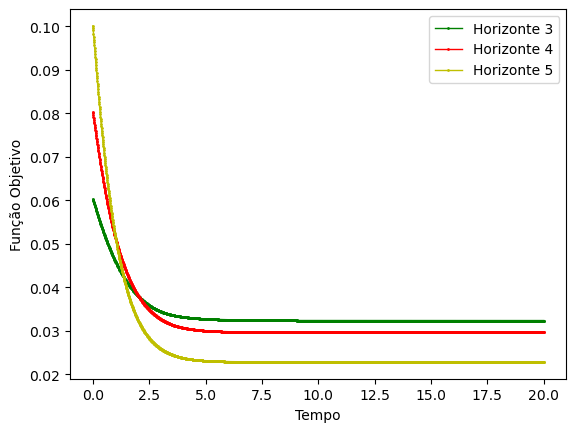

In [11]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo4[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo1.png', format='png')
plt.show()

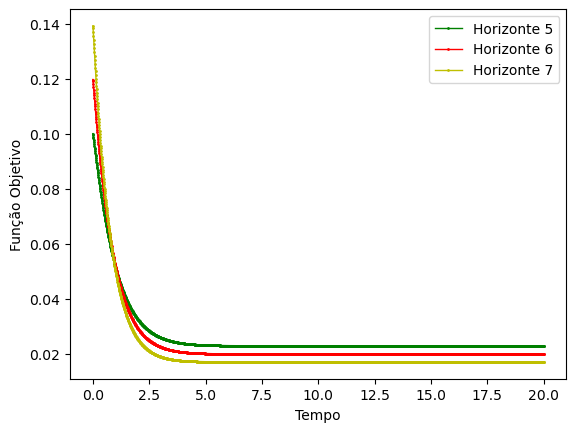

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.plot(ts, abs(valoresFuncaoObjetivo6[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 6")
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo2.png', format='png')
plt.show()

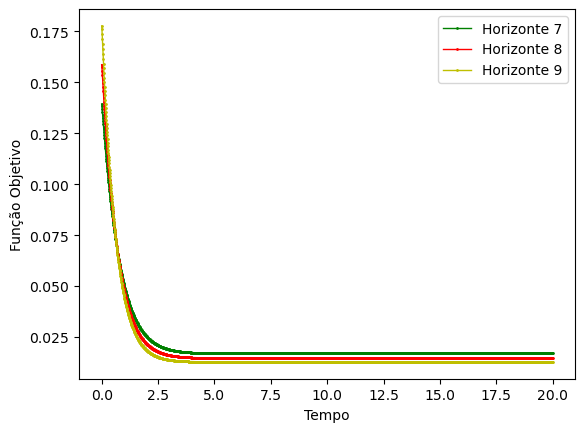

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.plot(ts, abs(valoresFuncaoObjetivo8[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 8")
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo3.png', format='png')
plt.show()

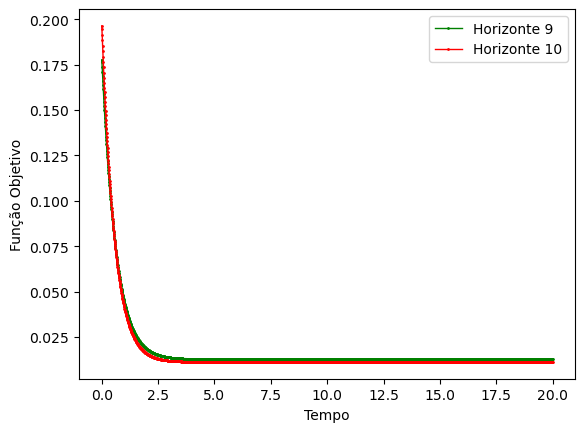

In [14]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.plot(ts, abs(valoresFuncaoObjetivo10[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo4.png', format='png')
plt.show()

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem do ajuste.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

[405, 806, 1206, 1607, 1999]
[400, 800, 1200, 1600, 1999]


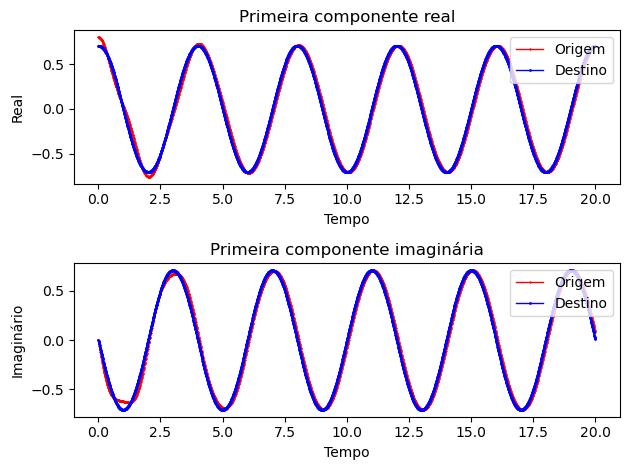

In [15]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

diferencaAbsoluta3 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    diferencaAbsoluta3[0][i] = ((abs(valoresOnda3[0][i]) - abs(evolucaoDestino[0][i])))
    diferencaAbsoluta3[1][i] = ((abs(valoresOnda3[1][i]) - abs(evolucaoDestino[1][i])))
    
    
teste = []
teste2 = []
for i in range(250, 2000, 350):
    maiores = []
    maiores2 = []
    for j in range(i, i+350):
        maiores.append(realObjetivoPrimeiraComponente[j])
        maiores2.append(realDestinoPrimeiraComponente[j])
    teste.append(np.max(maiores))
    teste2.append(np.max(maiores2))

tempo = []
i = 250
j = 0
while i < 2000 and j < len(teste):
    if (realObjetivoPrimeiraComponente[i] == teste[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

tempo = []
i = 250
j = 0
while i < 2000 and j < len(teste2):
    if (realDestinoPrimeiraComponente[i] == teste2[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

[133, 264, 398, 531, 664, 931, 1064, 1198, 1331, 1464, 1598, 1731, 1998]
[133, 267, 400, 533, 667, 800, 1067, 1200, 1333, 1467, 1600, 1733, 1867]


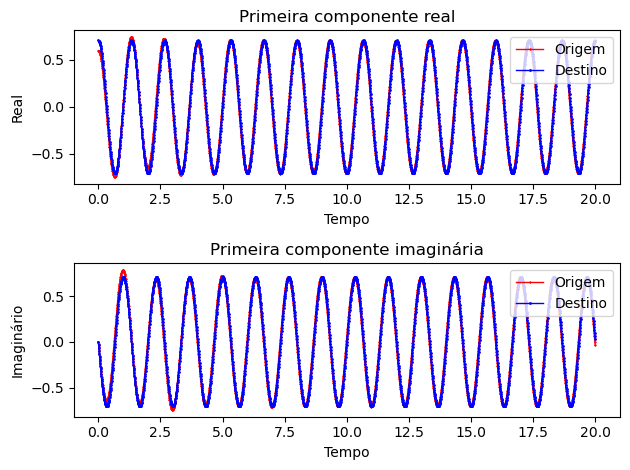

In [16]:
# Plotagem

teste = []
teste2 = []
for i in range(50, 2000, 150):
    maiores = []
    maiores2 = []
    for j in range(i, i+150):
        maiores.append(realObjetivoSegundaComponente[j])
        maiores2.append(realDestinoSegundaComponente[j])
    teste.append(np.max(maiores))
    teste2.append(np.max(maiores2))

tempo = []
i = 100
j = 0
while i < 2000 and j < len(teste):
    if (realObjetivoSegundaComponente[i] == teste[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

tempo = []
i = 100
j = 0
while i < 2000 and j < len(teste2):
    if (realDestinoSegundaComponente[i] == teste2[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)


plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

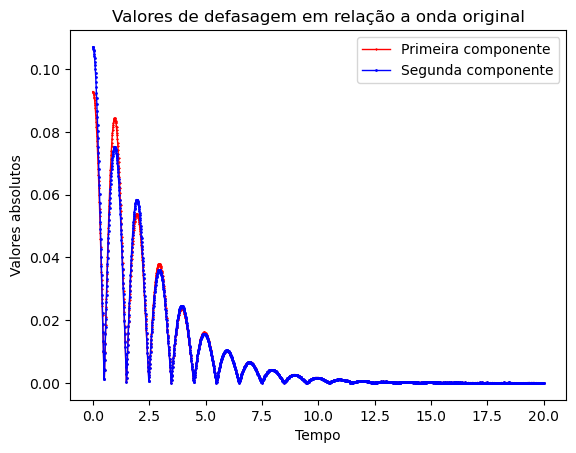

In [17]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(diferencaAbsoluta3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(diferencaAbsoluta3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [18]:
from scipy.integrate import trapz

# Processo de integração numérica usando o método dos trapézios

x=np.linspace(0,20,2000) # Espaçamento

Integral = trapz(diferencaAbsoluta3[0],x)

print(Integral)

Integral = trapz(diferencaAbsoluta3[1],x)

print(Integral)

(-0.0029143193704416694+0j)
(-0.008899817331163266+0j)


[402, 802, 1202, 1602, 1999]
[400, 800, 1200, 1600, 1999]
[0, 400, 800, 1200, 1600]


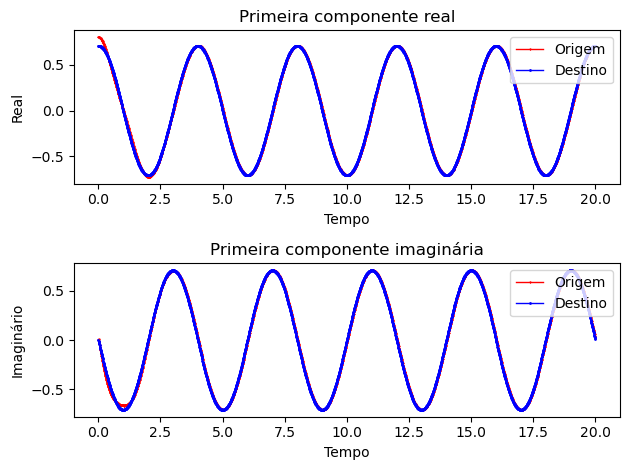

In [19]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda10[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda10[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda10[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda10[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem10 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem10[0][i] = ((abs(valoresOnda10[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem10[1][i] = ((abs(valoresOnda10[1][i]) - abs(evolucaoDestino[1][i])))
    
teste = []
teste2 = []
for i in range(250, 2000, 350):
    maiores = []
    maiores2 = []
    for j in range(i, i+350):
        maiores.append(realObjetivoPrimeiraComponente[j])
        maiores2.append(realDestinoPrimeiraComponente[j])
    teste.append(np.max(maiores))
    teste2.append(np.max(maiores2))

tempo = []
i = 250
j = 0
while i < 2000 and j < len(teste):
    if (realObjetivoPrimeiraComponente[i] == teste[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

tempo = []
i = 250
j = 0
while i < 2000 and j < len(teste2):
    if (realDestinoPrimeiraComponente[i] == teste2[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

tempo = []
for i in range(0, 2000):
    if (realDestinoPrimeiraComponente[i] == 1/np.sqrt(2)):
        tempo.append(i)

print(tempo)

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

[133, 266, 399, 533, 799, 933, 1066, 1199, 1333, 1466, 1599, 1733, 1999]
[133, 267, 400, 533, 667, 800, 1067, 1200, 1333, 1467, 1600, 1733, 1867]


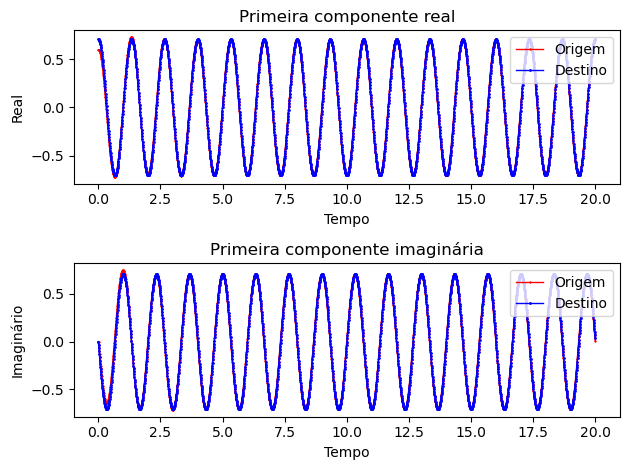

In [20]:
# Plotagem

teste = []
teste2 = []
for i in range(50, 2000, 150):
    maiores = []
    maiores2 = []
    for j in range(i, i+150):
        maiores.append(realObjetivoSegundaComponente[j])
        maiores2.append(realDestinoSegundaComponente[j])
    teste.append(np.max(maiores))
    teste2.append(np.max(maiores2))

tempo = []
i = 100
j = 0
while i < 2000 and j < len(teste):
    if (realObjetivoSegundaComponente[i] == teste[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

tempo = []
i = 100
j = 0
while i < 2000 and j < len(teste2):
    if (realDestinoSegundaComponente[i] == teste2[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)


plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

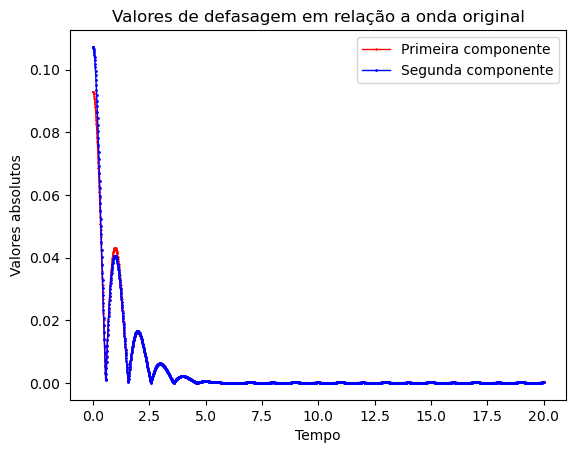

In [21]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [22]:
from scipy.integrate import trapz

# Processo de integração numérica usando o método dos trapézios

x=np.linspace(0,20,2000) # Espaçamento

Integral = trapz(defasagem10[0],x)

print(Integral)

Integral = trapz(defasagem10[1],x)

print(Integral)

(0.013235787485085068+0j)
(-0.018398821930506185+0j)


### Avaliação das constantes



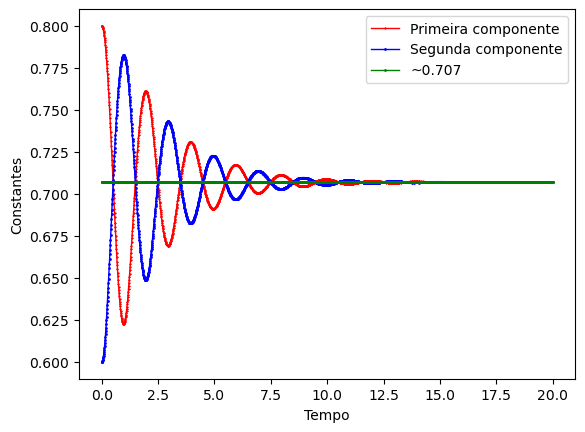

In [23]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

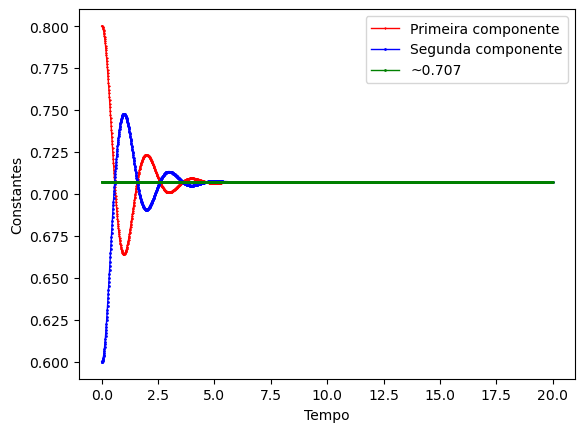

In [24]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

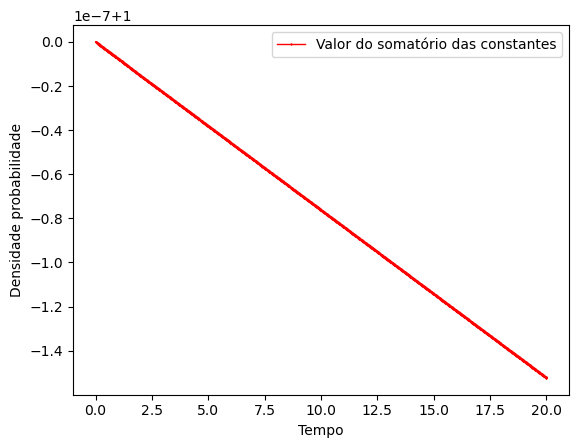

In [25]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes10[0][i])**2+abs(constantes10[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()